In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# EDA에 필요한 패키지 불러오기
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
import tqdm as tqdm

# 데이터와 submission 불러오기
train = pd.read_csv('/content/drive/MyDrive/데이콘/전력사용량 예측/train.csv', encoding = 'cp949')
test = pd.read_csv('/content/drive/MyDrive/데이콘/전력사용량 예측/test.csv',encoding = 'cp949')
submission = pd.read_csv('/content/drive/MyDrive/데이콘/전력사용량 예측/sample_submission.csv', encoding = 'cp949')

In [3]:
# 데이터 알아보기
print('--------------- train ---------------------')
# train 데이터 확인해 보기
display(train.head())

print('--------------- test ----------------------')
# test 데이터 확인해 보기
display(test.head())

--------------- train ---------------------


,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0


--------------- test ----------------------


,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,NaN,NaN
1,1,2020-08-25 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-08-25 02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-08-25 03,27.3,1.1,78.0,NaN,0.0,NaN,NaN
4,1,2020-08-25 04,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# 결측치 확인하기
print('train 결측치', '\n' ,train.isnull().sum())
print('test 결측치', '\n', test.isnull().sum())

train 결측치 
 num           0
date_time     0
전력사용량(kWh)    0
기온(°C)        0
풍속(m/s)       0
습도(%)         0
강수량(mm)       0
일조(hr)        0
비전기냉방설비운영     0
태양광보유         0
dtype: int64
test 결측치 
 num                0
date_time          0
기온(°C)          6720
풍속(m/s)         6720
습도(%)           6720
강수량(mm, 6시간)    8400
일조(hr, 3시간)     6720
비전기냉방설비운영       7784
태양광보유           8456
dtype: int64


In [5]:
# 데이터 타입확인하기
print('train.shape',train.shape)
print('test.shape', test.shape)

train.shape (122400, 10)
test.shape (10080, 9)


## 종속변수 확인해보기

In [6]:
# 전력사용량(kWh)로 표시해주기 너무 불편함으로 target이라고 바꿔주자.
# 각 날씨 데이터에 단위가 적혀있는 부분이 불편하다고 생각하여 전부 바꿔준다.
train=train.rename(columns = {'기온(°C)':'Temperatures', '풍속(m/s)':'Wind speed',
                              '습도(%)':'Humidity',
                              '강수량(mm)':'Precipitation','일조(hr)':'sunshine','전력사용량(kWh)': 'target'})

test=test.rename(columns = {'기온(°C)':'Temperatures', '풍속(m/s)':'Wind speed',
                              '습도(%)':'Humidity',
                              '강수량(mm, 6시간)':'Precipitation','일조(hr, 3시간)':'sunshine'})

In [7]:
# 우리는 회귀분석을 진행함으로 종속변수를 정규화를 진행해 준다.
train['log_target'] = train['target'].apply(lambda x: np.log1p(x))

# log_target을 한 데이터가 정규분포를 따르는지 확인해보자.
# train은 6~8 test는 8월의 데이터가 있고 여름의 데이터라고 생각했고 각 건물별로 온도와 target을 비교했다.
# 그러나 데이터를 보게 되면 정규분포를 따르지 않는 건물들이 많다고 판단했고 온도와 관련이 있는 건물도 있고 없는 건물도 있는것을 확인했다.
for i in train['num'].unique():
  fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
  sns.distplot(train[train['num'] == i]['log_target'], ax = ax[0])
  ax[0].set_title(f'{i}')
  sns.scatterplot(data = train[train['num'] == i], x = 'Temperatures', y = 'target', ax= ax[1])
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

Text(0.5, 1.0, 'boxenplot of target')

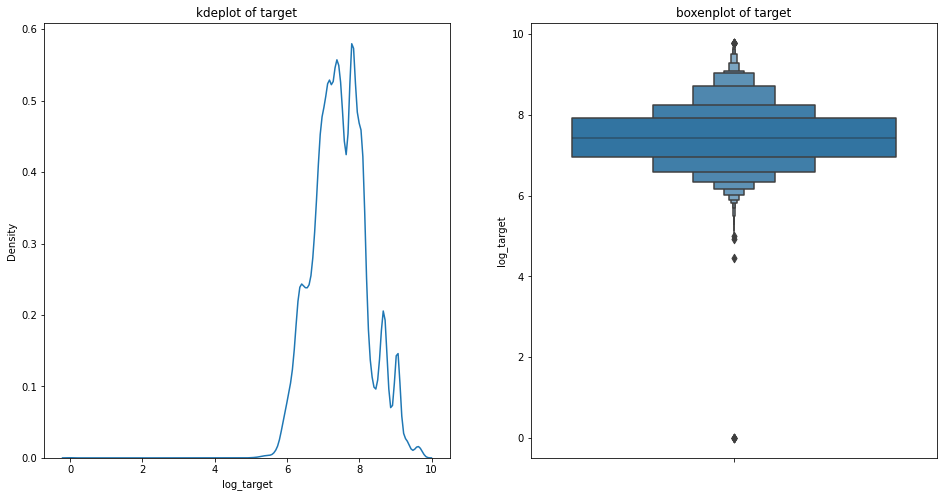

In [8]:
# 정규화가 되어있지 않고 1000~2500까지 많은데이터가 분포되어잇다.
# 그리고 boxenplot을 보게되면 전력 사용량이 0인 부분은 이상치로 판단을 했고 나중에 지워주기로 하자.
fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
sns.kdeplot(data = train, x = 'log_target', ax = ax[0])
ax[0].set_title('kdeplot of target')

sns.boxenplot(data = train, y = 'log_target', ax = ax[1])
ax[1].set_title('boxenplot of target')

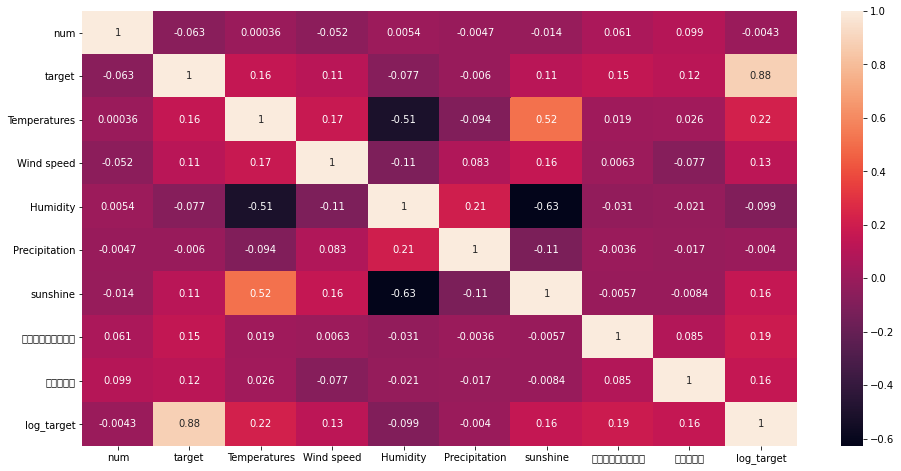

In [9]:
# 상관관계를 확인해 본다.
# 상관관계를 보면 target과의 상관관계가 0.3을 넘는 데이터가 없고 하나하나 분석을 진행해 주면서 기준을 잡아가야겠다고 생각했다.
train_corr=train.corr()
plt.figure(figsize = (16,8))
sns.heatmap(train_corr, annot = True)

# EDA

## num(한 건물을 나타낸다.)

In [10]:
# 60개의 건물이 있다는 것을 확인했다.
train.num.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60])

In [11]:
# 전력사용량이 각 건물마다 다르다는 것을 확인했다.
for i in train['num'].unique():
  print(f'{i}의 전력사용량 평균 :',train[train['num'] == i]['target'].mean())

1의 전력사용량 평균 : 8543.273488235285
2의 전력사용량 평균 : 1299.914364705882
3의 전력사용량 평균 : 3371.35369868873
4의 전력사용량 평균 : 763.9973532264703
5의 전력사용량 평균 : 2714.509694117642
6의 전력사용량 평균 : 1184.129867647058
7의 전력사용량 평균 : 1527.1383557663721
8의 전력사용량 평균 : 8837.364072576485
9의 전력사용량 평균 : 1256.8848800392143
10의 전력사용량 평균 : 1427.1640686279452
11의 전력사용량 평균 : 2391.372635294114
12의 전력사용량 평균 : 1748.853338408286
13의 전력사용량 평균 : 1089.1152000000013
14의 전력사용량 평균 : 1770.6162191065212
15의 전력사용량 평균 : 2198.9732657877425
16의 전력사용량 평균 : 1660.8284470588196
17의 전력사용량 평균 : 1019.7950294117652
18의 전력사용량 평균 : 1797.6362438865146
19의 전력사용량 평균 : 827.1935867647065
20의 전력사용량 평균 : 1463.527202941175
21의 전력사용량 평균 : 1662.0937941176453
22의 전력사용량 평균 : 1203.9658941176478
23의 전력사용량 평균 : 1884.175208520592
24의 전력사용량 평균 : 3114.6401647058783
25의 전력사용량 평균 : 1519.1799266330397
26의 전력사용량 평균 : 2987.688676262257
27의 전력사용량 평균 : 666.1422407866667
28의 전력사용량 평균 : 2264.569570588238
29의 전력사용량 평균 : 861.0742481832845
30의 전력사용량 평균 : 5761.224313996566
31의 전력사

## date_time

In [12]:
# 월, 일, 시간 별로 나누는 함수 만들기
def date_time(df, columns = 'date_time'):
    df['month'] = df[columns].apply(lambda x: x[5:7])
    df['day'] = df[columns].apply(lambda x:x[8:10])
    df['hour'] = df[columns].apply(lambda x:x[11:])
    return df
# train데이터에 적용시켜주기
train = date_time(train)
test = date_time(test)

In [13]:
# 평일과 공휴일 함수 만들기
def weekday(df, columns = 'date_time'):
    df[columns]=pd.to_datetime(df[columns])
    df['weekday'] = df[columns].apply(lambda x:x.weekday())
    df['weekend'] = df['weekday']
    df['weekday'] = df['weekday'].apply(lambda x:1 if x > 4 else 0)
    df['date'] = df[columns].dt.date
    return df
# 평일과 공휴일 함수 적용시켜주기
train=weekday(df = train)
test = weekday(df = test)

### 월별 데이터 확인해보기

Text(0.5, 1.0, 'boxnplot - month of target')

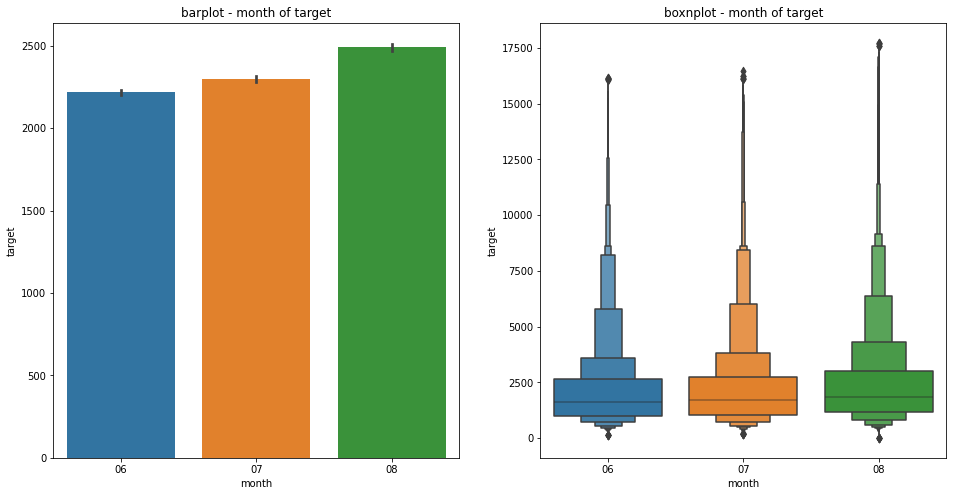

In [14]:
# train으로 month별 target을 그래프로 그린다.
# 시간이 지남에 따라서 전력사용량이 높아지는 것을 확인했다.
fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
sns.barplot(data = train, x = 'month', y = 'target', ax = ax[0])
ax[0].set_title('barplot - month of target')

sns.boxenplot(data = train, x= 'month', y = 'target', ax = ax[1])
ax[1].set_title('boxnplot - month of target')

### 일별 확인해 보기

Text(0.5, 1.0, 'boxenplot - day of target')

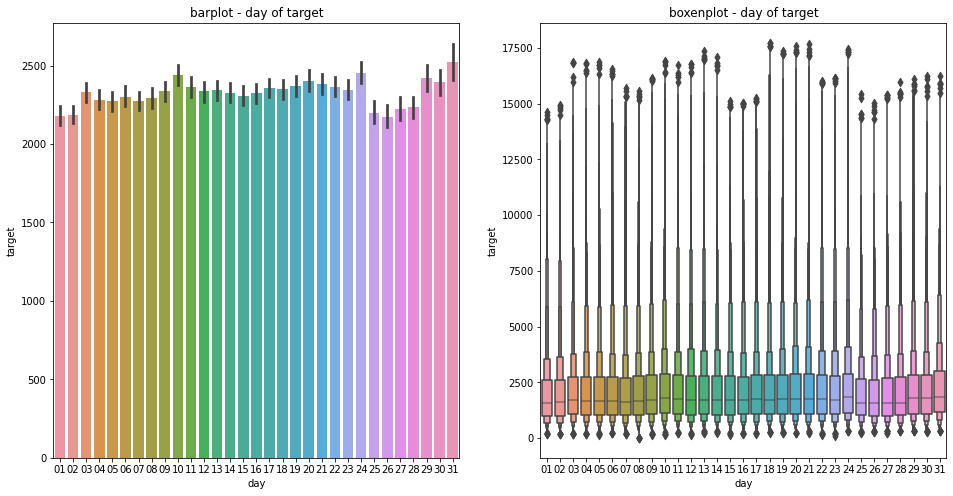

In [15]:
# 일별로 target에 영향이 없다고 판단했다.
fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
sns.barplot(data = train, x = 'day', y = 'target', ax = ax[0])
ax[0].set_title('barplot - day of target')

sns.boxenplot(data = train, x = 'day', y = 'target', ax = ax[1])
ax[1].set_title('boxenplot - day of target')

### 시간별 확인해 보기

Text(0.5, 1.0, 'boxenplot - hour of target')

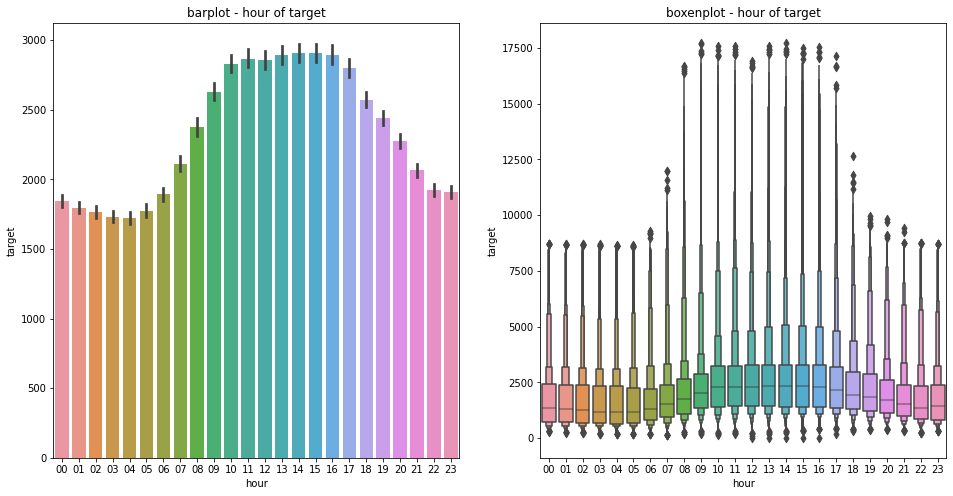

In [16]:
# 시간별로 데이터를 봤을 때 시간별로는 차이가 있다고 확인했다.
# 데이터의 이상치가 많은 부분은 건물마다 전력사용량의 평균이 다르기 때문이라고 생각했다.
fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
sns.barplot(data = train, x = 'hour', y = 'target', ax = ax[0])
ax[0].set_title('barplot - hour of target')

sns.boxenplot(data = train, x = 'hour', y = 'target', ax = ax[1])
ax[1].set_title('boxenplot - hour of target')

### 평일과 주말로 비교해보기

Text(0.5, 1.0, 'boxenplot of weekday')

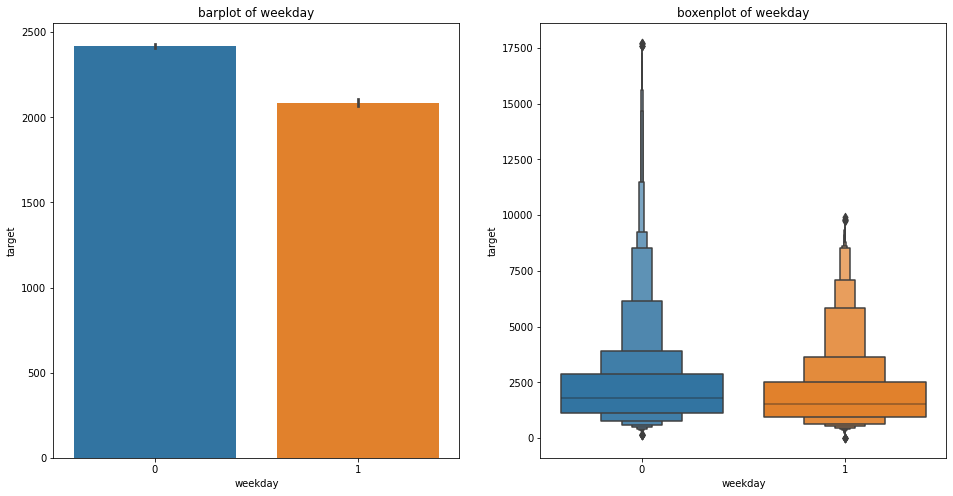

In [17]:
# 평일에 전력을 더 많이 사용한다.
fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
sns.barplot(data = train, x = 'weekday', y = 'target', ax = ax[0])
ax[0].set_title('barplot of weekday')

sns.boxenplot(data = train, x = 'weekday', y  ='target', ax = ax[1])
ax[1].set_title('boxenplot of weekday')

Text(0.5, 1.0, 'weekday month target')

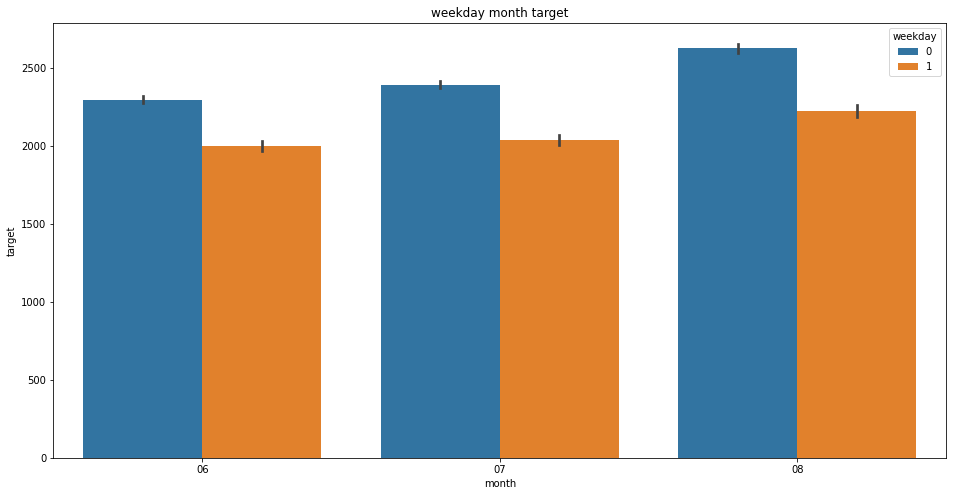

In [18]:
# 평일에 전력량이 높은 것은 월별로 차이가 있지 않았다.
plt.figure(figsize = (16,8))
sns.barplot(data = train, x = 'month', y = 'target', hue = 'weekday')
plt.title('weekday month target')

Text(0.5, 1.0, 'weekday day target')

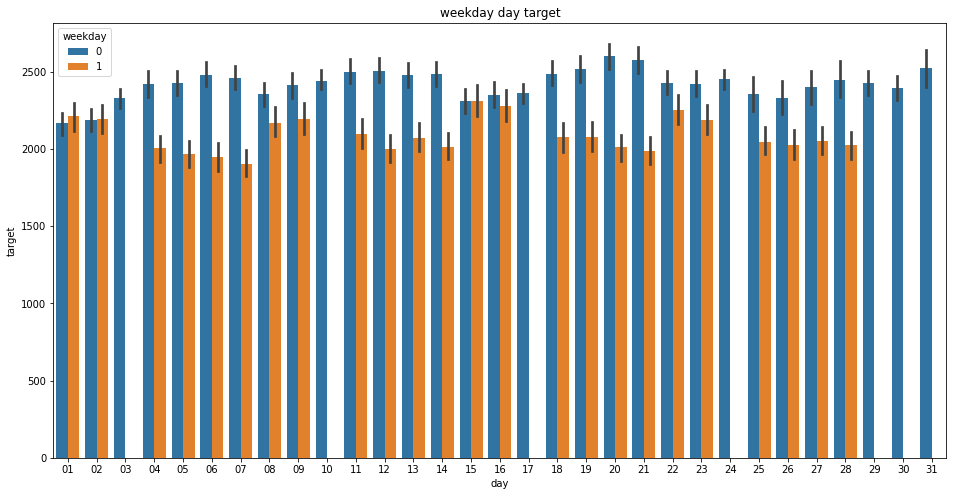

In [19]:
# 일별로 평일과 휴일도 차이가 없다고 판단했다.
plt.figure(figsize = (16,8))
sns.barplot(data = train, x = 'day', y = 'target', hue = 'weekday')
plt.title('weekday day target')

Text(0.5, 1.0, 'weekday hour target')

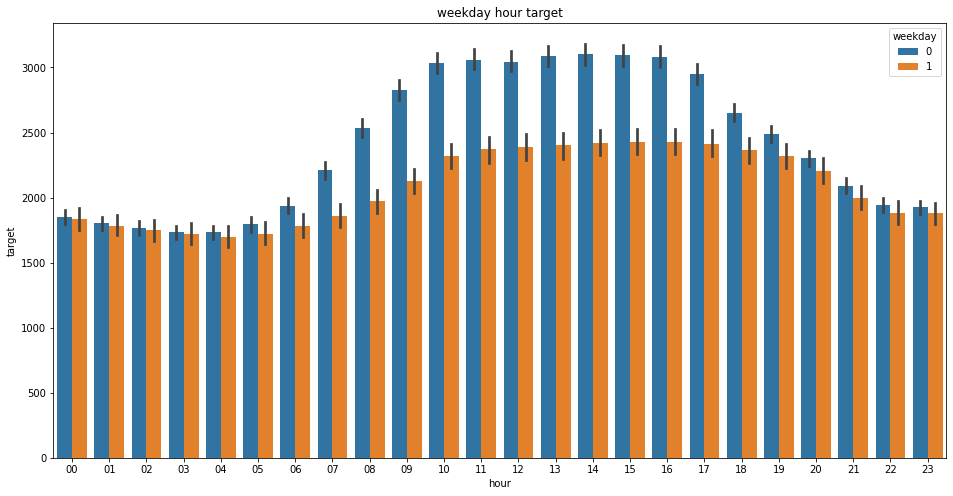

In [20]:
# 시간별로 평일과 휴일의 전력사용량을 확인해봤다.
# 9~6시까지 전력사용량이 평일과 휴일에 따라서 많이 차이가 나는 것을 확인했다.
# 아마 직장에서 사용하는 전력 사용량이 많이 영향을 미치는 것으로 판단했다.
plt.figure(figsize = (16,8))
sns.barplot(data = train, x = 'hour', y = 'target', hue = 'weekday')
plt.title('weekday hour target')

## 기온(Temperatures)

Text(0.5, 1.0, 'Temperatures of target - scatterplot')

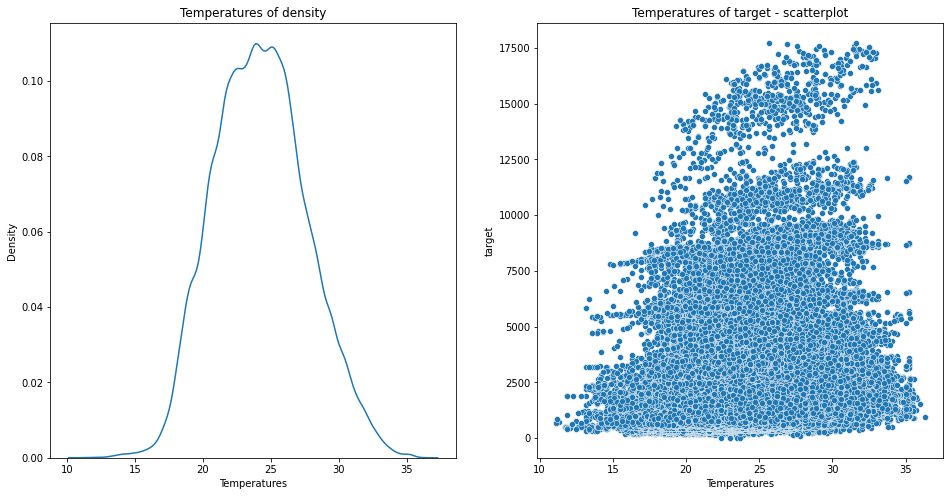

In [21]:
# Temperatures는 정규분포를 띄고 있고 scatterplot에서는 연관이 없다고 생각된다.
fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
sns.kdeplot(train['Temperatures'], ax = ax[0])
sns.scatterplot(data = train, x = 'Temperatures', y = 'target', ax = ax[1])
ax[0].set_title('Temperatures of density')
ax[1].set_title('Temperatures of target - scatterplot')

In [22]:
# 온도를 binning을 한 이후에 모델을 돌려봤을 때 좋은 결과가 나오지 않았기 때문에 사용하지 않는다.
# train['Temperatures'].describe()

# 데이터를 나눠주는 것이 의미가 있다고 판단되지 않는다.
# train.loc[21.800000 >= train['Temperatures'], 'temperature_binning'] = 0
# train.loc[(21.800000 < train['Temperatures']) & (train['Temperatures'] < 24.200000), 'temperature_binning'] = 1
# train.loc[(24.200000 < train['Temperatures']) & (train['Temperatures'] < 26.500000), 'temperature_binning'] = 2
# train.loc[(26.500000 < train['Temperatures']), 'temperature_binning'] = 3

# test.loc[21.800000 >= test['Temperatures'], 'temperature_binning'] = 0
# test.loc[(21.800000 < test['Temperatures']) & (test['Temperatures'] < 24.200000), 'temperature_binning'] = 1
# test.loc[(24.200000 < test['Temperatures']) & (test['Temperatures'] < 26.500000), 'temperature_binning'] = 2
# test.loc[(26.500000 < test['Temperatures']), 'temperature_binning'] = 3

In [23]:
# fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
# sns.barplot(data = train, x = 'temperature_binning', y = 'target', ax = ax[0])
# ax[0].set_title('temperature_binning barplot')

# sns.boxenplot(data = train, x = 'temperature_binning', y = 'target', ax = ax[1])
# ax[1].set_title('temperature_binning boxenplot')

## 풍향(Wind speed)

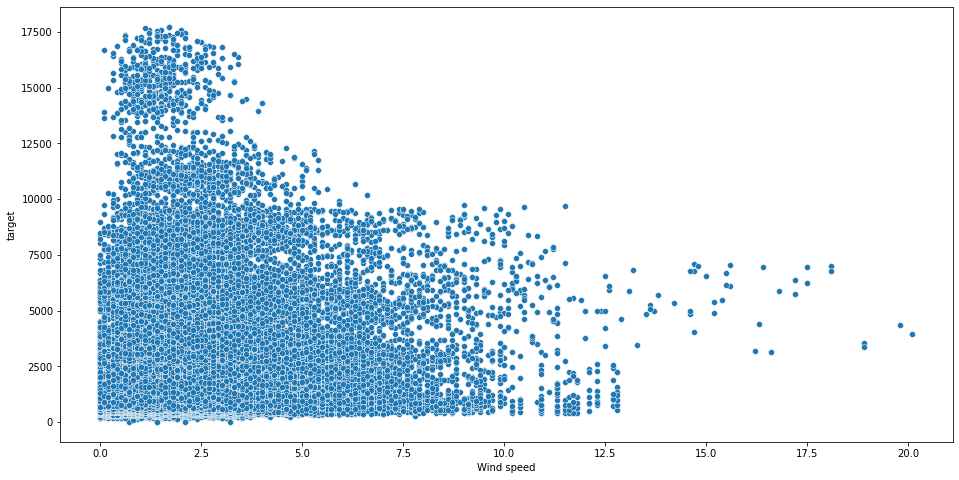

In [24]:
# scatterplot으로 봤을 때 풍속의 분포도 target변수와 연관이 있다고 생각하지 않는다.
plt.figure(figsize = (16,8))
sns.scatterplot(data =train, x = 'Wind speed', y = 'target')

## 습도(Humidity)

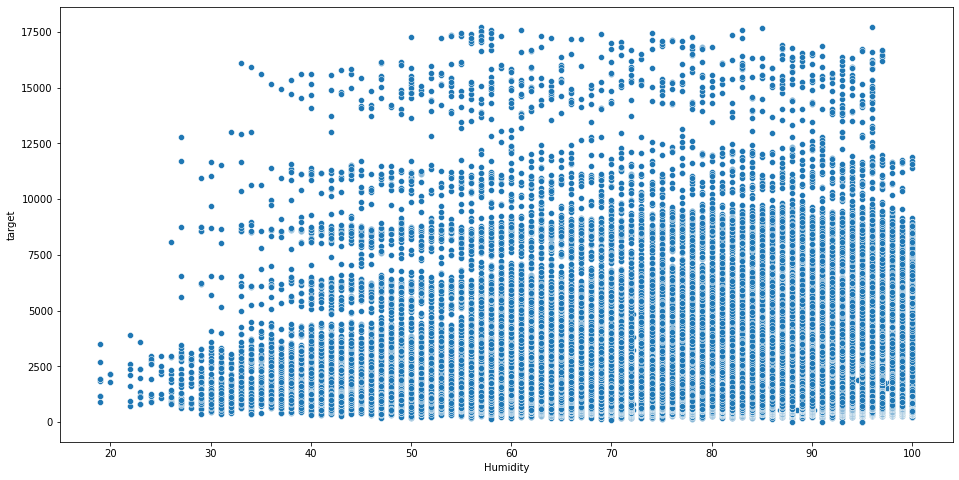

In [25]:
# scatterplot으로 봤을 때 습도의 분포도 target변수와 연관이 있다고 생각하지 않는다.
plt.figure(figsize = (16,8))
sns.scatterplot(data = train, x = 'Humidity', y = 'target')

## 강수량(Precipitation)

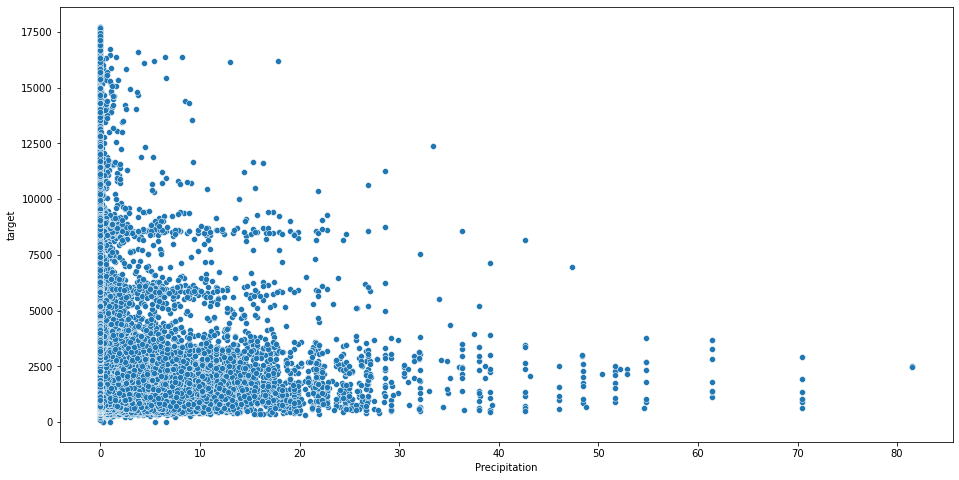

In [26]:
# scatterplot으로 봤을 때 강수량의 분포도 target변수와 연관이 있다고 생각하지 않는다.
plt.figure(figsize = (16,8))
sns.scatterplot(data = train, x = 'Precipitation', y = 'target')

## 일조(sunshine)

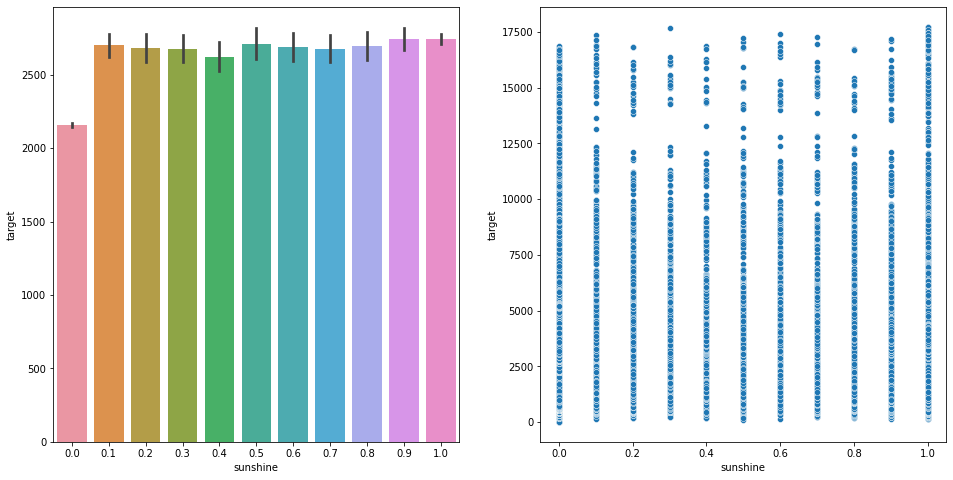

In [27]:
# 일조의 데이터는 target변수와 연관이 있다고 생각되지 않는다.
# 그러나 특이한 점은 0번에서 target이 많이 낮아지는 것을 확인했다.
fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
sns.barplot(data = train, x = 'sunshine', y = 'target', ax = ax[0])

sns.scatterplot(data = train, x = 'sunshine', y = 'target', ax = ax[1])

## 비전기냉방설비운영

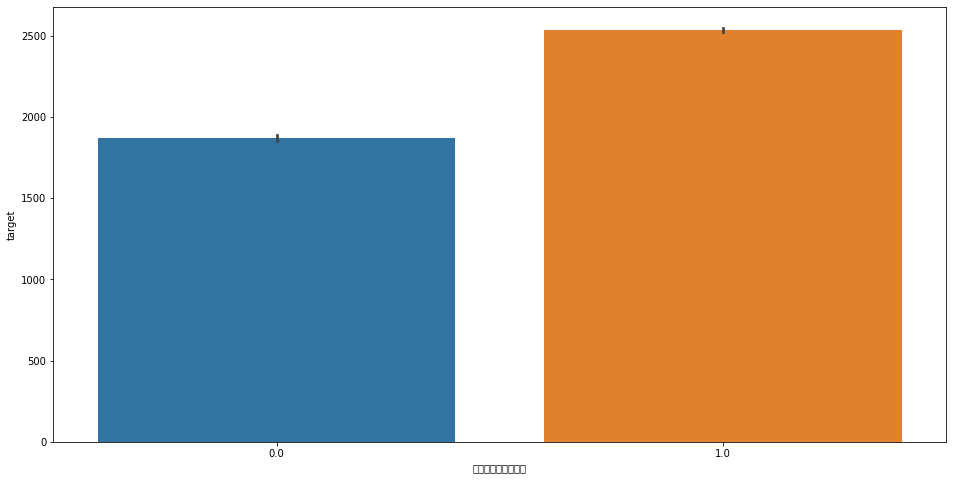

In [28]:
# 비전기냉방설비운영별로 차이가 있다고 생각된다.
plt.figure(figsize = (16,8))
sns.barplot(data = train, x = '비전기냉방설비운영', y = 'target')

In [29]:
# 비전기냉방설비운영을 안하고있다가 하고 있는 곳을 확인한다.
비전기냉방설비운영_0=list(train[train['비전기냉방설비운영'] == 0]['num'].unique())
비전기냉방설비운영_1=list(train[train['비전기냉방설비운영'] == 1]['num'].unique())

for i in 비전기냉방설비운영_0:
    비전기냉방설비운영_1.append(i)


len(비전기냉방설비운영_1) == len(train['num'].unique())

True

## 태양광보유

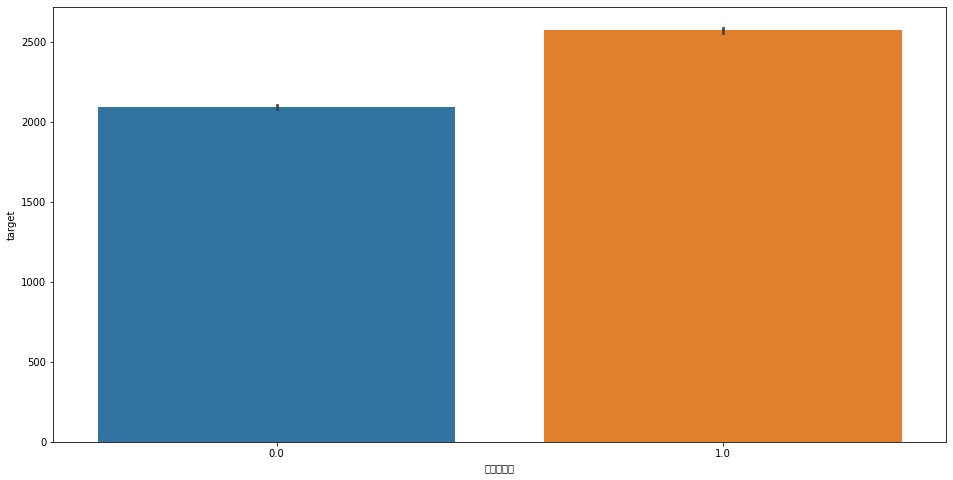

In [30]:
# 태양광을 보유했을 때 전력사용량이 많은것으로 확인했다.
plt.figure(figsize = (16,8))
sns.barplot(data = train, x = '태양광보유', y = 'target')

In [31]:
# 태양광을 보유하지 않다가 보유한 건물이 있는지 확인해 보자.
태양광보유_0 = list(train[train['태양광보유'] == 0]['num'].unique())
태양광보유_1 = list(train[train['태양광보유'] == 1]['num'].unique())

for i in 태양광보유_0:
    태양광보유_1.append(i)
    
len(태양광보유_1) == len(train['num'].unique())

True

In [32]:
# 비전기 냉방설비운영와 태양광보유를 가지고 new_column이라는 column을 만들어준다.
train.loc[(train['비전기냉방설비운영'] == 0) & (train['태양광보유'] == 0), 'new_column'] = 0
train.loc[(train['비전기냉방설비운영'] == 0) & (train['태양광보유'] == 1), 'new_column'] = 1
train.loc[(train['비전기냉방설비운영'] == 1) & (train['태양광보유'] == 0), 'new_column'] = 2
train.loc[(train['비전기냉방설비운영'] == 1) & (train['태양광보유'] == 1), 'new_column'] = 3

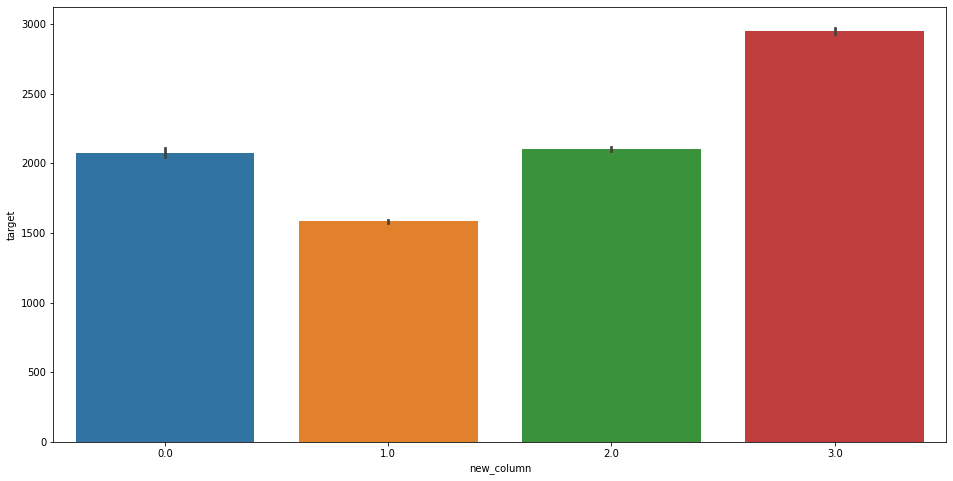

In [33]:
# 어차피 더미화 시켜줄거기 때문에 각 특성이 있다는 것만 확인한다.
plt.figure(figsize = (16,8))
sns.barplot(data = train, x = 'new_column', y = 'target')

## 체감온도 구하기

- 시게열 데이터의 train과 test데이터를 살펴 봤을 때 모두 여름철 데이터이다.
- 그러면 에어컨이나 선풍기 사용량이 증가하면서 전력사용량이 증가할 것이다.

https://news.joins.com/article/22841084


In [34]:
# 체감온도를 train과 test 전부 구해줘야하므로 함수를 사용하자.
def summer_temperature1(df = None):
  b = df['Humidity']

  T = df['Temperatures'].apply(lambda x: 32 + (1.8 * x))

  temperature = -42.379 + (2.04901523*T) + (10.14333127 * b ) - (0.22475541 * T * b) - (0.00683783 * (T ** 2)) - (0.05481717 * (b**2)) + (0.00122874 * (T**2) * b ) + (0.00085282 *  T * (b ** 2)) - (0.00000199 * (T **2) * (b ** 2))

  return temperature


train['열지수'] = summer_temperature1(train)
test['열지수']= summer_temperature1(test)

train['열지수'] = train['열지수'].apply(lambda x:round(x,1))
test['열지수'] = test['열지수'].apply(lambda x:round(x,1))

# 정규화를 해주려고 했지만 정규화를 하고 모델을 돌렸을 때 더 안좋은 결과가 나와서 해주지 않는다.
# binning을 하려고 했지만 기사를 찾아보던중에 우리나라의 열지수가 124를 넘는 경우가 거의 없기 때문에 나눠주는 것이 의미가 없다는 기사가 있어서 제거해주자.
# train['열지수'] = train['열지수'].apply(lambda x:np.log1p(x))
# test['열지수'] = test['열지수'].apply(lambda x:np.log1p(x))

# 데이터를 주의, 매우 주의, 위험, 매우위험 으로 나누어서 확인해보기
# train['열지수'] = pd.cut(train['열지수'], bins = [0,90,103,124,150], labels = [0,1,2,3])
# test['열지수'] = pd.cut(test['열지수'], bins = [0,90,103,124,150], labels = [0,1,2,3])

## 불쾌지수 구하기

- 여름철 불쾌지수가 전력량에 많은 영향을 미친다는 기사

https://news.mtn.co.kr/v/2016080818001268838

In [35]:
def 불쾌지수구하기(df = None):
    def 불쾌지수구하기(x):
        T = 'Temperatures'
        H = 'Humidity'
        불쾌지수 = (9/5 * x[T]) - (0.55 * (1 - x[H]/100) * ((9 / 5 * x[T]) - 26)) + 32
        
        return 불쾌지수
    불쾌지수  = 불쾌지수구하기(df)
    df['불쾌지수'] = 불쾌지수
    
    return df

train=불쾌지수구하기(train)
test = 불쾌지수구하기(test)

In [36]:
# 더미화를 시키면 test데이터의 경우 0번의 데이터가 없으므로 더미화는 시켜주지 않기로 한다.
# train['불쾌지수'] = pd.cut(train['불쾌지수'], bins = [0,68,75,80,200], labels = [0,1,2,3])
# test['불쾌지수'] = pd.cut(test['불쾌지수'], bins = [0,68,75,80,200], labels = [0,1,2,3])

In [37]:
# 대부분의 데이터가 불쾌지수가 올라 갈수록 높은 전력사용량을 갖고 있다.
for i in train['num'].unique():
  plt.figure(figsize = (16,8))
  sns.scatterplot(data = train[train['num'] == i], x = '불쾌지수', y = 'target')
  plt.title(f'{i}')
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Test EDA

In [38]:
# 데이터 살펴보기
test.head()

,num,date_time,Temperatures,Wind speed,Humidity,Precipitation,sunshine,비전기냉방설비운영,태양광보유,month,day,hour,weekday,weekend,date,열지수,불쾌지수
0,1,2020-08-25 00:00:00,27.8,1.5,74.0,0.0,0.0,NaN,NaN,08,25,00,0,1,2020-08-25,87.4,78.60228
1,1,2020-08-25 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,08,25,01,0,1,2020-08-25,NaN,NaN
2,1,2020-08-25 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,08,25,02,0,1,2020-08-25,NaN,NaN
3,1,2020-08-25 03:00:00,27.3,1.1,78.0,NaN,0.0,NaN,NaN,08,25,03,0,1,2020-08-25,86.4,78.34006
4,1,2020-08-25 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,08,25,04,0,1,2020-08-25,NaN,NaN


# Test의 결측치 채우기

In [39]:
test.isnull().sum()

num                 0
date_time           0
Temperatures     6720
Wind speed       6720
Humidity         6720
Precipitation    8400
sunshine         6720
비전기냉방설비운영        7784
태양광보유            8456
month               0
day                 0
hour                0
weekday             0
weekend             0
date                0
열지수              6720
불쾌지수             6720
dtype: int64

In [40]:
# 3시간마다 데이터가 입력될 때의 결측치와 6시간마다 데이터가 입력될때의 결측치의 개수와 지금 결측치의 개수가 똑같은지 확인해 보자.
print('3시간마다 데이터가 입력된다면 결측치의 값 :',len(test['Temperatures']) - (len(test['Temperatures'])/3))
print('6시간마다 데이터가 입력된다면 결측치의 값 :',len(test['Precipitation']) - len(test['Precipitation'])/ 6)

3시간마다 데이터가 입력된다면 결측치의 값 : 6720.0
6시간마다 데이터가 입력된다면 결측치의 값 : 8400.0


- 기온, 풍속, 습도. 일조는 3시간마다 데이터가 입력되어 있다.
- 그러나 강수량은 6시간마다 데이터가 입력되어 있기 때문에 결측치도 다르다.
- 그래서 이 데이터를 어떻게 해주어야 할지 고민해 봐야겠다.

### interpolate의 method를 어떤 방법으로 하는게 좋은지 잘 정리해놓은 코드 공유를 가져와 사용했다.
https://dacon.io/competitions/official/235736/codeshare/2844?page=1&dtype=recent

In [41]:
# 기온 결측치 채우기
test['Temperatures'] = test['Temperatures'].interpolate(method = 'quadratic')
# 마지막 na 채우기
test['Temperatures'] = test['Temperatures'].interpolate(method = 'linear')

# 풍속 결측치 채우기
test['Wind speed'] = test['Wind speed'].interpolate(method = 'linear')

# 습도 결측치 채우기
test['Humidity'] = test['Humidity'].interpolate(method = 'quadratic')
# 마지막 na 채우기
test['Humidity'] = test['Humidity'].interpolate(method = 'linear')

# 강수량 결측치 채우기
test['Precipitation'] = test['Precipitation'].interpolate(method = 'linear')

# test의 결측치를 채웠는지 확인하기
print('Temperatures의 결측치 :',test['Temperatures'].isnull().sum())
print('Wind speed 결측치 :',test['Wind speed'].isnull().sum())
print('Humidity 의 결측치 :',test['Humidity'].isnull().sum())

Temperatures의 결측치 : 0
Wind speed 결측치 : 0
Humidity 의 결측치 : 0


In [42]:
# Nan값으로 표시된 것은 전부 비전기냉방설비운영을 하지않는 사람인 것 같다.
test['비전기냉방설비운영'].value_counts()

1.0    2296
Name: 비전기냉방설비운영, dtype: int64

In [43]:
# Nan값으로 표시된 것은 전부 태양광보유를 하지 않은 사람이다.
test['태양광보유'].value_counts()

1.0    1624
Name: 태양광보유, dtype: int64

In [44]:
# 그러면 데이터를 같은 건물에 1이 있다면 건물을 1을 넣어주고 아니라면 0을 넣어주자.
# 비전기냉방설비운영
for num in test['num'].unique():
    if len(test[test['num'] == num]['비전기냉방설비운영'].value_counts()) == 1:
        test.loc[test['num'] == num, '비전기냉방설비운영'] = 1
    else:
        test.loc[test['num'] == num, '비전기냉방설비운영'] = 0

In [45]:
# 그러면 데이터를 같은 건물에 1이 있다면 건물을 1을 넣어주고 아니라면 0을 넣어주자.
# 태양광보유
for num in test['num'].unique():
    if len(test[test['num'] == num]['태양광보유'].value_counts()) == 1:
        test.loc[test['num'] == num, '태양광보유'] = 1
    else:
        test.loc[test['num'] == num, '태양광보유'] = 0

In [46]:
print(test['비전기냉방설비운영'].value_counts())
print(test['태양광보유'].value_counts())

1.0    6888
0.0    3192
Name: 비전기냉방설비운영, dtype: int64
0.0    5208
1.0    4872
Name: 태양광보유, dtype: int64


In [47]:
# train에 했던 것처럼 new_column을 만들어 준다.
test.loc[(test['비전기냉방설비운영'] == 0) & (test['태양광보유'] == 0), 'new_column'] = 0
test.loc[(test['비전기냉방설비운영'] == 0) & (test['태양광보유'] == 1), 'new_column'] = 1
test.loc[(test['비전기냉방설비운영'] == 1) & (test['태양광보유'] == 0), 'new_column'] = 2
test.loc[(test['비전기냉방설비운영'] == 1) & (test['태양광보유'] == 1), 'new_column'] = 3

# 냉방도일

 - 냉방도일에 관한 논문
http://www.riss.kr/search/detail/DetailView.do?p_mat_type=be54d9b8bc7cdb09&control_no=9f83c25f068764f0&outLink=K
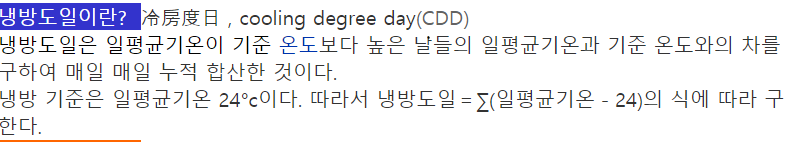

In [ ]:
# 냉방도일
def CDH(xs):
  ys = []
  for i in range(len(xs)):
    if i < 11:
      ys.append(np.sum(xs[:(i+1)]-26))
    else:
      ys.append(np.sum(xs[(i-11):(i+1)]-26))
  return np.array(ys)

# 냉방도일 = pd.concat([train,test], axis = 0)
# cdhs = np.array([])
# for num in range(1,61,1):
#   temp = 냉방도일[냉방도일['num'] == num]
#   cdh = CDH(temp['Temperatures'].values)
#   cdhs = np.concatenate([cdhs,cdh])

# train['냉방도일'] = cdhs[:train.shape[0]]
# test['냉방도일'] = cdhs[train.shape[0]:]
cdhs = np.array([])
for num in range(1,61,1):
  temp = train[train['num'] == num]
  cdh = CDH(temp['Temperatures'].values)
  cdhs = np.concatenate([cdhs,cdh])

train['냉방도일'] = cdhs

cdhs = np.array([])
for num in range(1,61,1):
  temp = test[test['num'] == num]
  cdh = CDH(temp['Temperatures'].values)
  cdhs = np.concatenate([cdhs,cdh])

  
test['냉방도일'] = cdhs

print(train['냉방도일'],test['냉방도일'])

print(train.isnull().sum().sum(), test.isnull().sum().sum())

In [49]:
# 냉방도일과 온도를 target과 비교해 본다.
# for i in train['num'].unique():
#   fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
#   sns.scatterplot(data = train[train['num'] == i], x = '냉방도일', y = 'target', hue = 'weekday', ax = ax[0])
#   ax[0].set_title(f'CDH - {i}')

#   sns.scatterplot(data = train[train['num'] == i], x = 'Temperatures', y = 'target', hue = 'weekday', ax = ax[1])
#   ax[1].set_title(f'Temperatures - {i}')
#   plt.show()

# =========================================================================== 온도와 냉방도일중 더 높은것으로 사용하기

In [50]:
# 냉방도일과 Temperatures로 비교해봤을 때 
for i in train['num'].unique():
  data = train[train['num'] == i]
  냉방도일_corr = data[['냉방도일','target']].corr()
  온도_corr = data[['Temperatures','target']].corr()
  if 냉방도일_corr.iloc[1,0] > 온도_corr.iloc[1,0]:
    print(f'{i}')

# 냉방도일이 온도보다 모델에 좋지 않다고 판단했다.

5
9
19
49
50


In [51]:
# 점수가 내려가는 관계로 이건 없애는 걸로 하자.
# train['냉방도일'] = train['냉방도일'].apply(lambda x:x + 151.3)
# test['냉방도일'] = test['냉방도일'].apply(lambda x:x + 151.3)

# train['냉방도일'] = train['냉방도일'].apply(lambda x:np.log1p(x))
# test['냉방도일'] = test['냉방도일'].apply(lambda x:np.log1p(x))

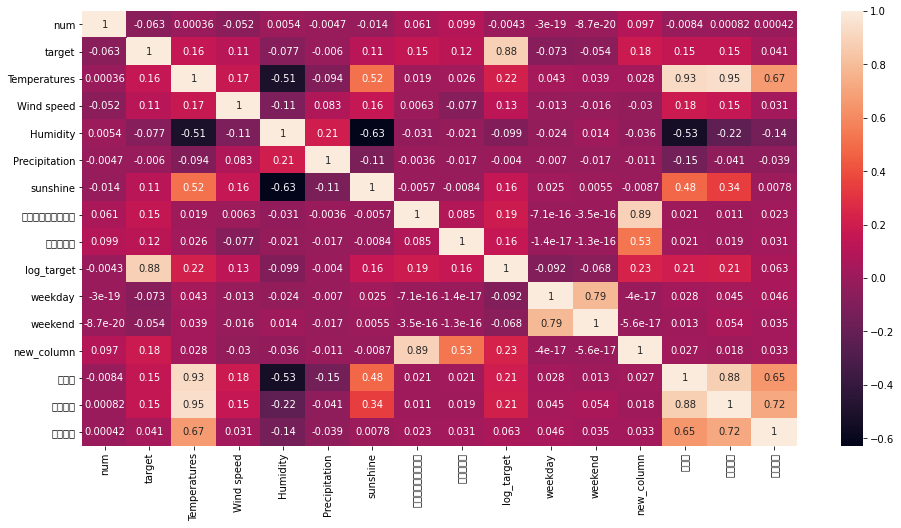

In [52]:
# 건물마다 특성이 다르기 때문에 상관성이 안좋게 나온다.
train_corr = train.corr()
plt.figure(figsize = (16,8))
sns.heatmap(train_corr, annot = True)

In [53]:
# 각 건물별 lineplot을 그려서 이상치를 판단해 보자.
for i in train['num'].unique():
  plt.figure(figsize = (16,8))
  sns.lineplot(data = train[train['num'] == i], x = 'date_time', y = 'target')
  plt.title(f'{i}')
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [54]:
# 데이터의 이상치를 제거해 줬을 때 점수가 올라가므로 보류하도록 하자.
# 31, 33, 1번은 private data에 들어가지 않는다.
# delete_index = train[(train['num'] == 31) & (train['target'] < 3000)].index
# train.drop(delete_index, axis = 0, inplace = True)

# delete_index = train[(train['num'] == 33) & (train['target'] < 1250)].index
# train.drop(delete_index, axis = 0, inplace = True)  

# delete_index = train[(train['num'] == 1) & (train['target'] < 8250) & (train['month'] == 7)].index
# train.drop(delete_index, axis = 0, inplace = True)

# delete_index = train[(train['num'] == 1) & (train['day'] <= '06')].index
# train.drop(delete_index, axis = 0, inplace = True)

# delete_index = train[(train['num'] == 16) & (train['target'] < 1400)].index
# train.drop(delete_index, axis = 0, inplace = True)

# delete_index = train[(train['num'] == 24) & (train['month'] == 6) & (train['day'] == '08')].index
# train.drop(delete_index, axis = 0, inplace = True)

# delete_index = train[(train['num'] == 25) & (train['target'] < 500)].index
# train.drop(delete_index, axis = 0, inplace = True)

# delete_index = train[(train['num'] == 45) & (train['target'] < 500)].index
# train.drop(delete_index, axis = 0, inplace = True)

# delete_index = train[(train['num'] == 36) & (train['target'] < 700)].index
# train.drop(delete_index, axis = 0, inplace = True)

# delete_index = train[(train['num'] == 49) & (train['target'] < 600)].index
# train.drop(delete_index, axis = 0, inplace = True)

# delete_index = train[(train['num'] == 52) & (train['target'] < 2500)].index
# train.drop(delete_index, axis = 0, inplace = True)

# delete_index = train[(train['num'] == 60) & (train['target'] < 2000)].index
# train.drop(delete_index, axis = 0, inplace = True)

# target이 0인 데이터만 지웠을 때 rmse가 낮아지므로 사용하도록 하자.
delete_index = train[train['target'] == 0].index
train.drop(delete_index, axis = 0, inplace = True)

In [55]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122395 entries, 0 to 122399
Data columns (total 21 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   num            122395 non-null  int64         
 1   date_time      122395 non-null  datetime64[ns]
 2   target         122395 non-null  float64       
 3   Temperatures   122395 non-null  float64       
 4   Wind speed     122395 non-null  float64       
 5   Humidity       122395 non-null  float64       
 6   Precipitation  122395 non-null  float64       
 7   sunshine       122395 non-null  float64       
 8   비전기냉방설비운영      122395 non-null  float64       
 9   태양광보유          122395 non-null  float64       
 10  log_target     122395 non-null  float64       
 11  month          122395 non-null  object        
 12  day            122395 non-null  object        
 13  hour           122395 non-null  object        
 14  weekday        122395 non-null  int64         
 15  

In [56]:
# dayofyear을 넣어주면 rmse가 더 높게 나오므로 기각시킨다.
# train['dayofyear'] = train['date_time'].dt.dayofyear
# test['dayofyear'] = test['date_time'].dt.dayofyear

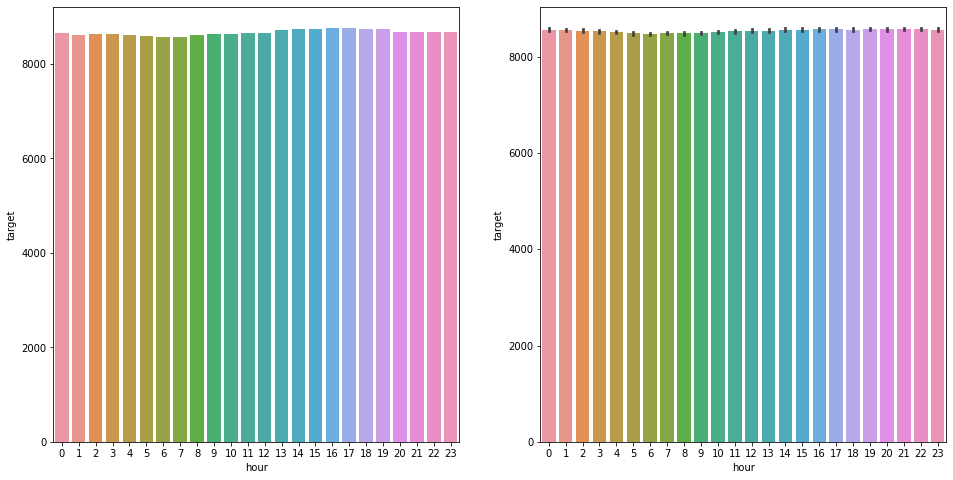

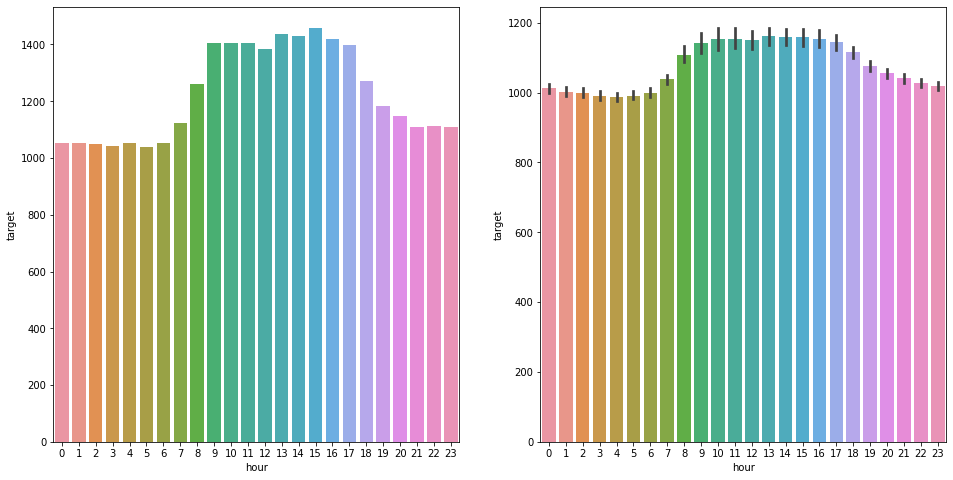

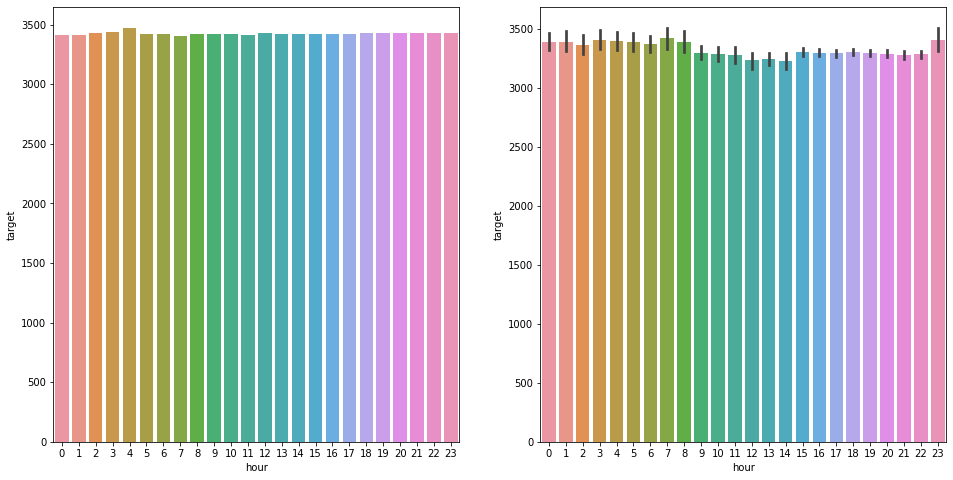

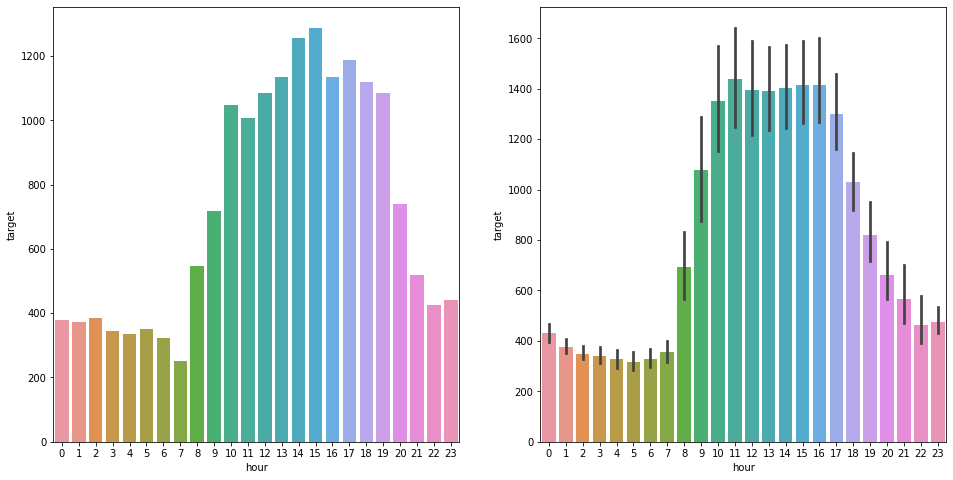

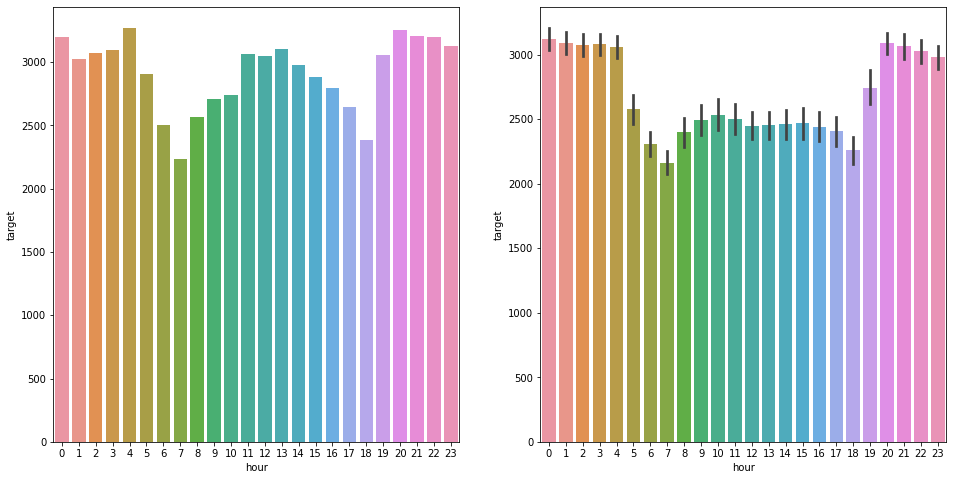

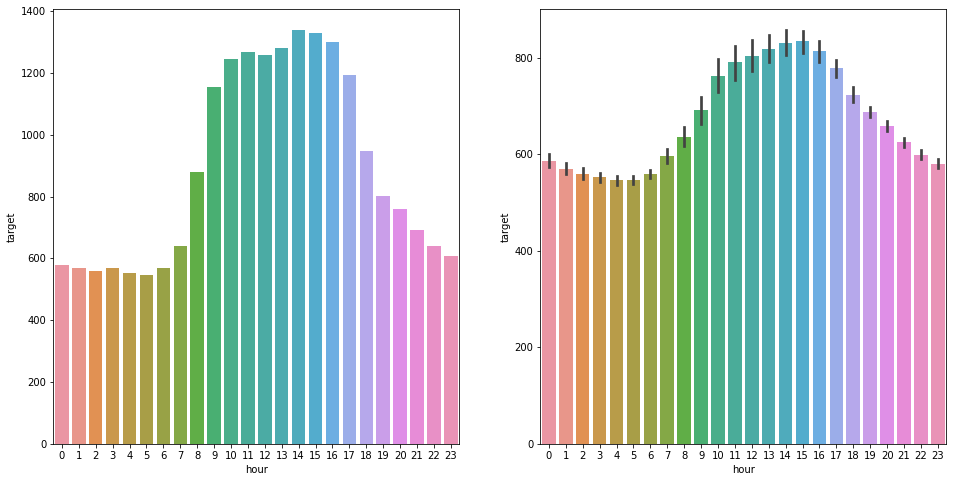

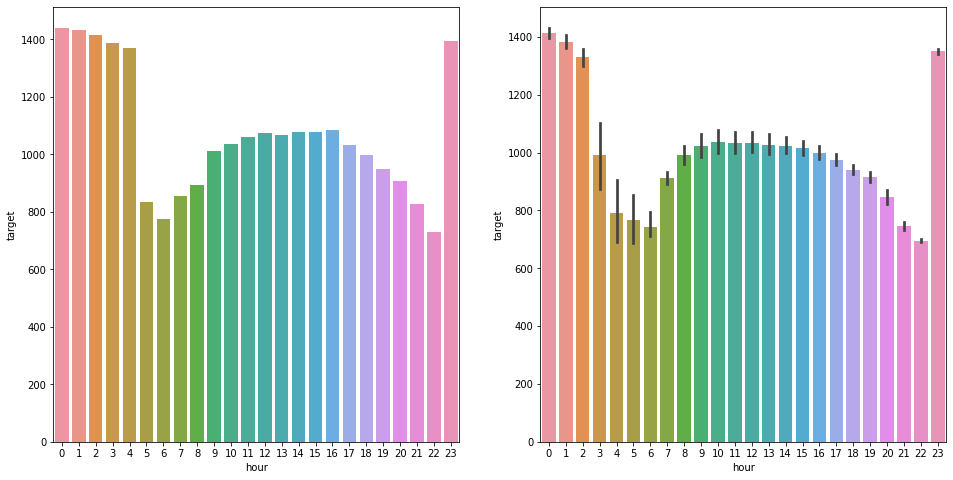

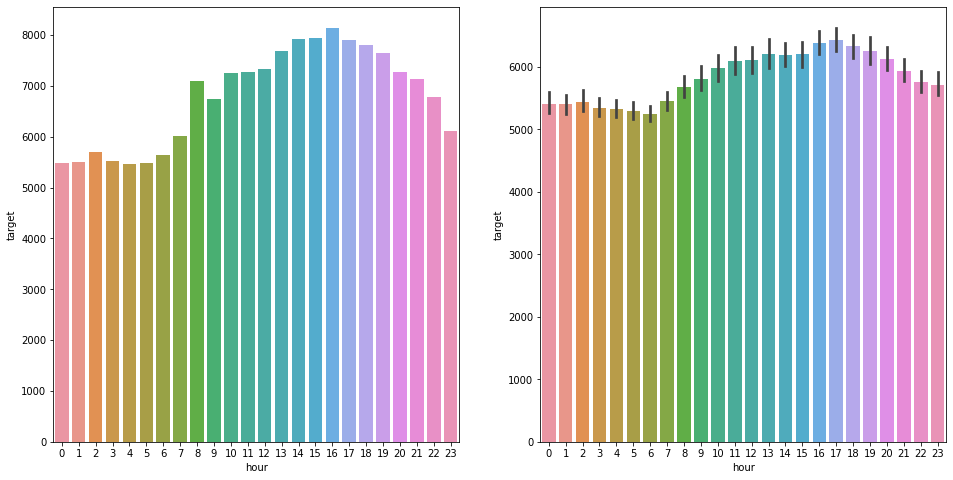

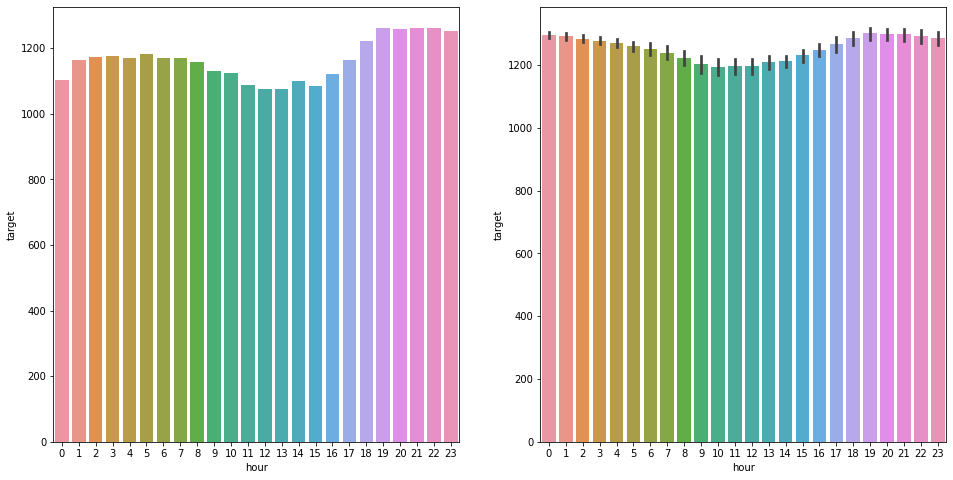

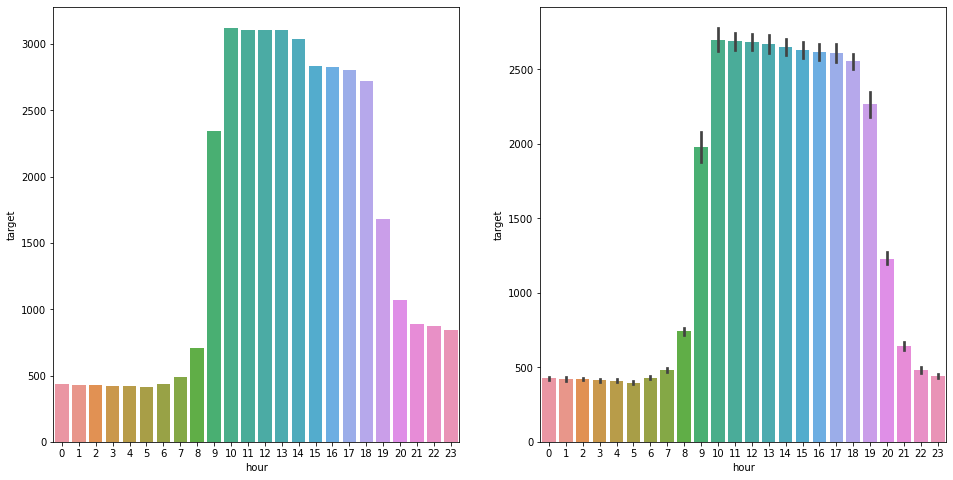

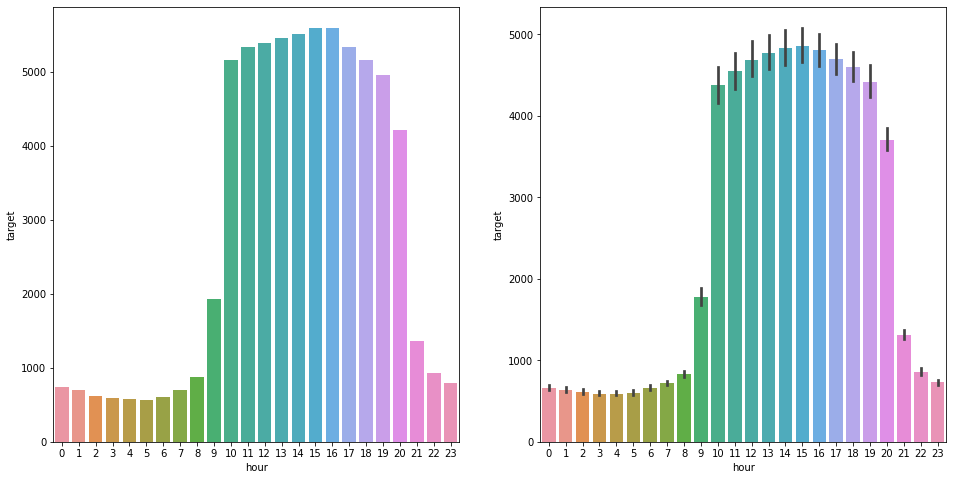

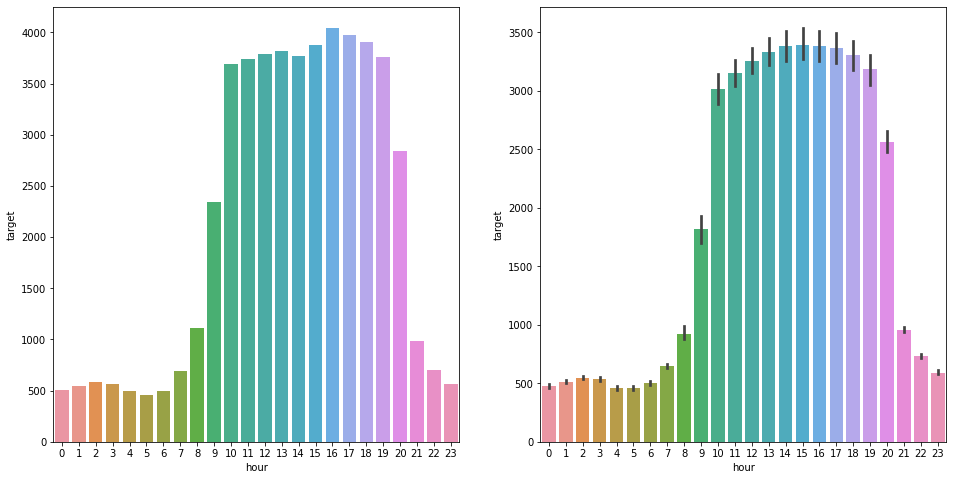

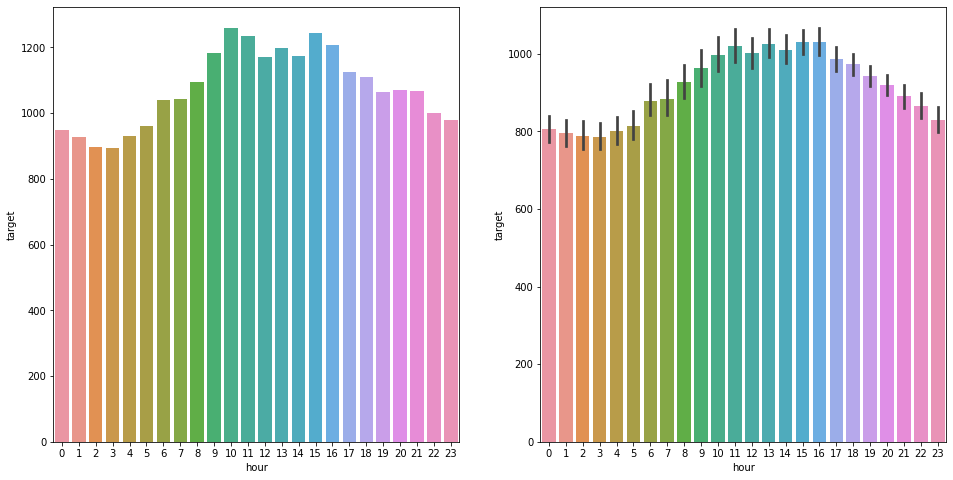

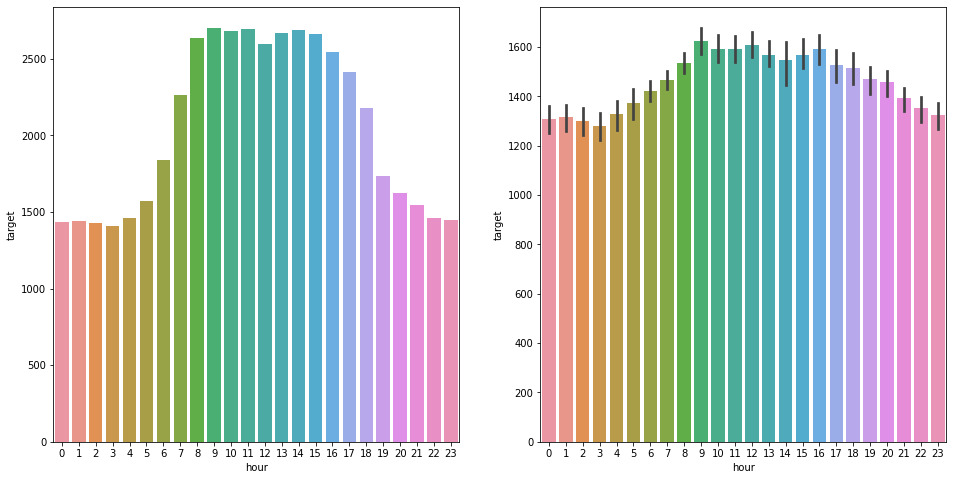

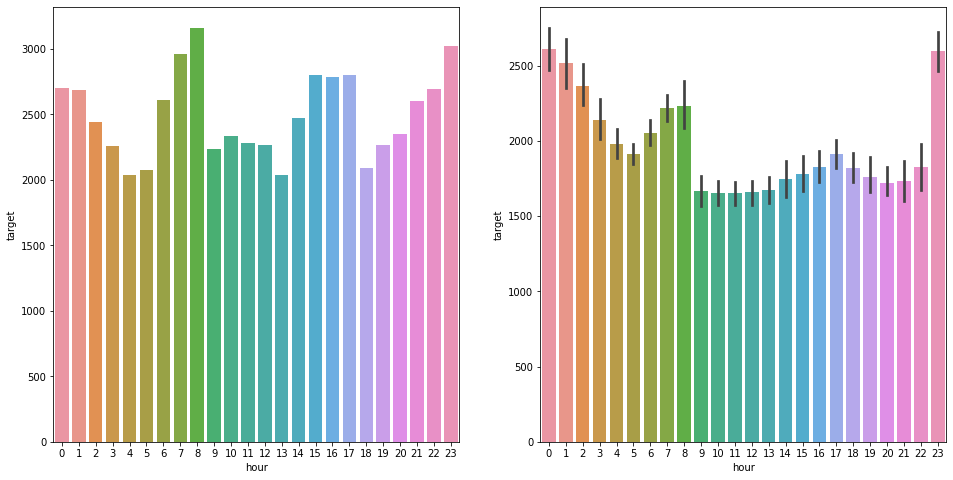

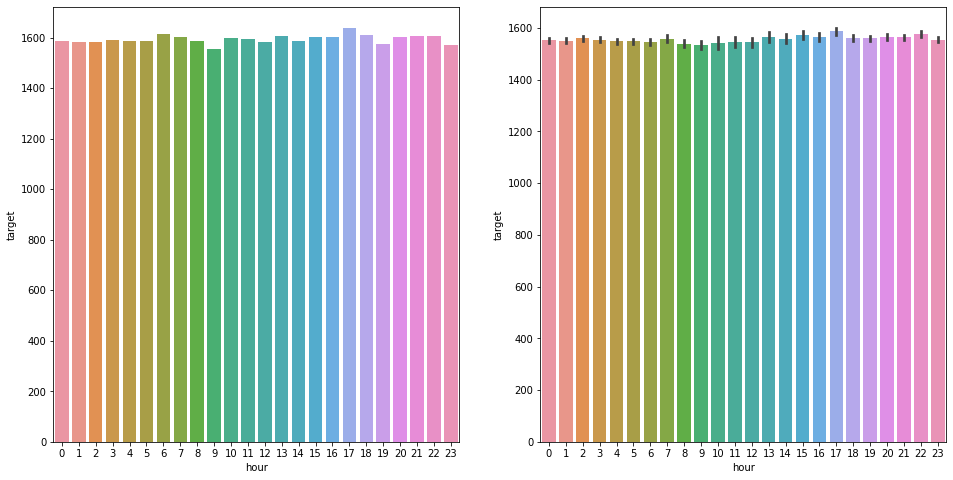

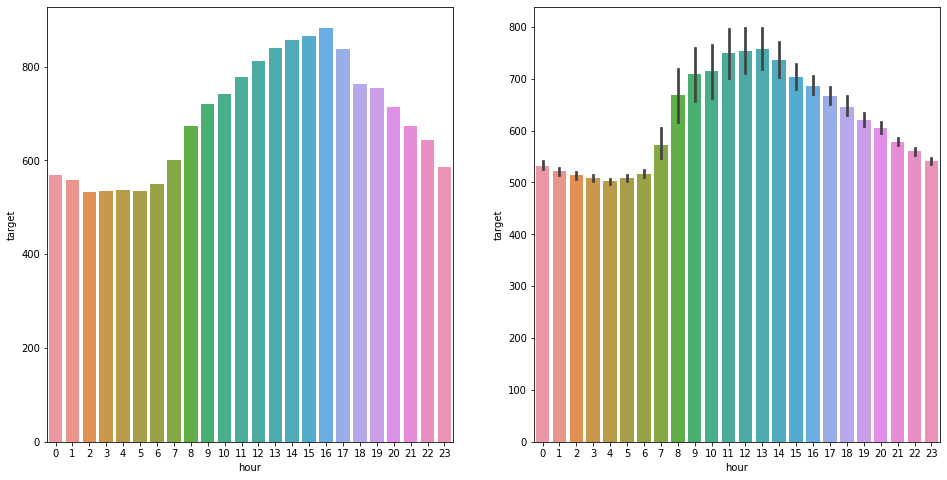

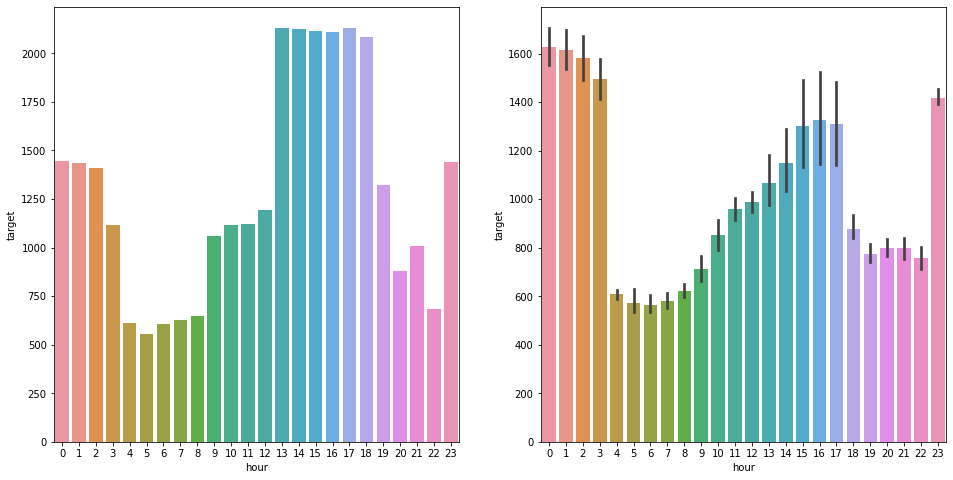

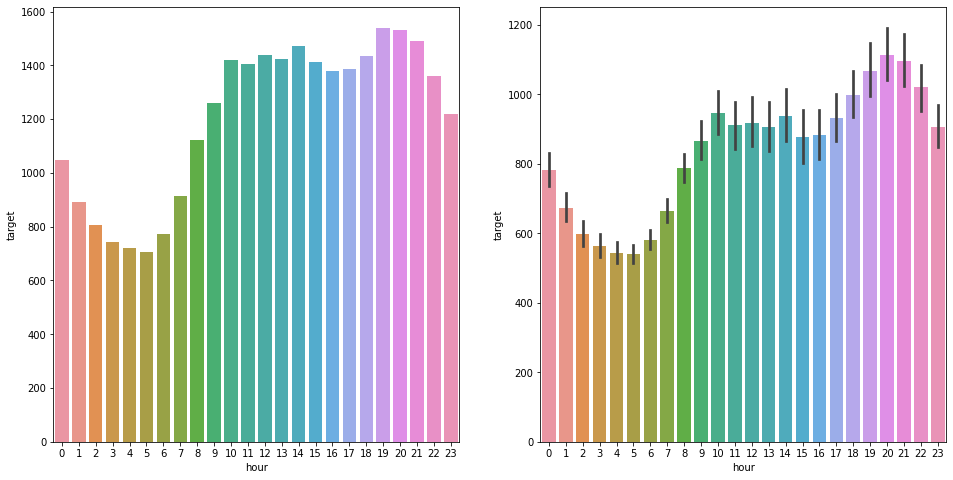

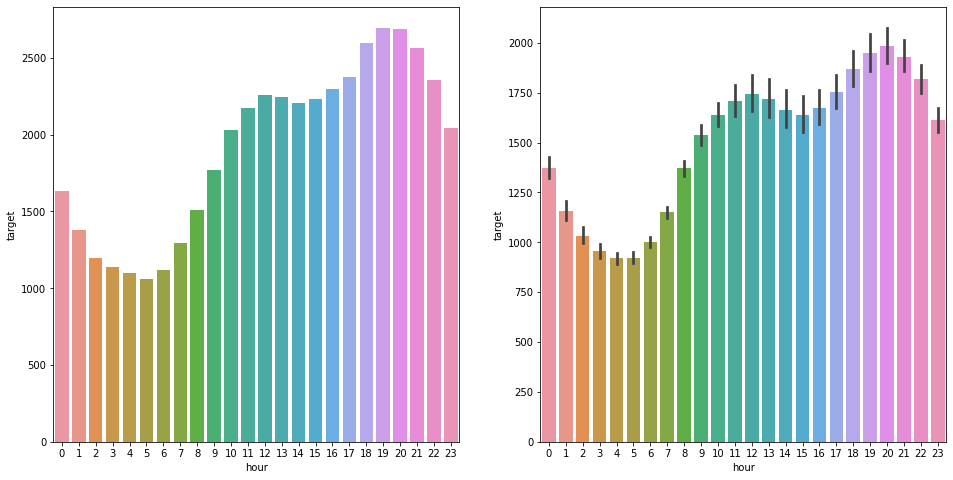

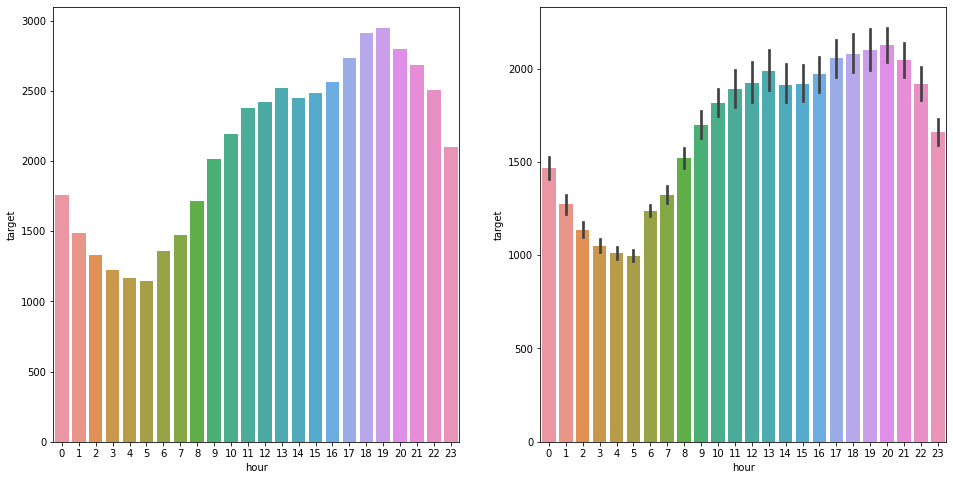

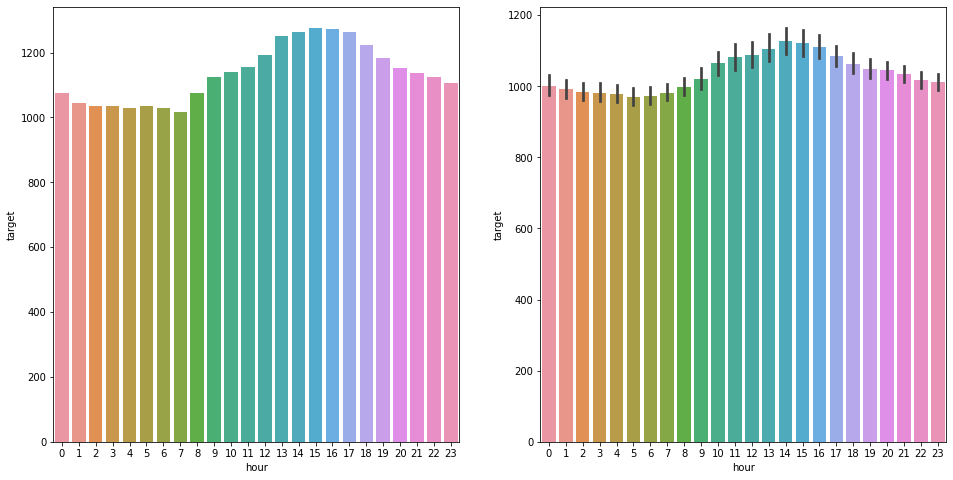

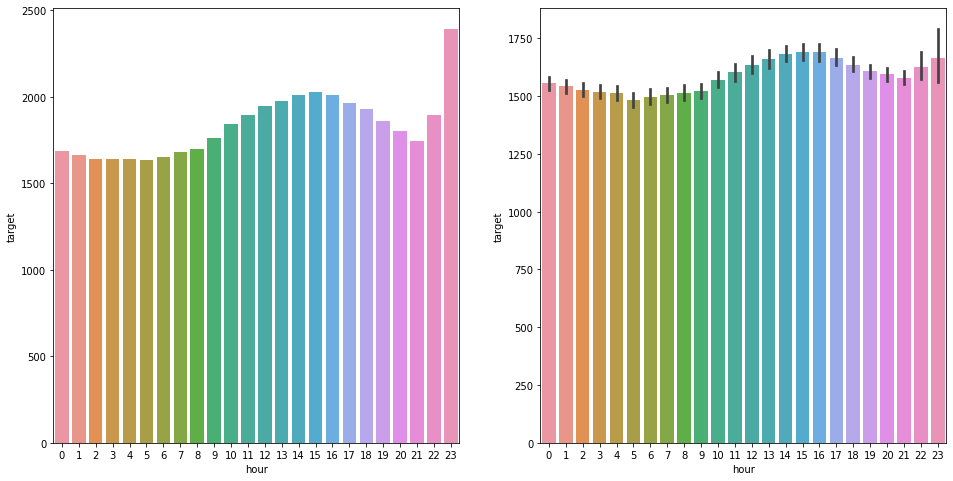

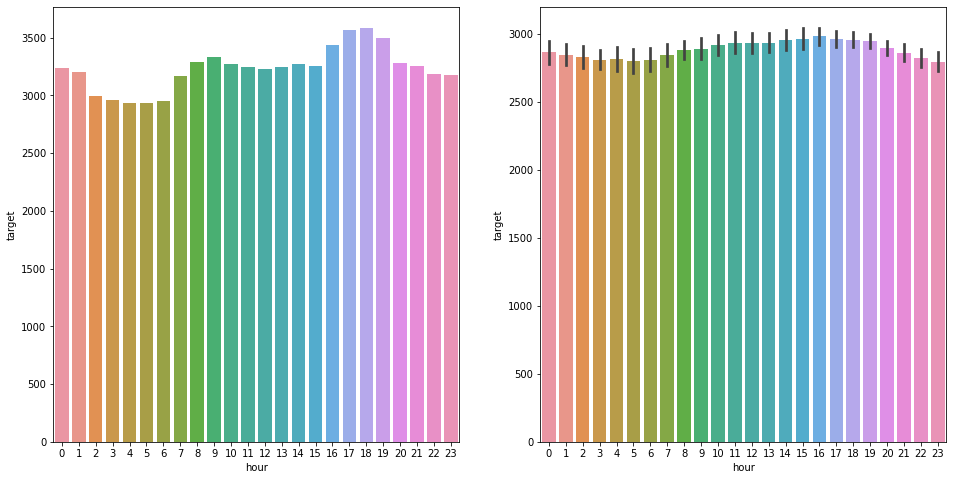

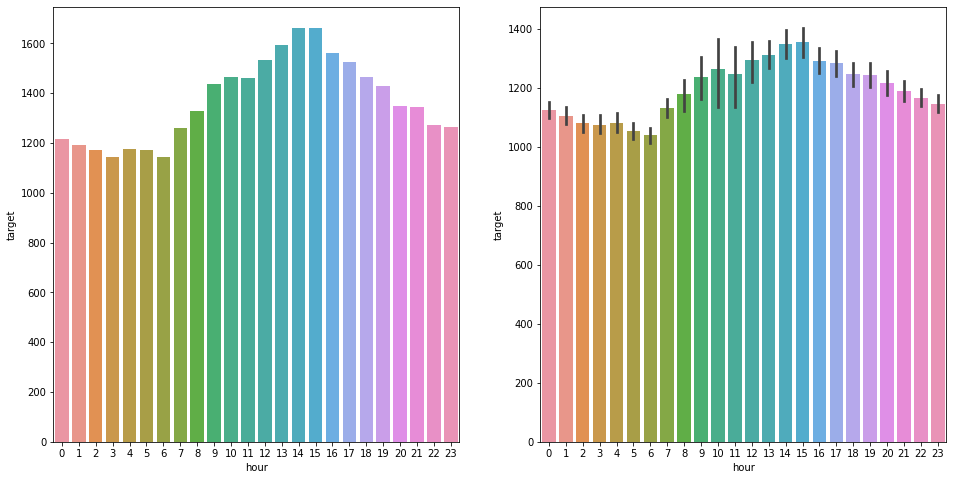

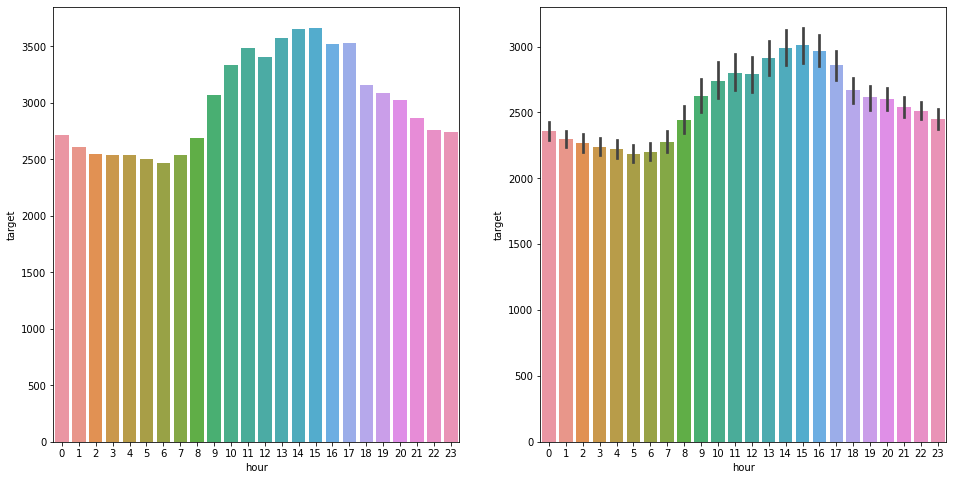

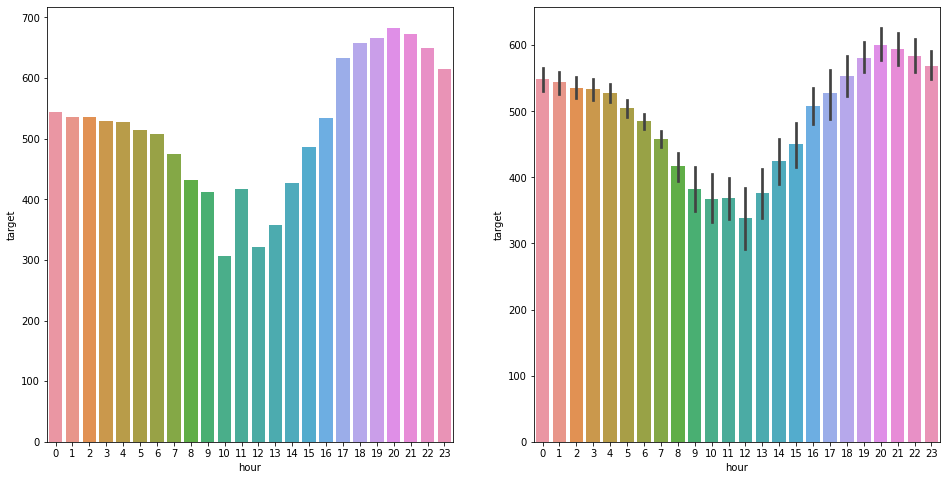

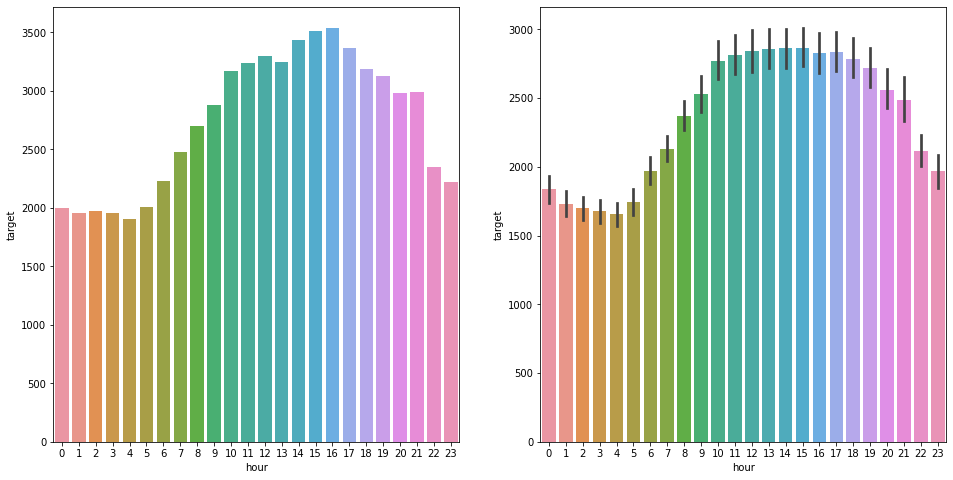

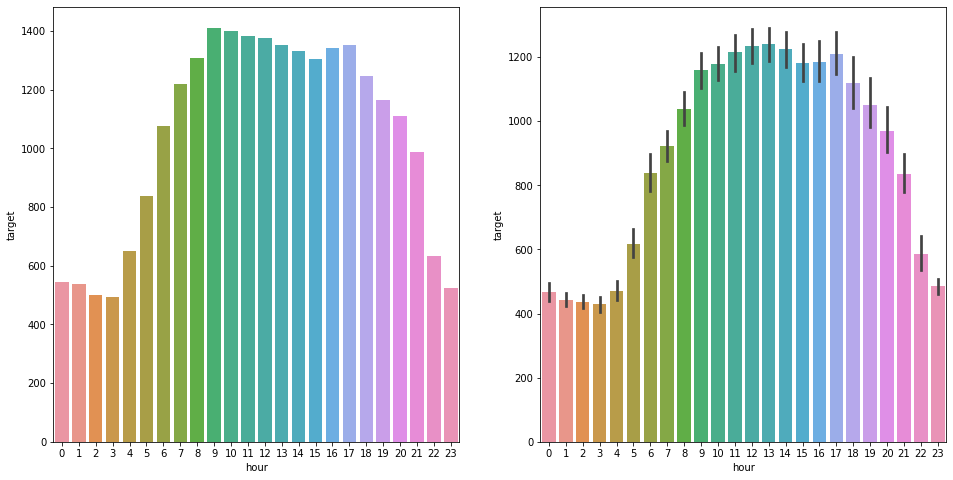

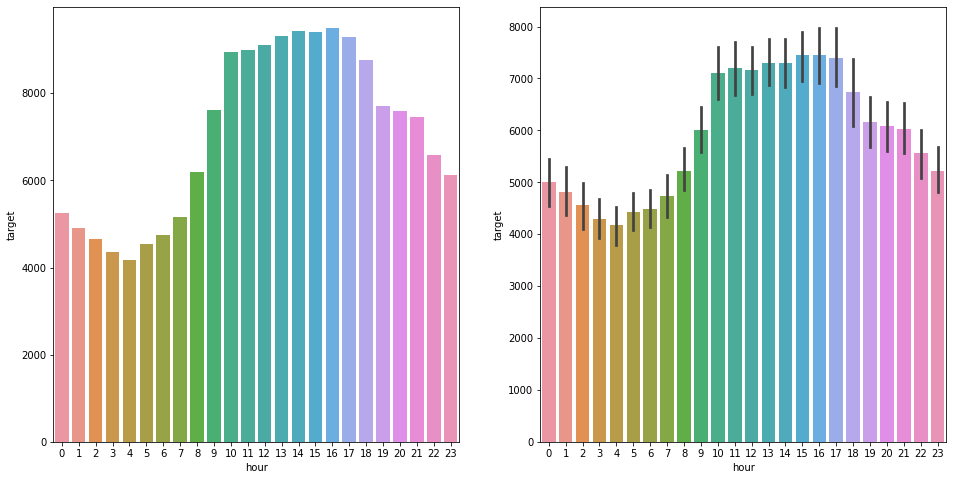

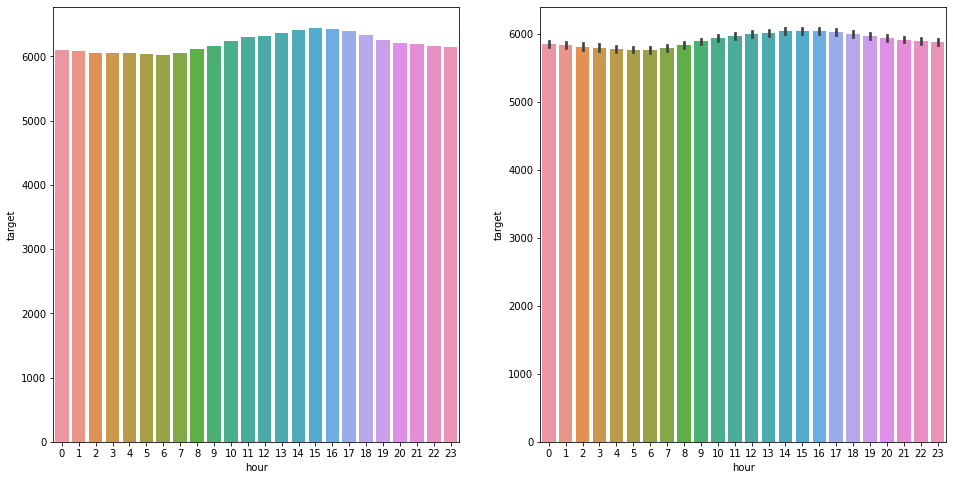

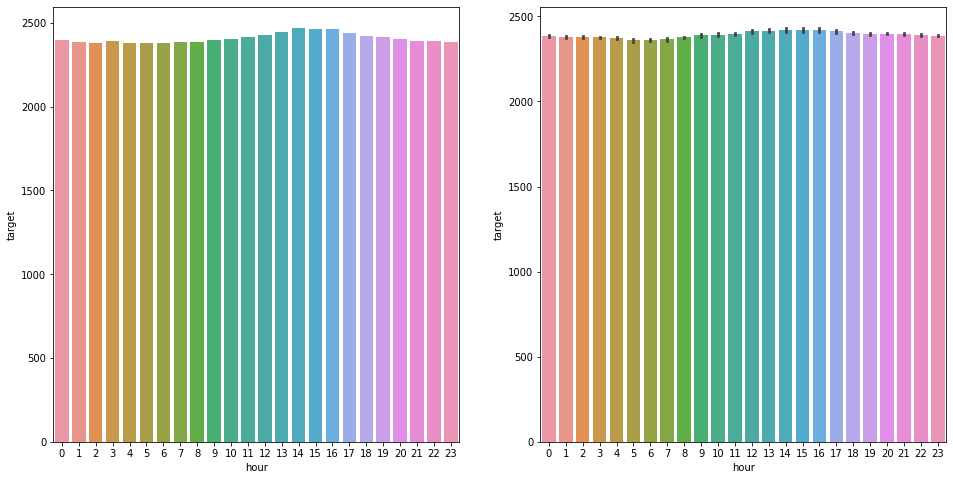

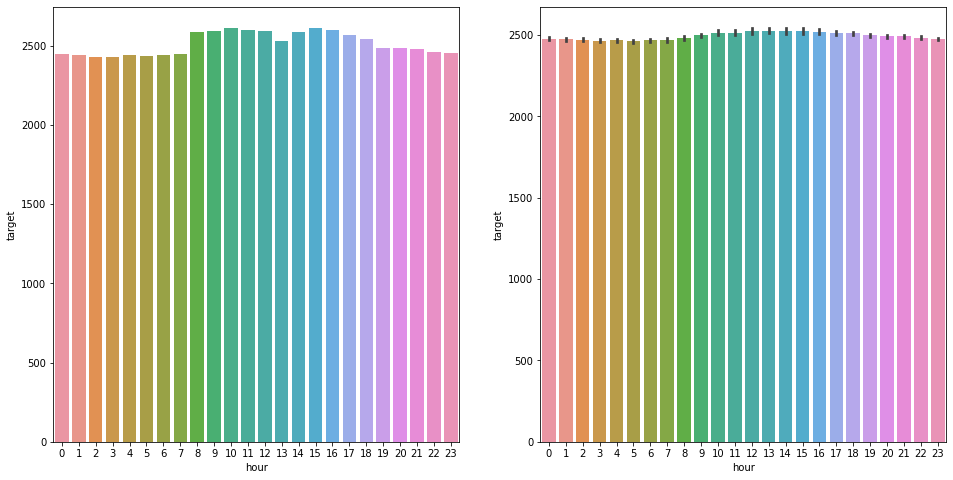

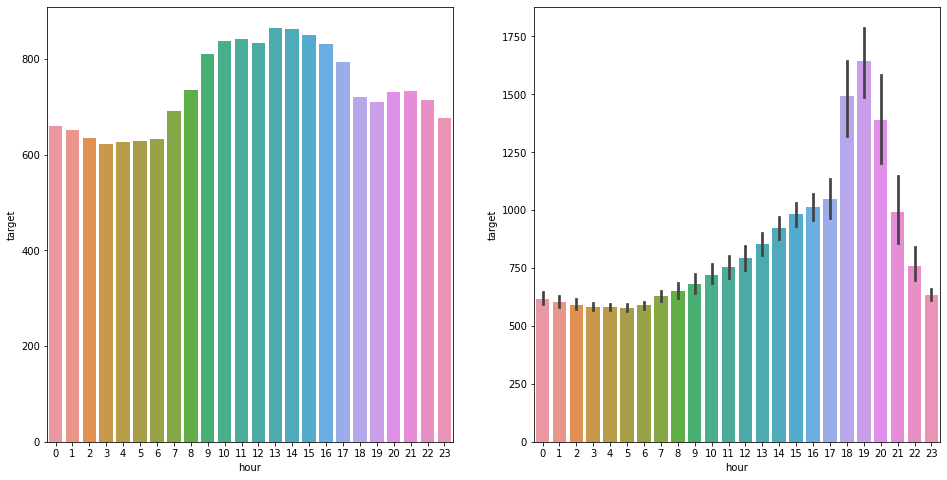

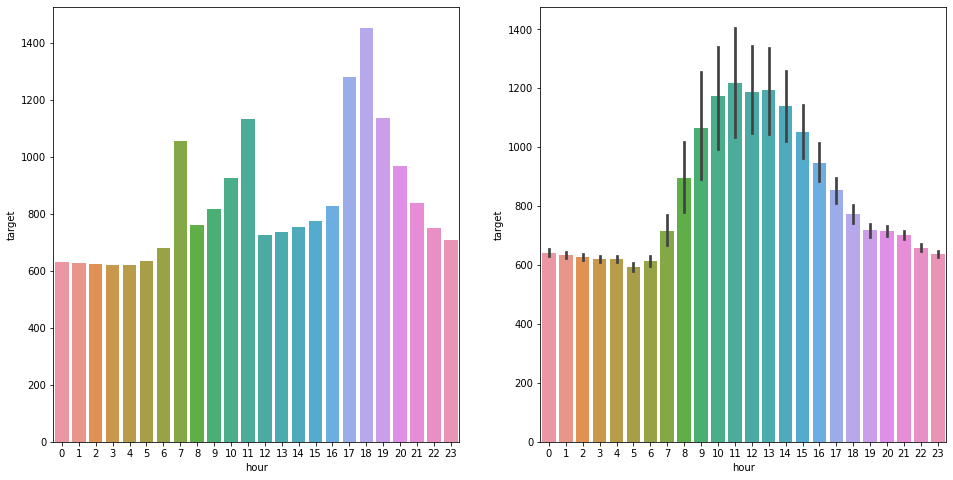

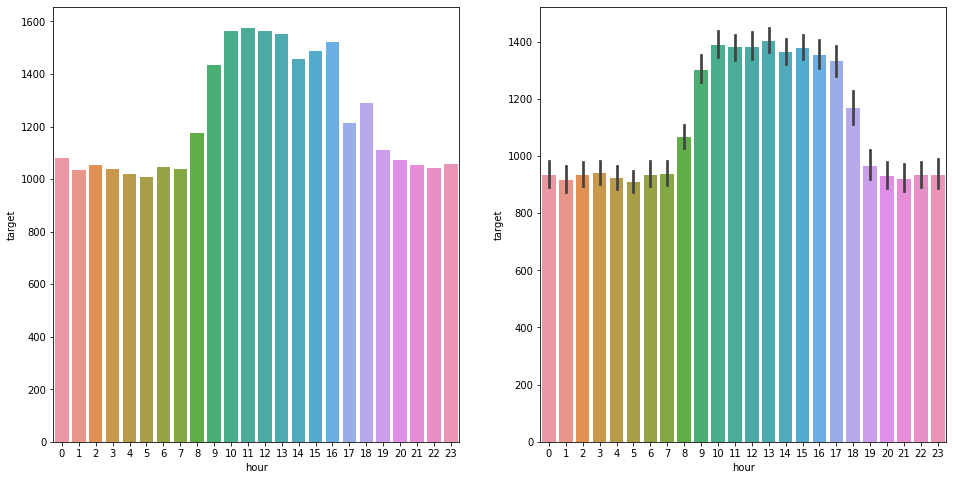

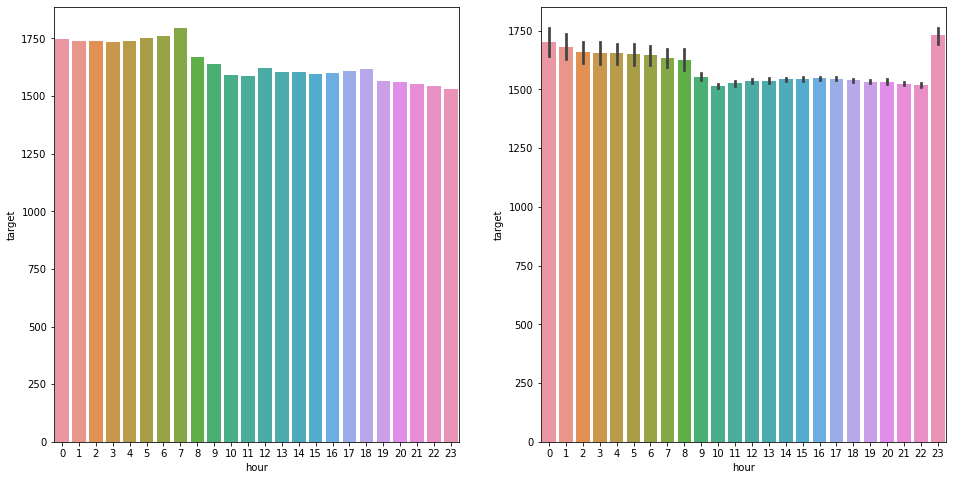

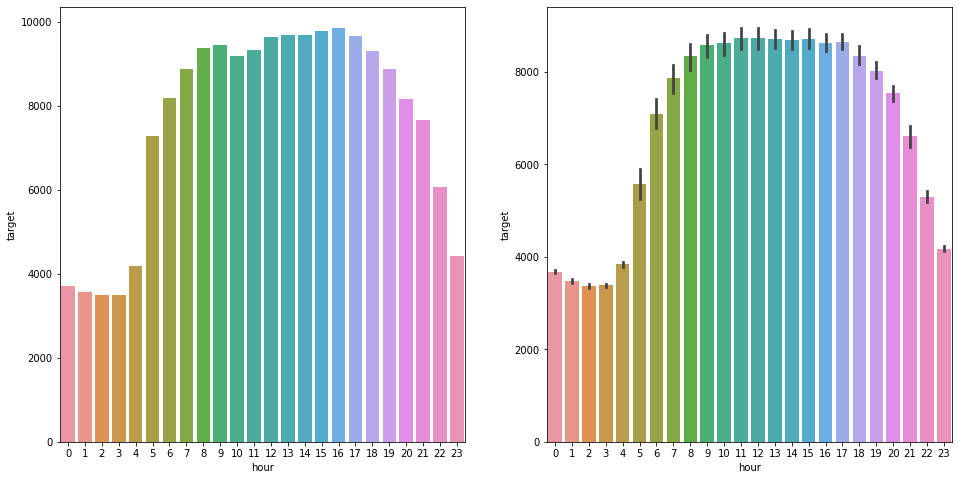

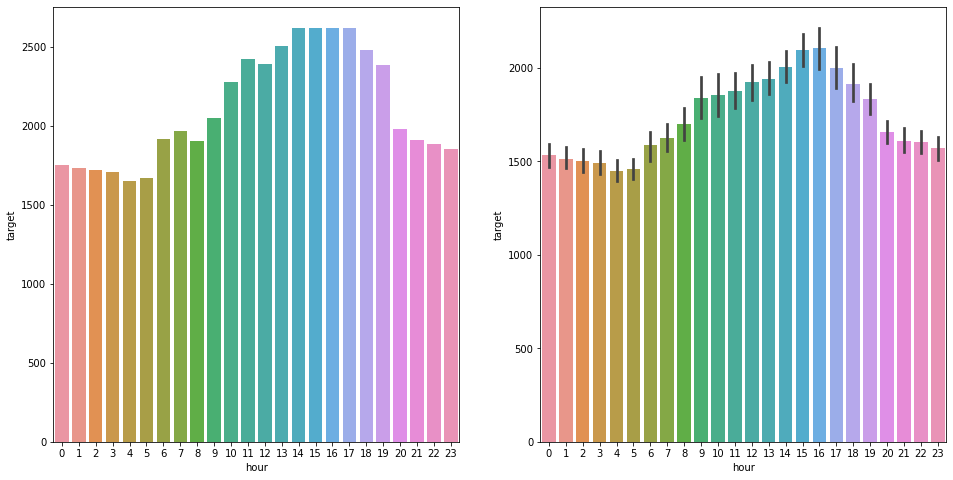

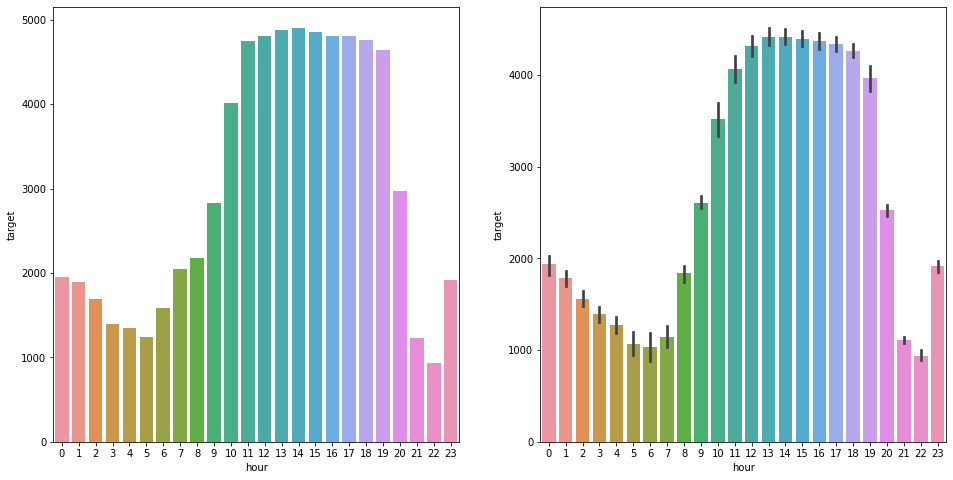

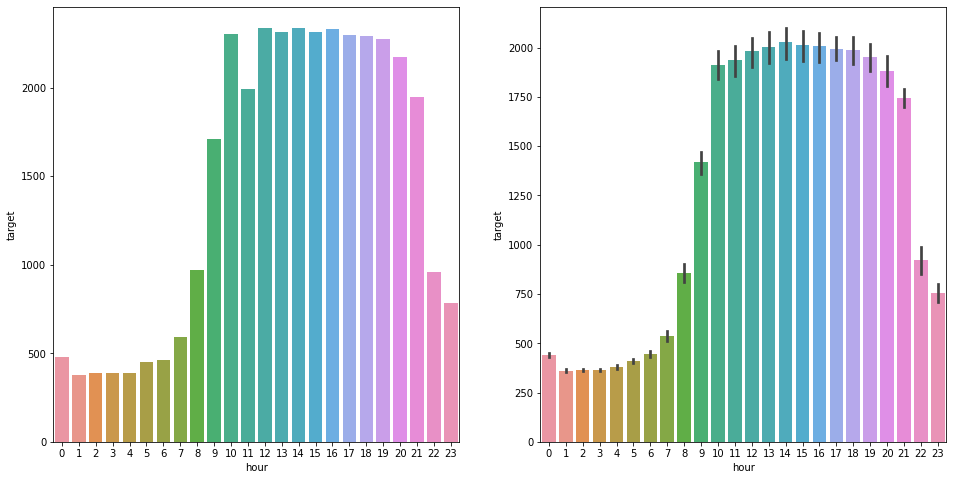

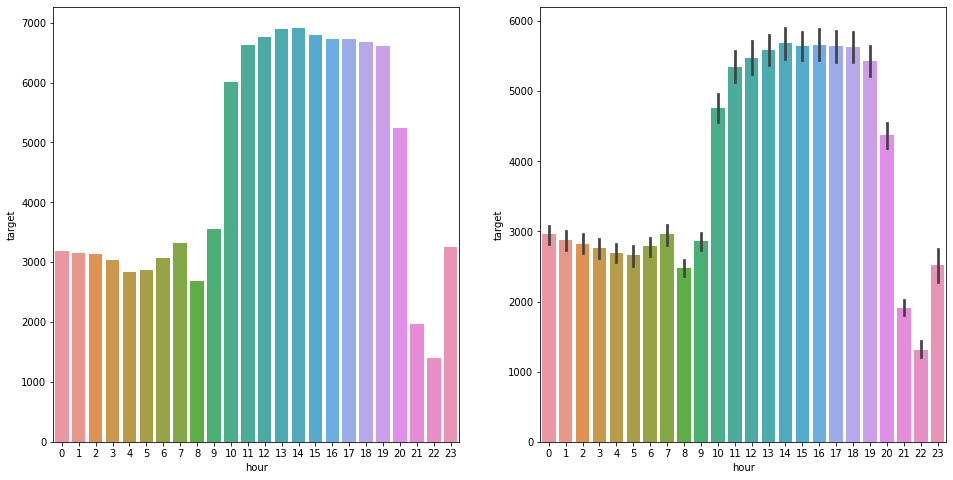

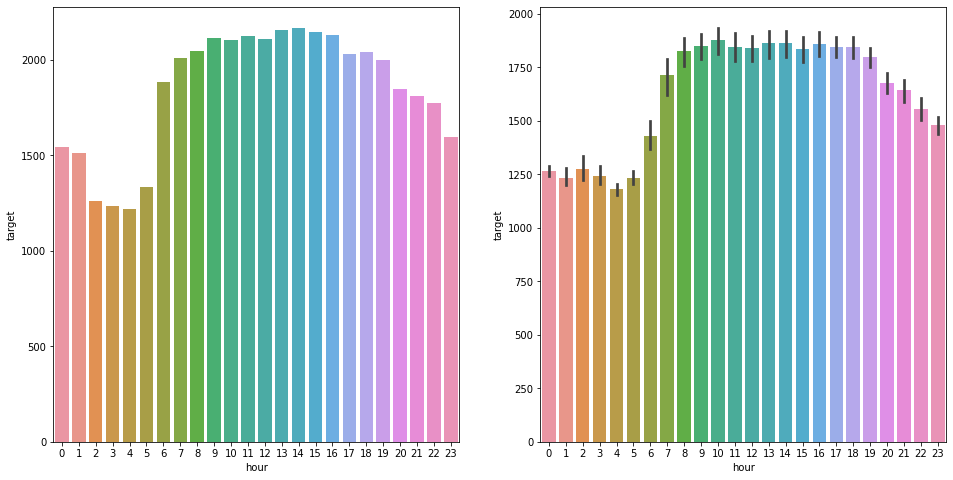

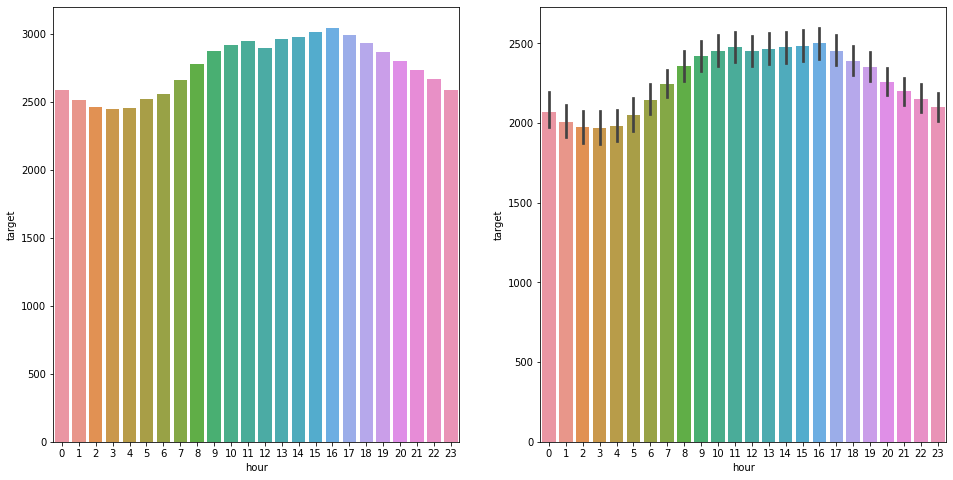

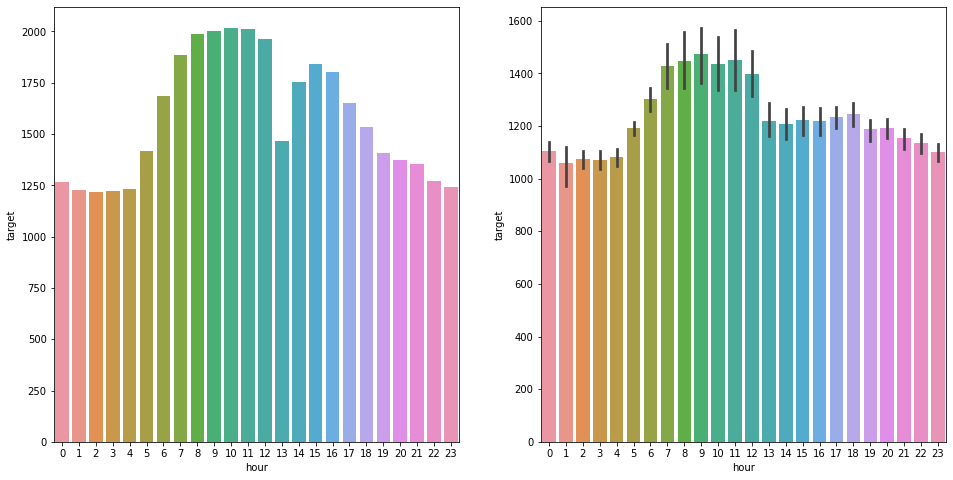

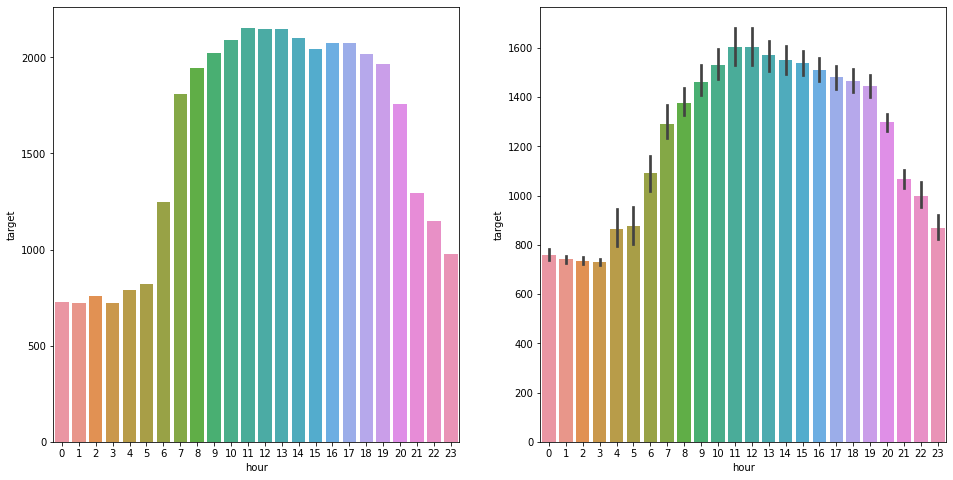

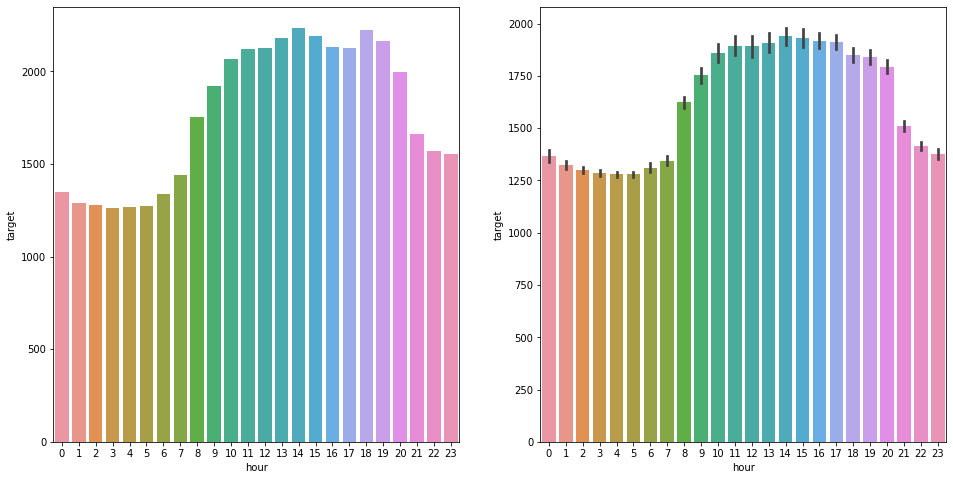

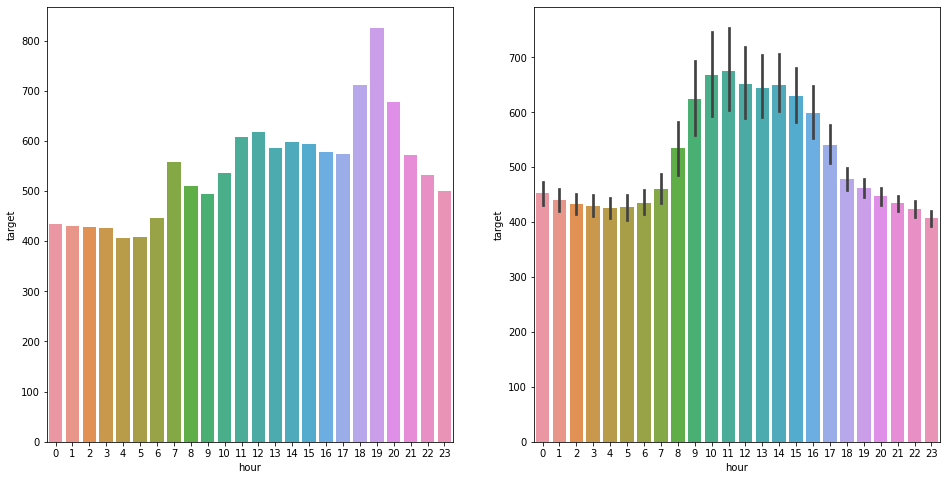

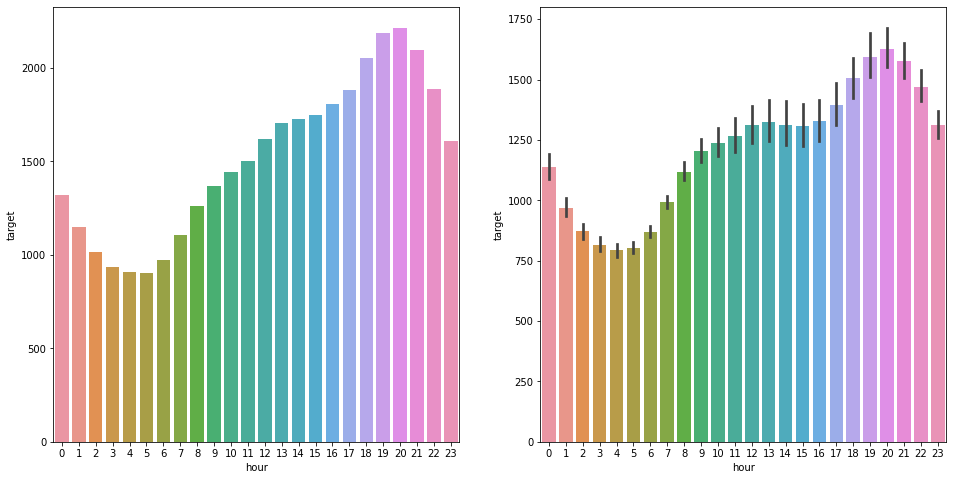

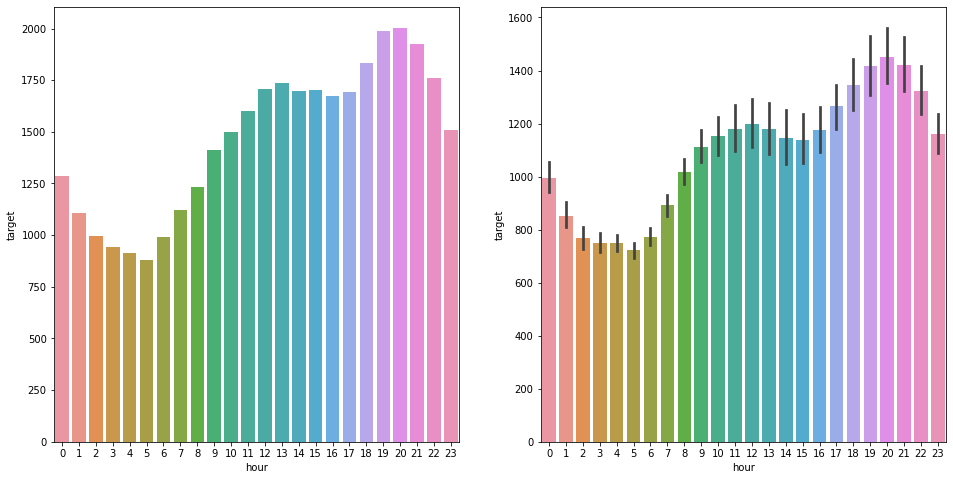

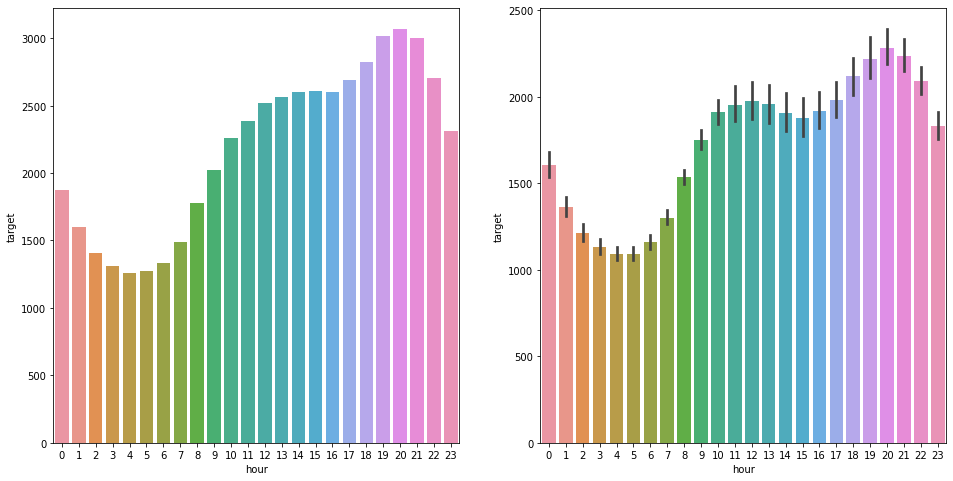

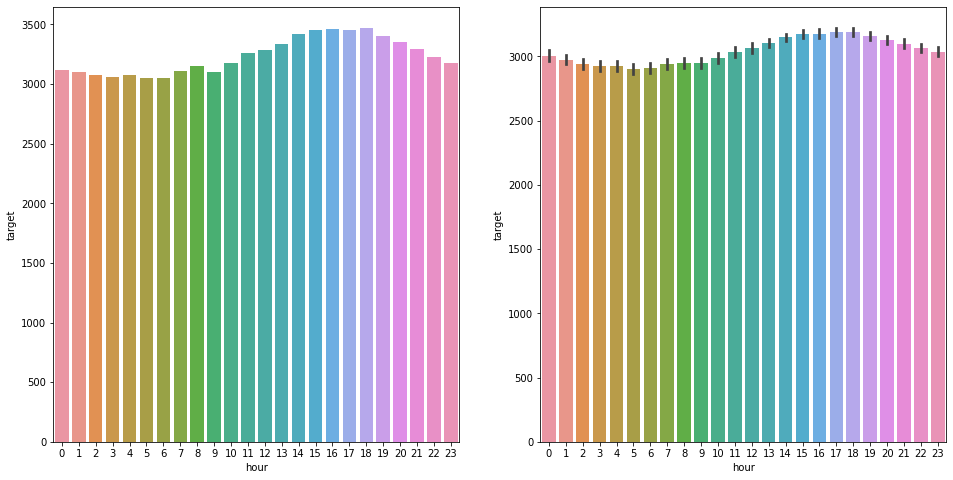

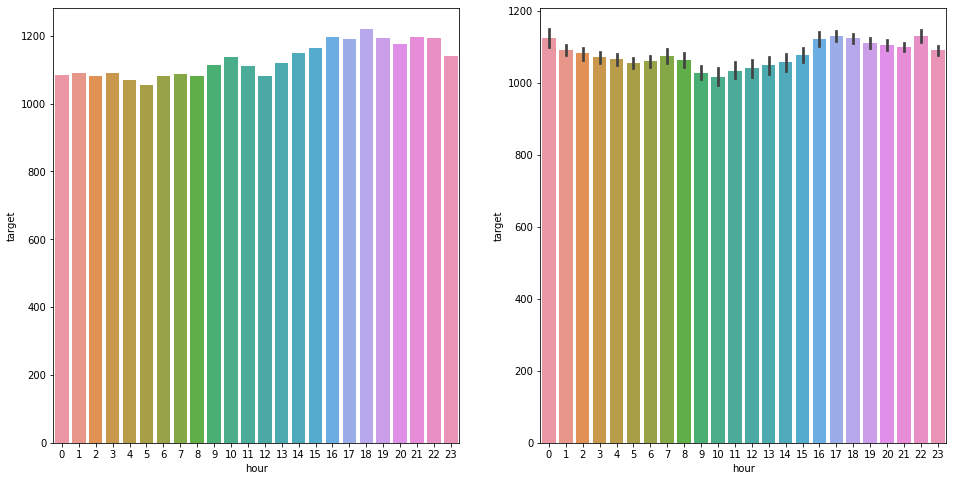

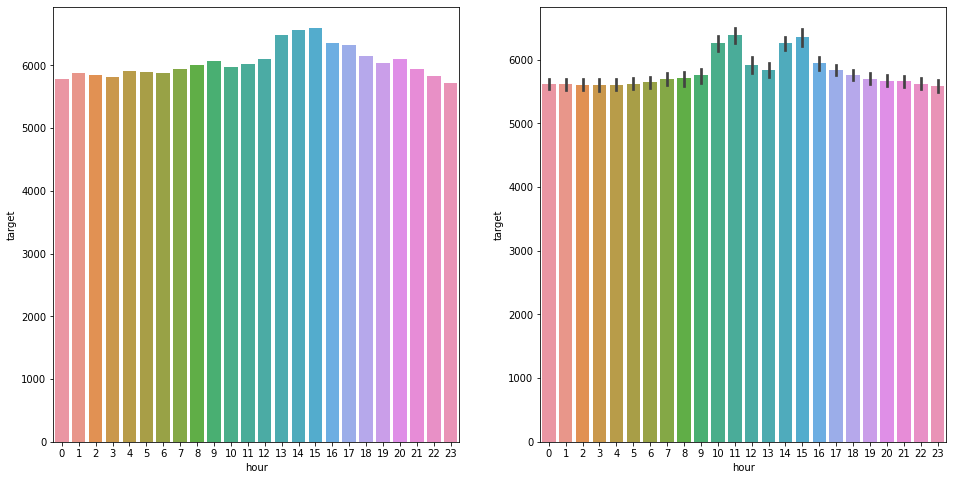

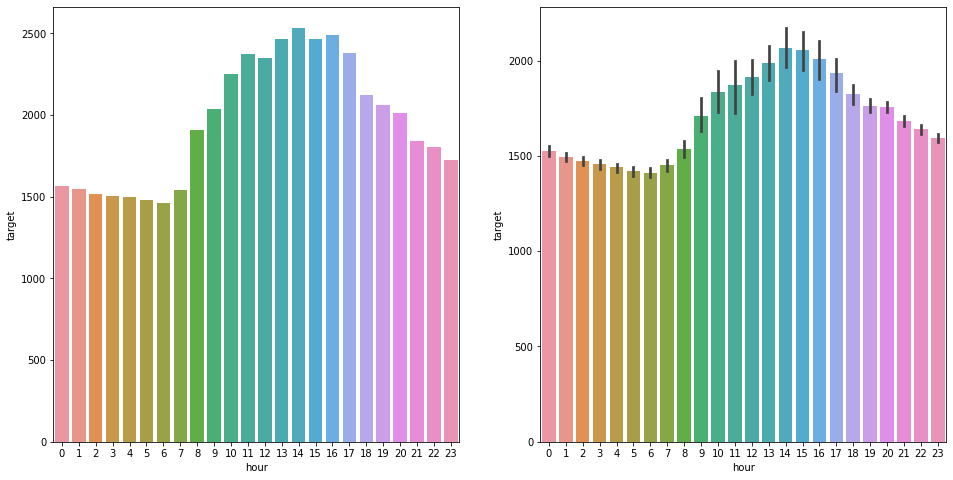

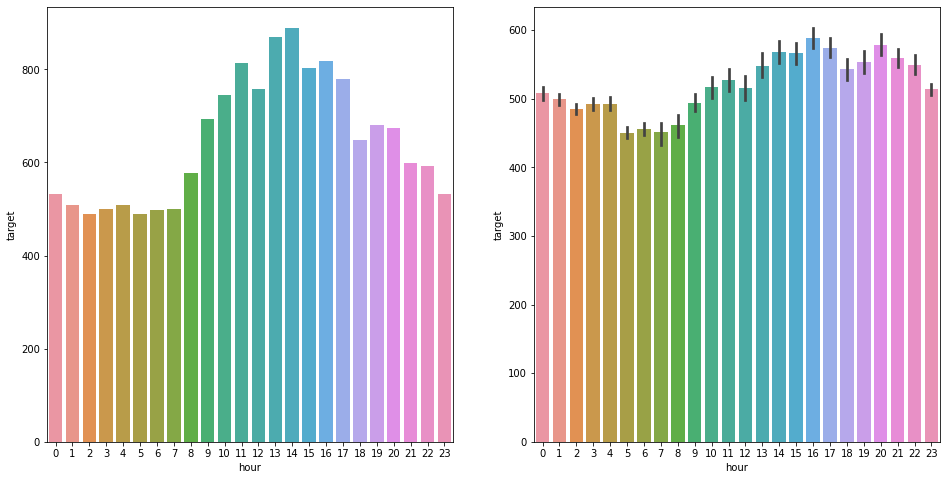

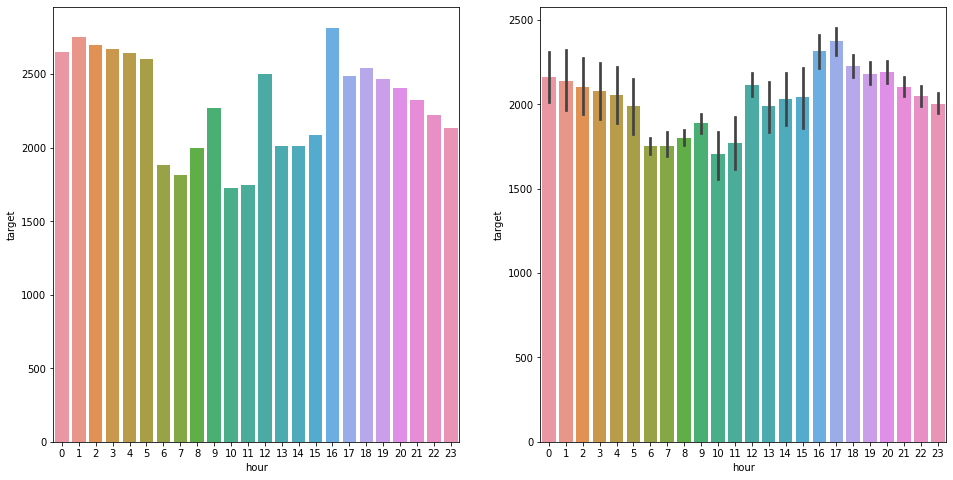

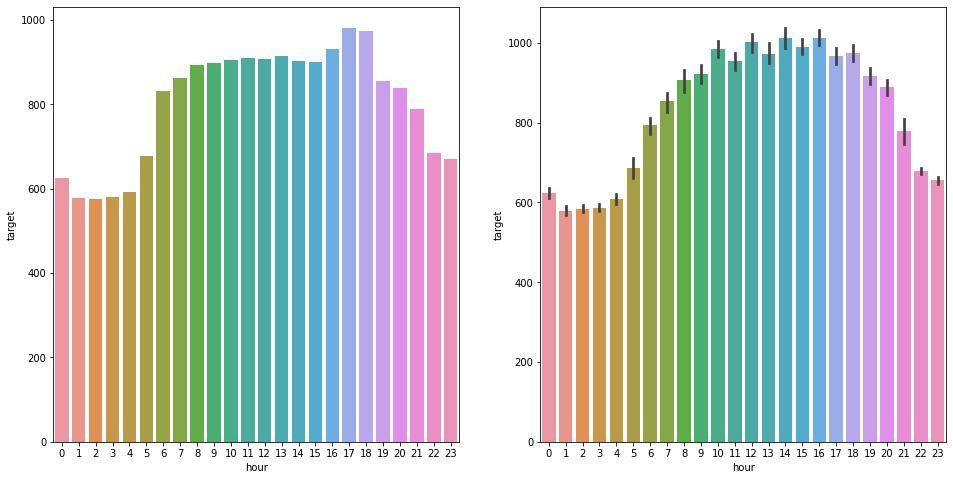

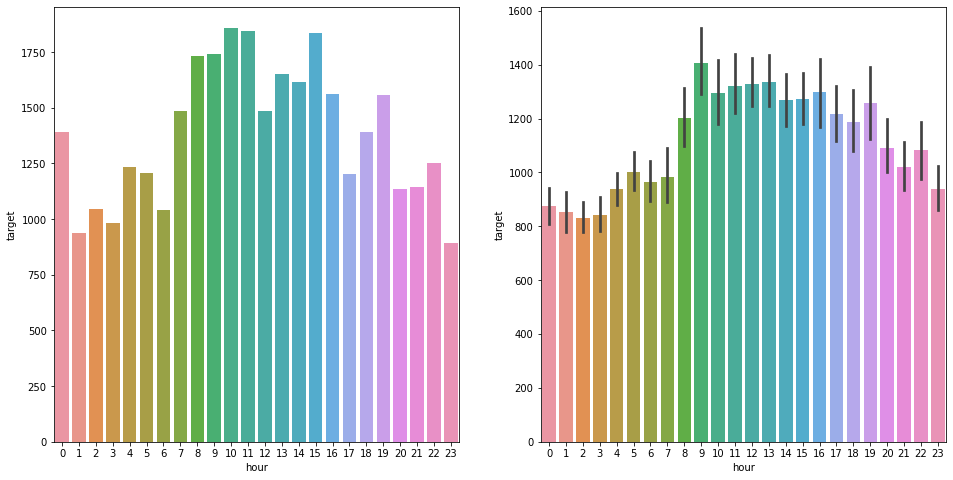

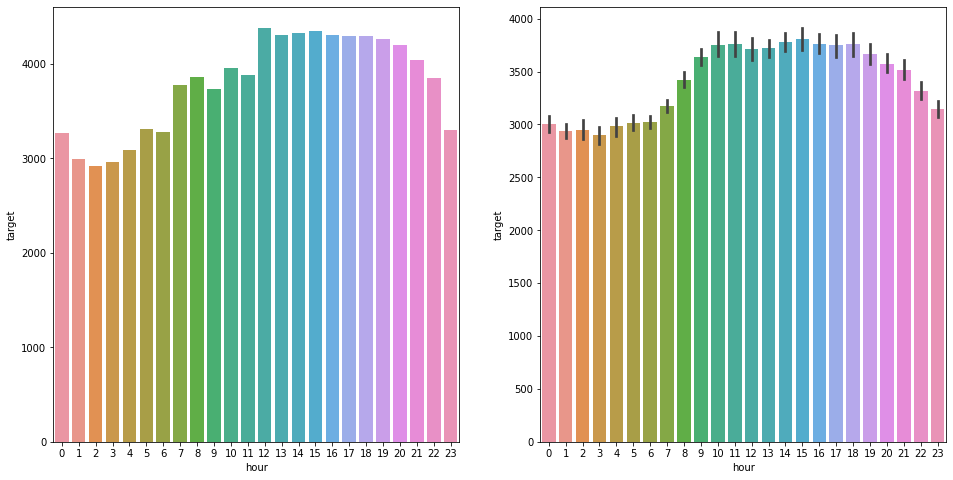

In [57]:
# 그래프를 그리기 위해서 type을 바꿔준다.
train['day'] = train['day'].astype('int')
test['day'] = test['day'].astype('int')
train['month'] = train['month'].astype('int')
test['month'] = test['month'].astype('int')
train['hour'] = train['hour'].astype('int')
test['hour'] = test['hour'].astype('int')

# 8월17일 임시공휴일
# 현충일은 대체공휴일이 지정되지 않아서 따로 바꿔주지 않는다.
for i in train['num'].unique():
  fig, ax = plt.subplots(ncols = 2, figsize =(16,8))
  sns.barplot(data = train[(train['num'] == i)&(train['month'] == 8)&(train['day'] == 17)], x = 'hour', y = 'target', ax = ax[0])
  sns.barplot(data = train[(train['num'] == i)&(train['weekday'] == 1)], x = 'hour', y = 'target', ax = ax[1])
  ax[0].set_title(f'{i}번 건물의 대체공휴일')
  ax[1].set_title('건물의 주말 분포')
  plt.show()

# 분포가 주말과 유사하므로 8월 17일을 주말로 바꿔준다.
train.loc[(train['month'] == '08') & (train['day'] == '17'),'weekday'] = 1
# print(train[(train['month'] == '08') & (train['day'] == '17')]['weekday'])

In [58]:
# 열감비율을 구하고 데이터를 넣어줬을 때 Temperatures보다 안나오기 때문에 제거한다.
# 열감비율 구하기
# train['ET'] = train['Temperatures'] - (0.4 * train['Temperatures']) -10*(1-(train['Humidity']/100))
# test['ET'] = test['Temperatures'] - (0.4 * test['Temperatures']) -10*(1-(test['Humidity']/100))

# for i in train['num'].unique():
#   sns.scatterplot(data = train[train['num'] == i], x = '열감비율', y = 'target', hue = 'weekday')
#   plt.title(f'{i}')
#   plt.show()

# train_corr = train.corr()
# sns.heatmap(train_corr, annot = True)

## 모델링

In [ ]:
!pip install catboost

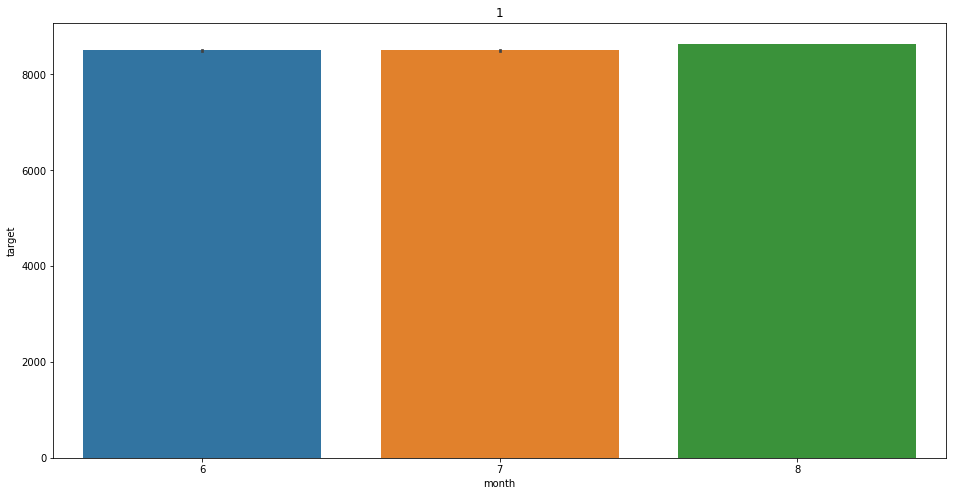

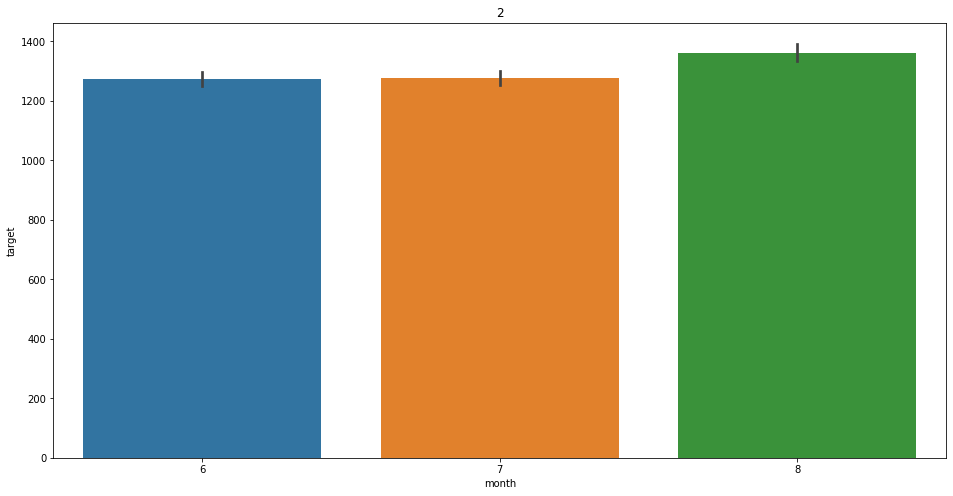

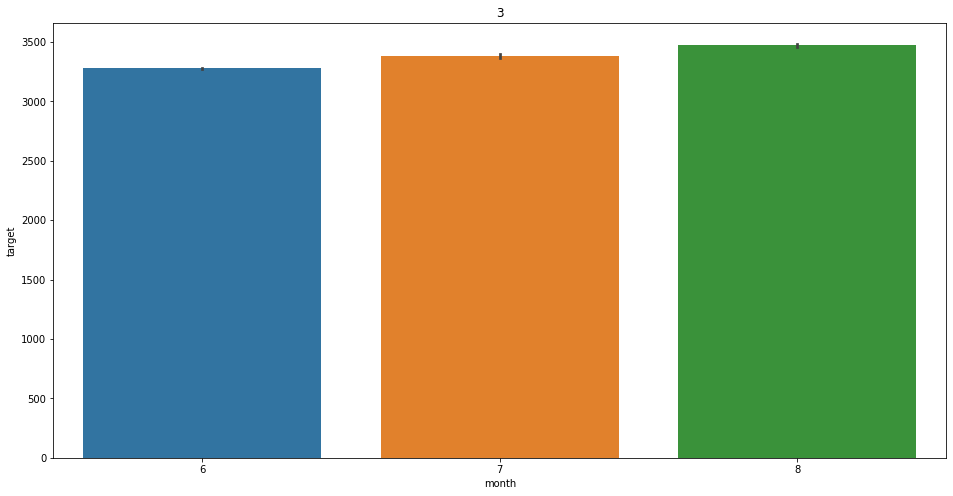

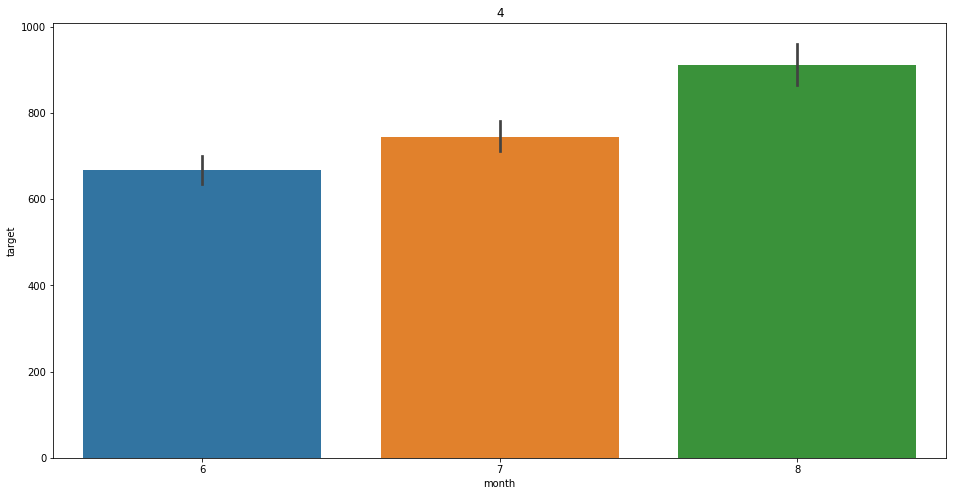

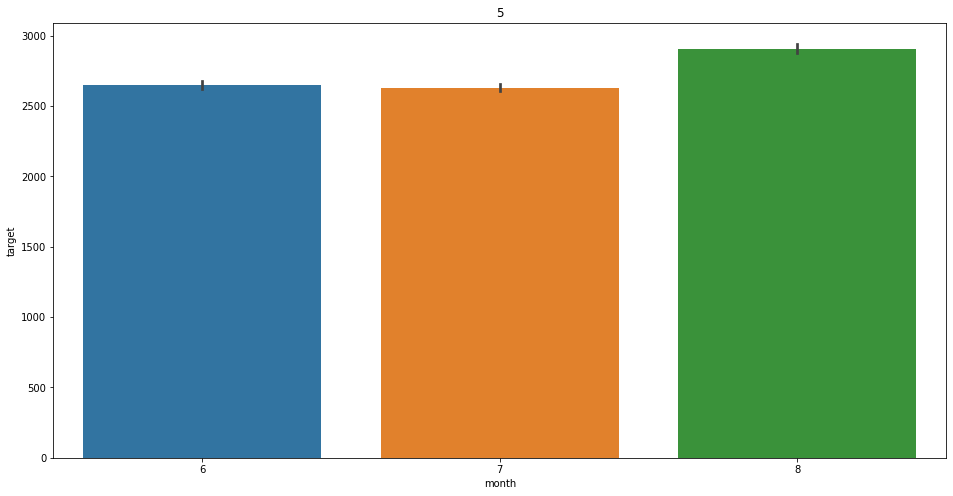

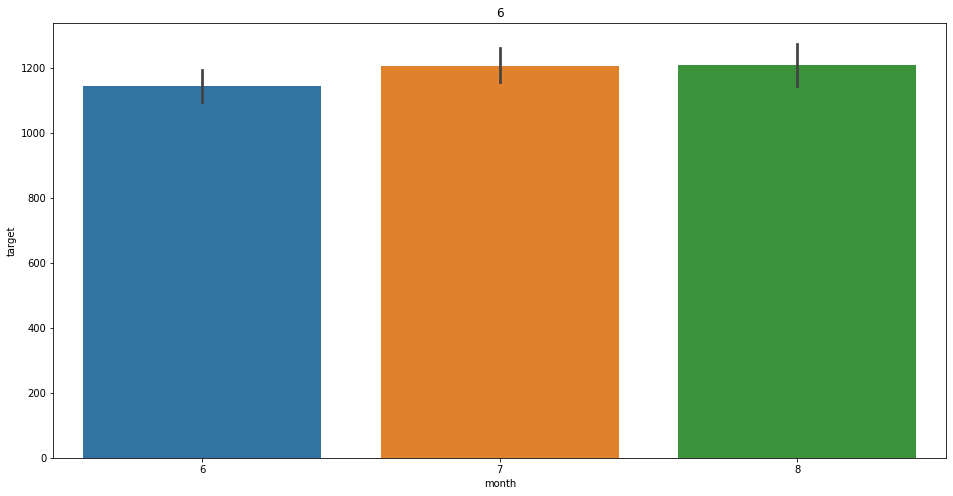

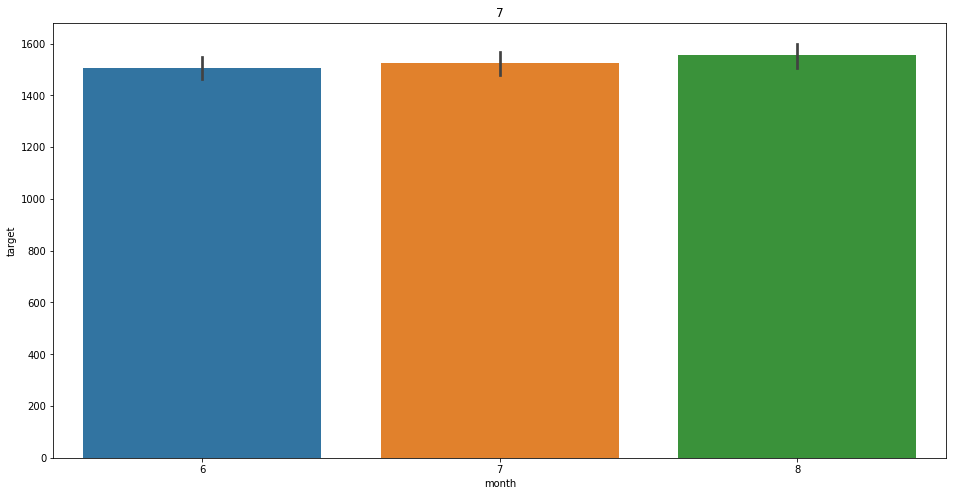

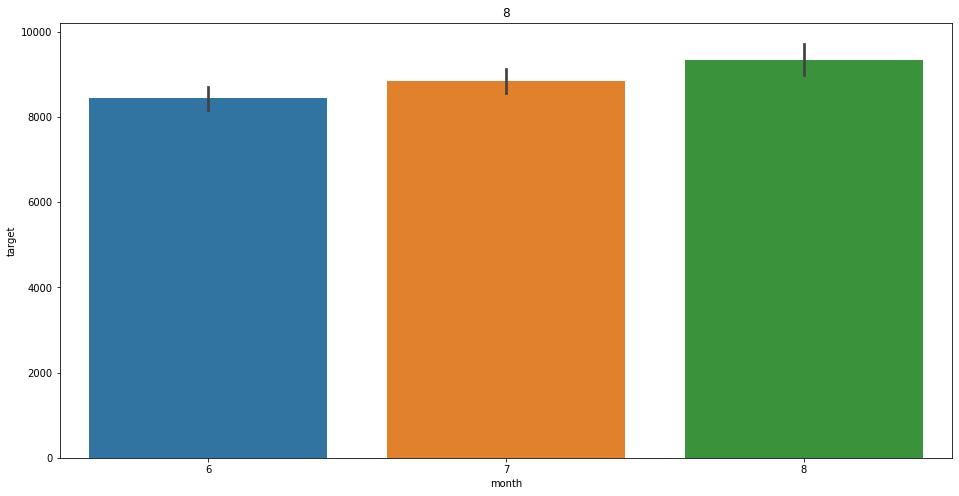

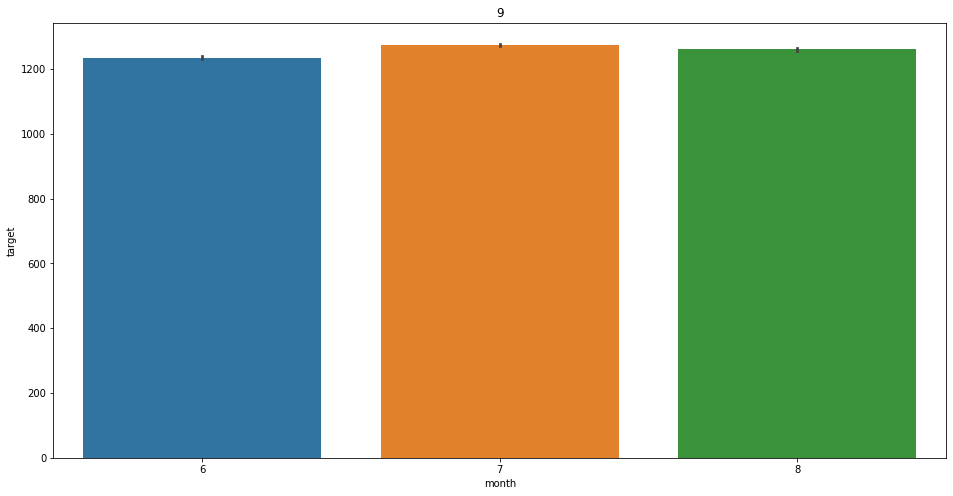

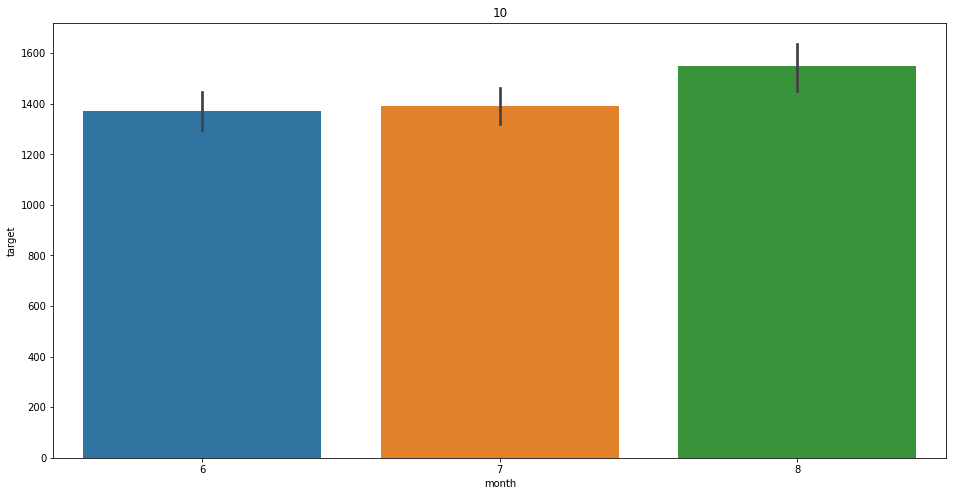

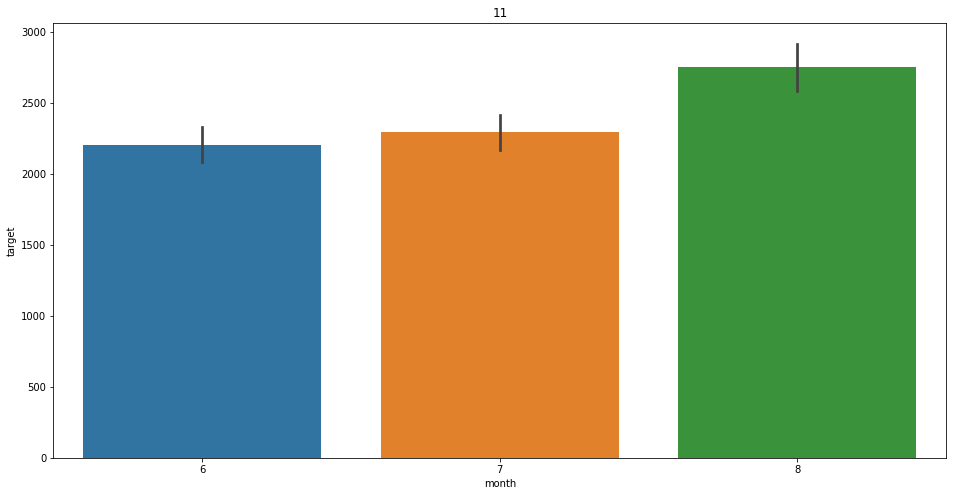

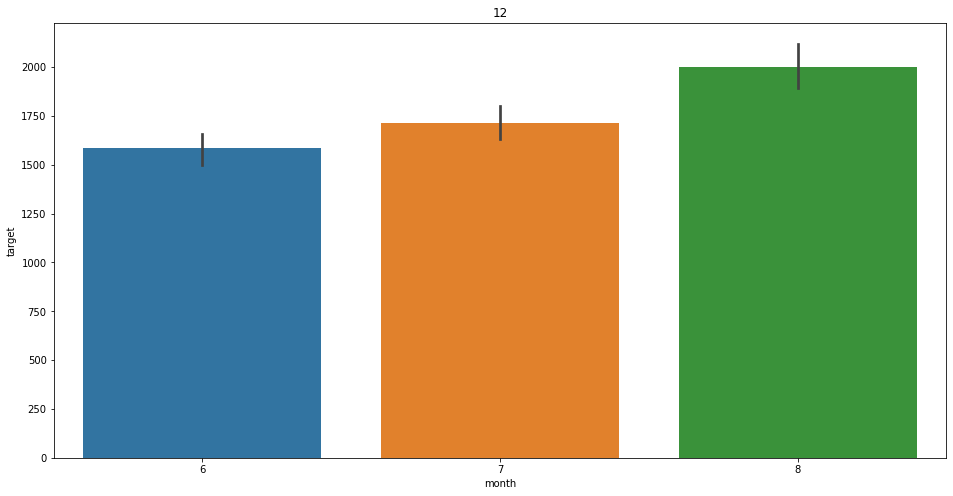

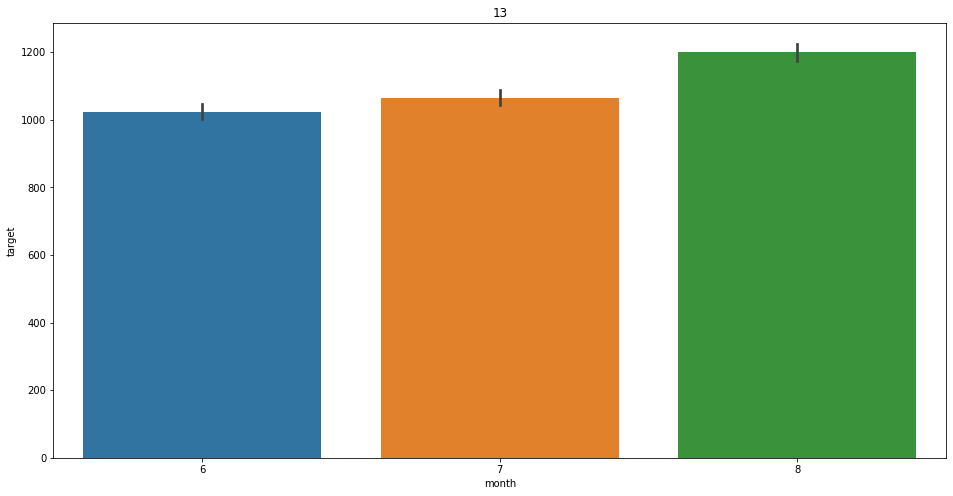

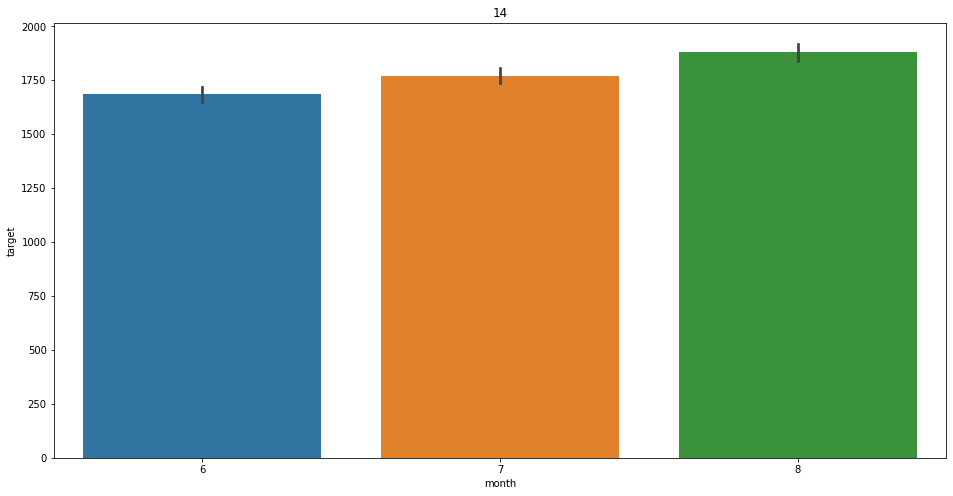

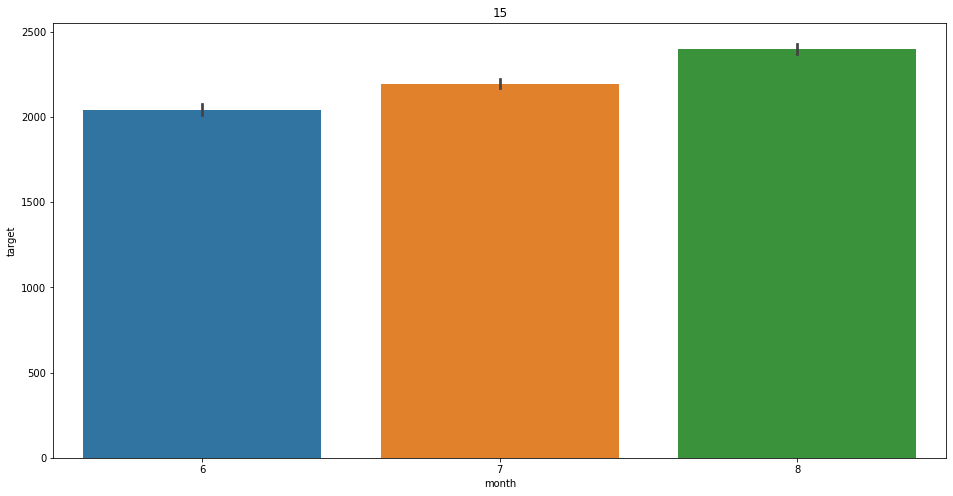

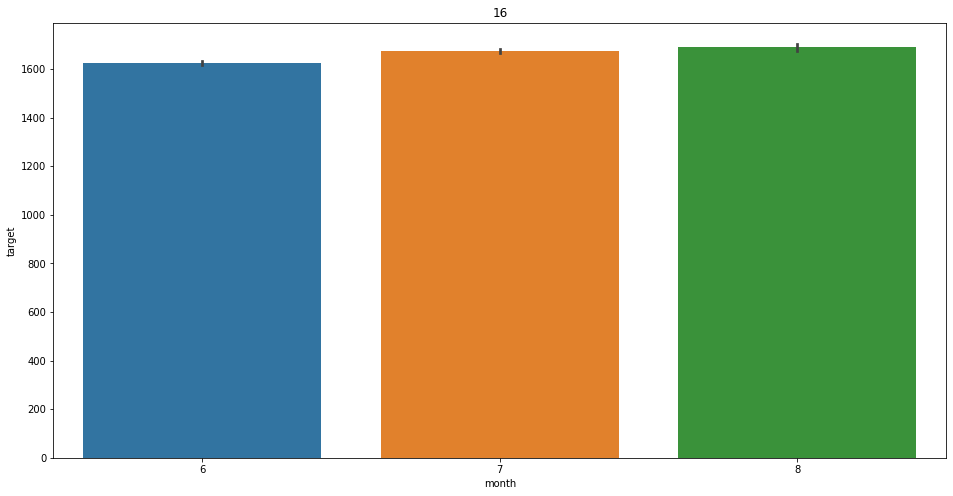

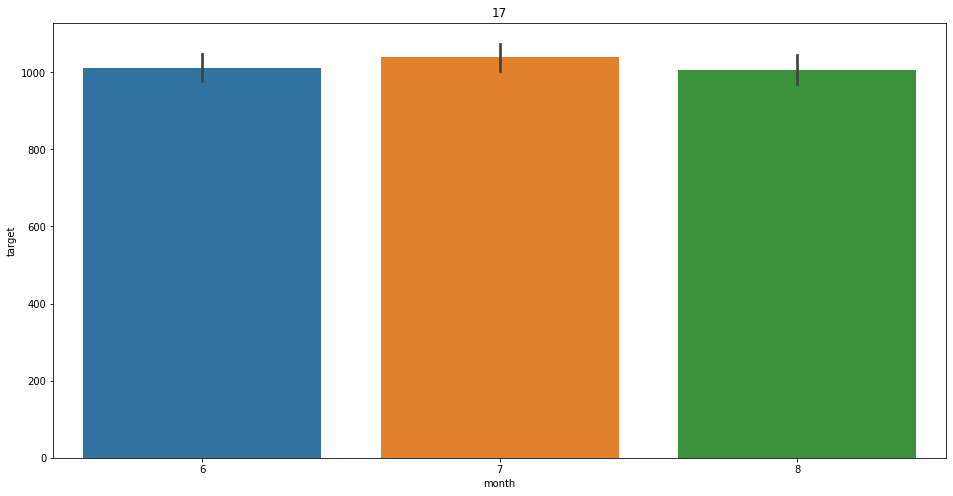

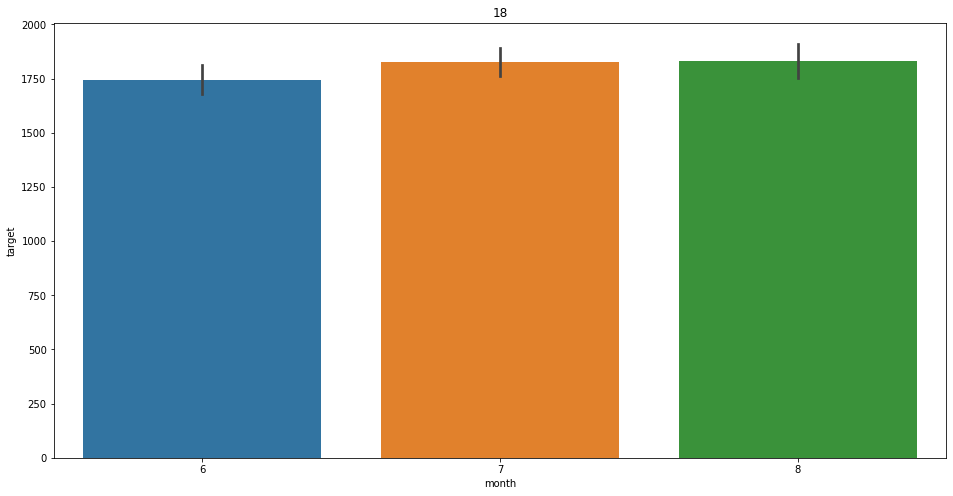

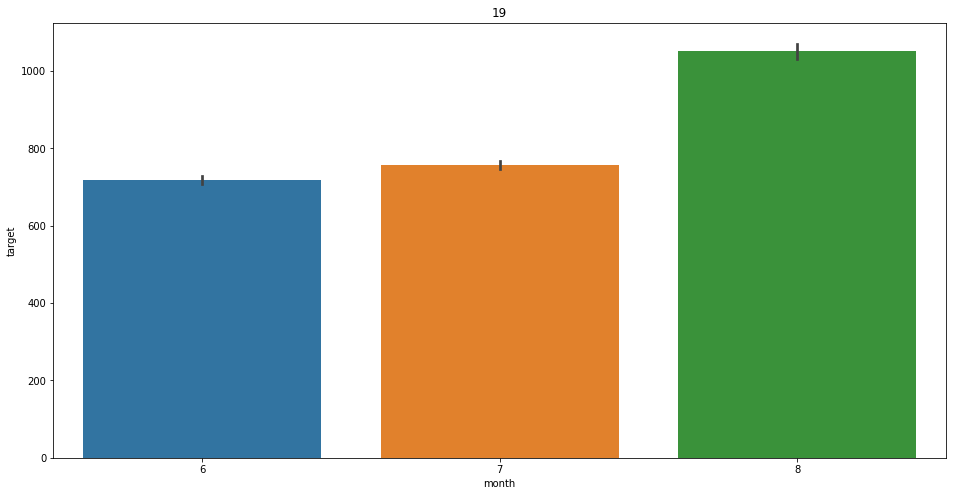

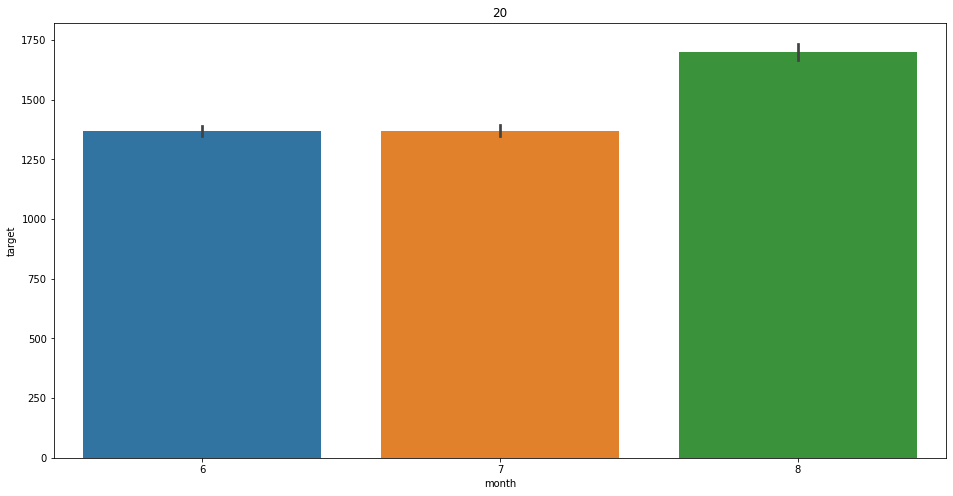

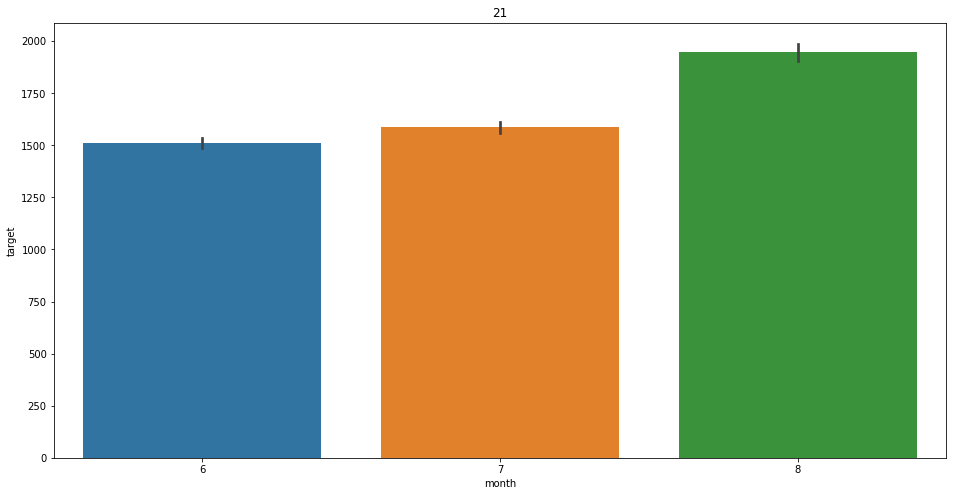

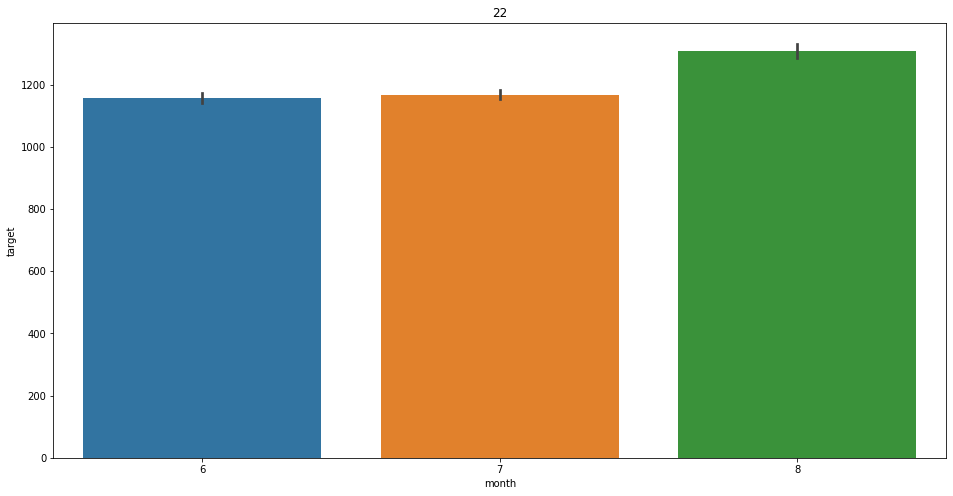

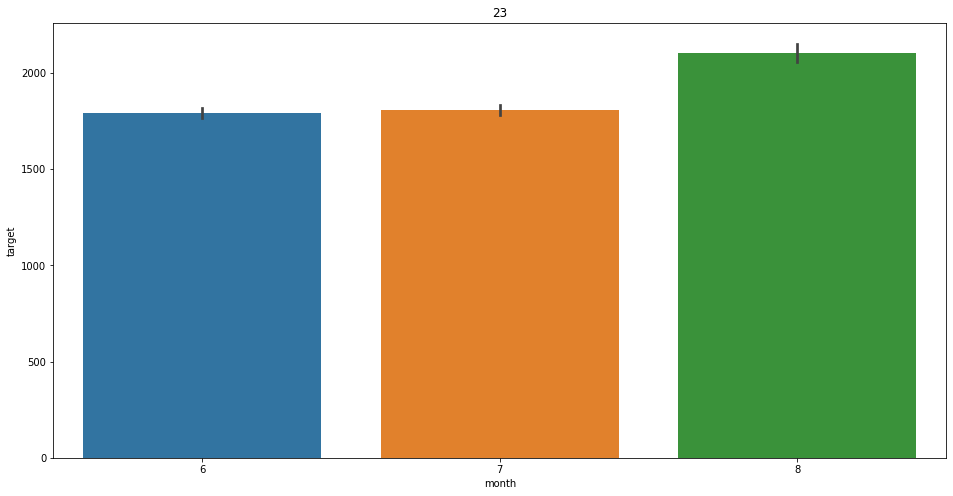

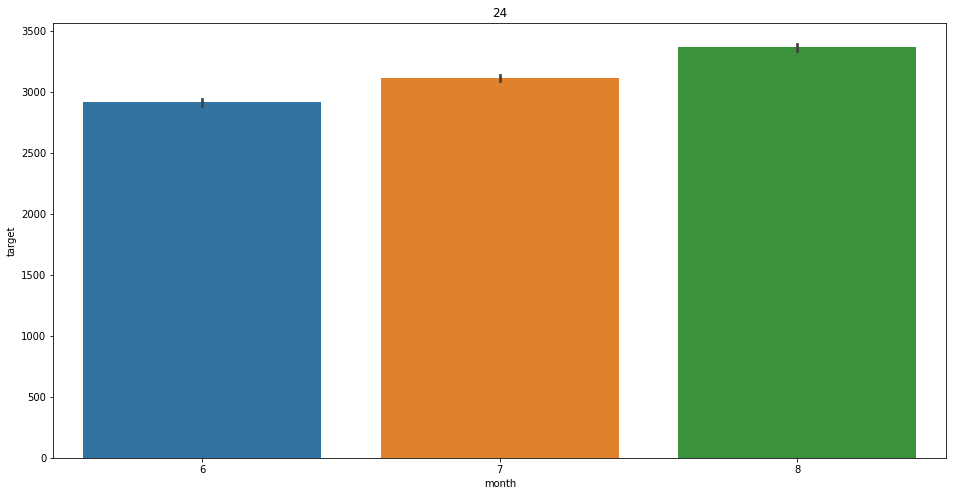

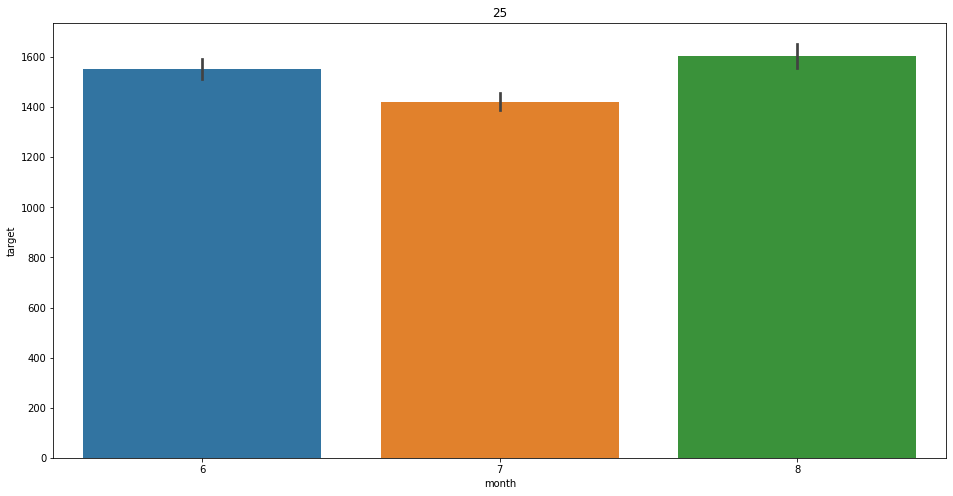

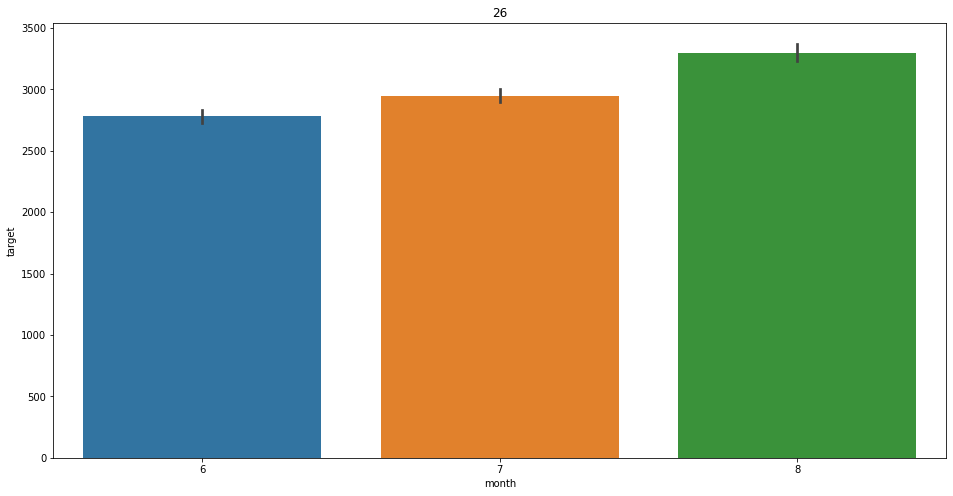

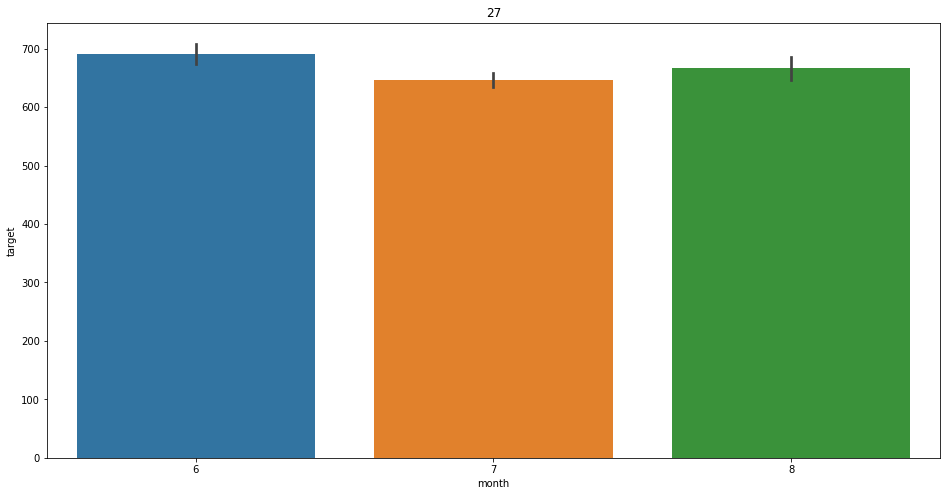

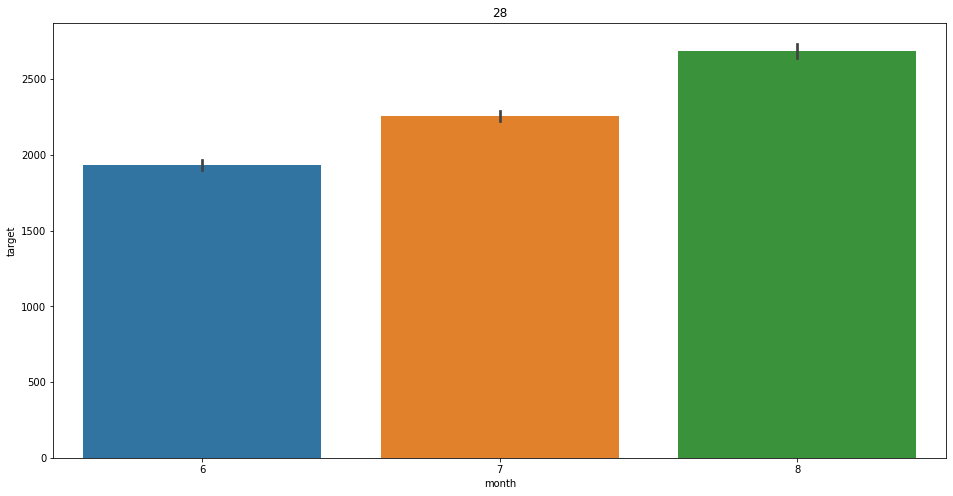

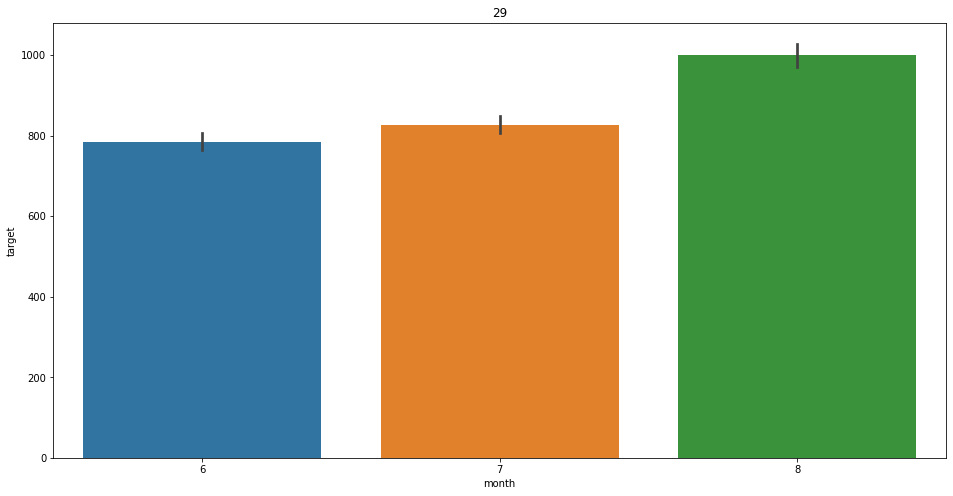

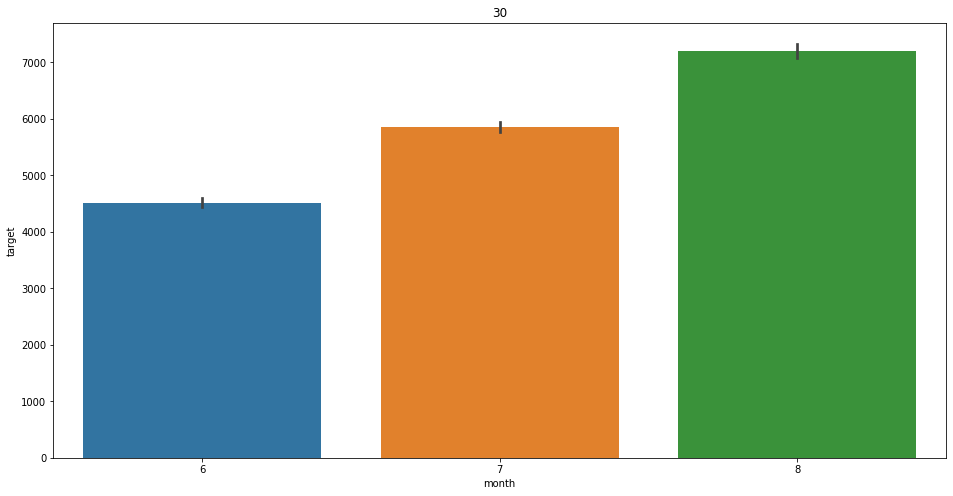

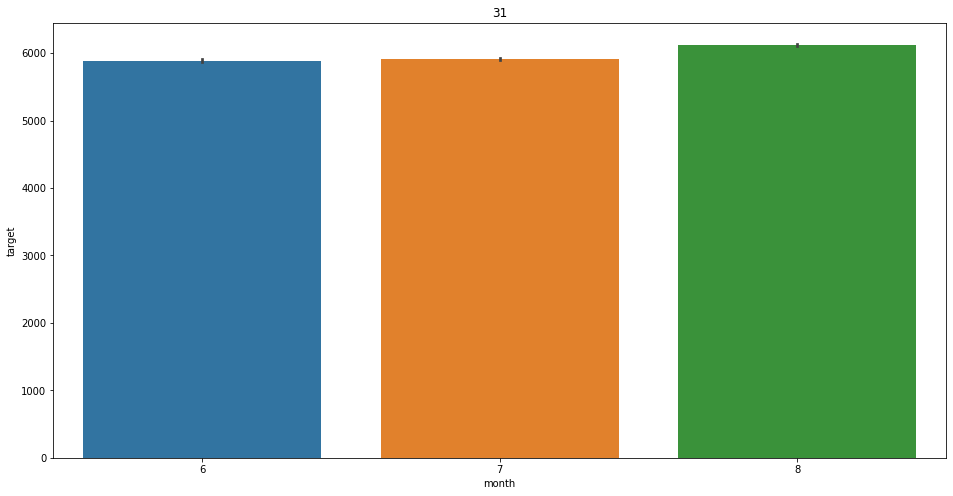

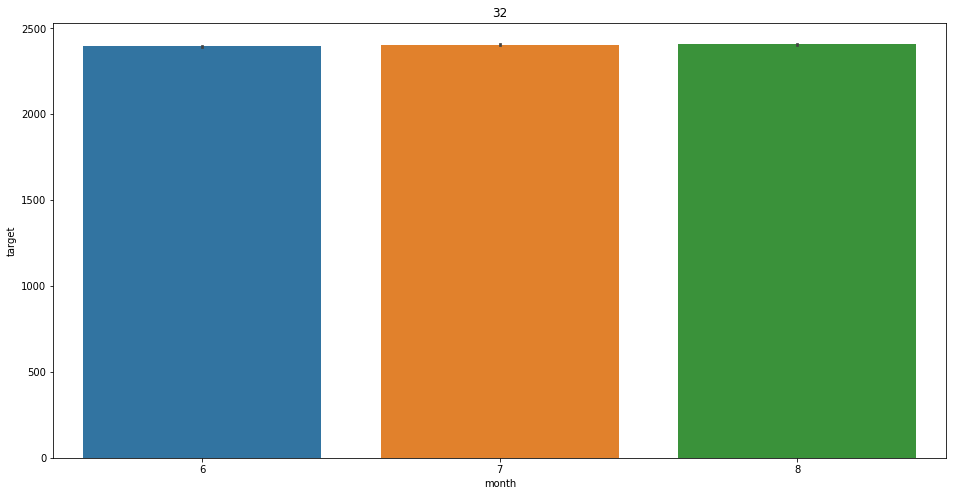

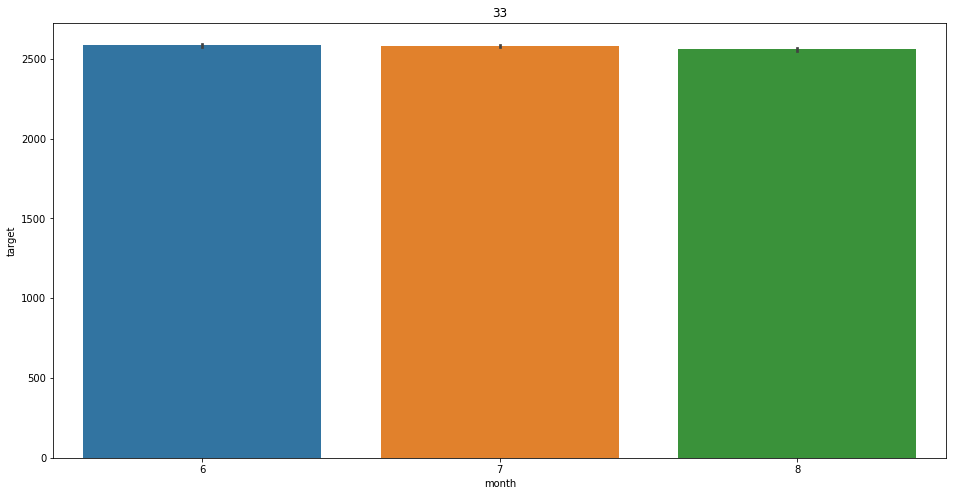

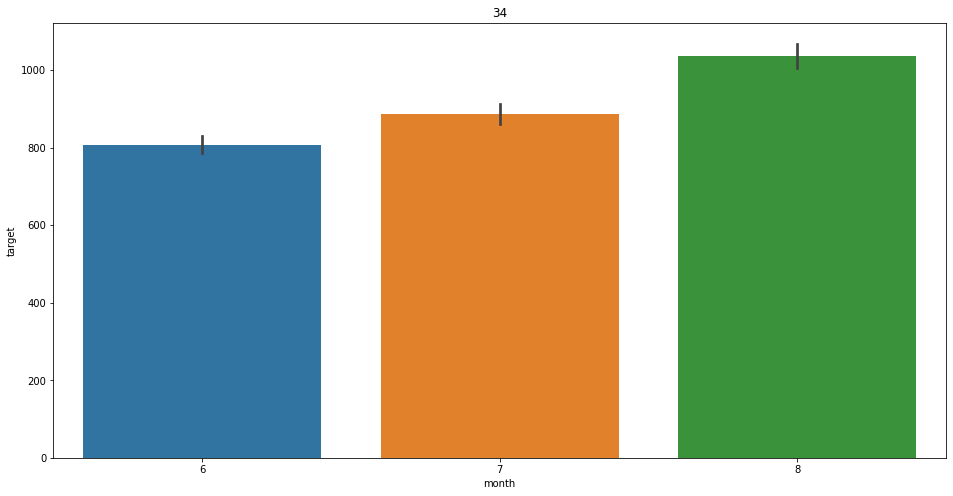

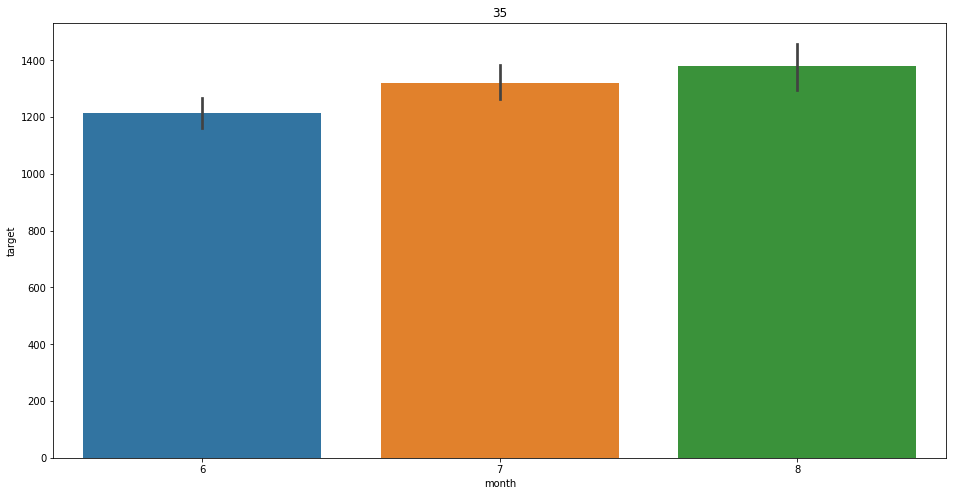

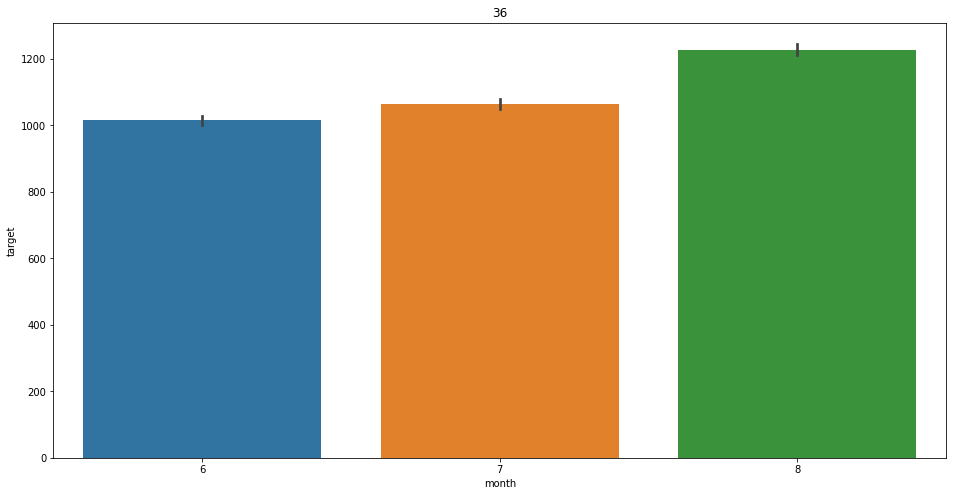

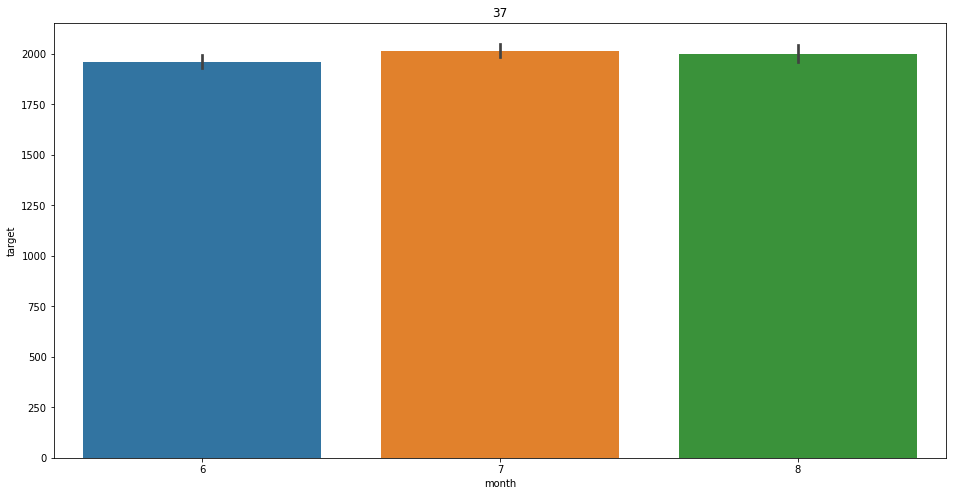

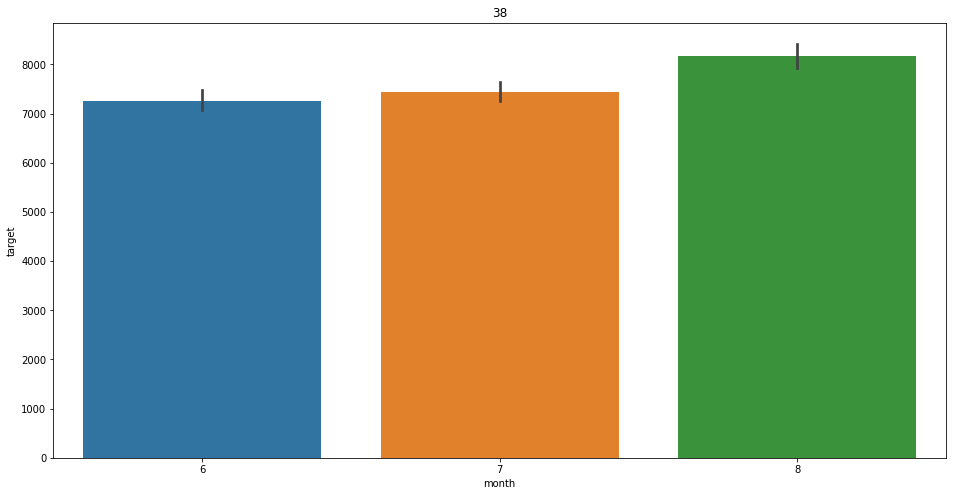

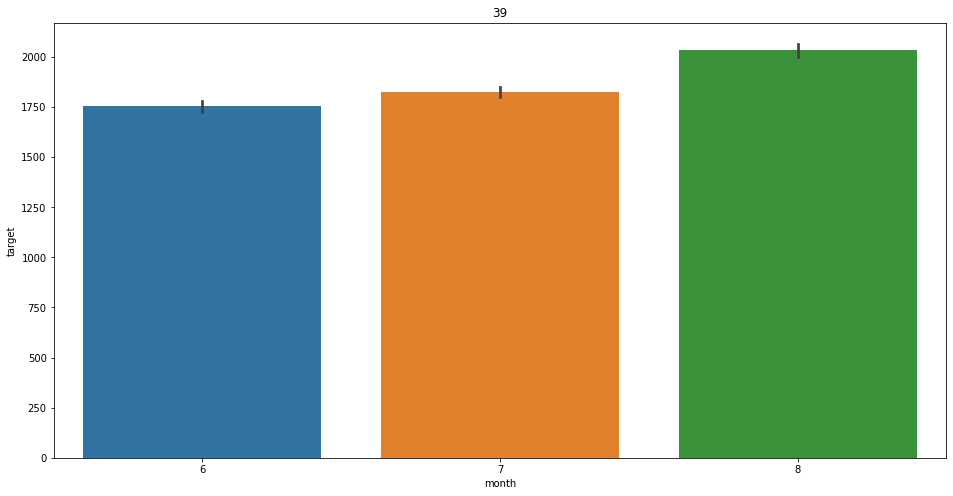

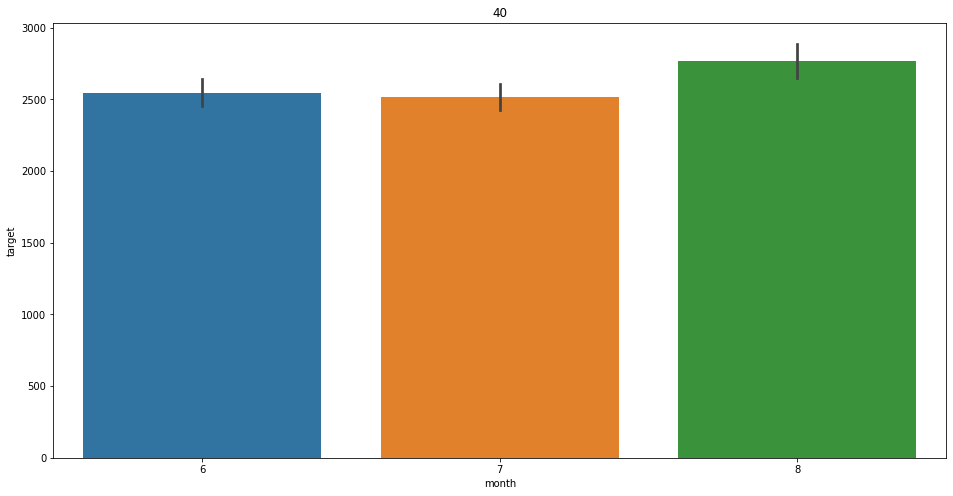

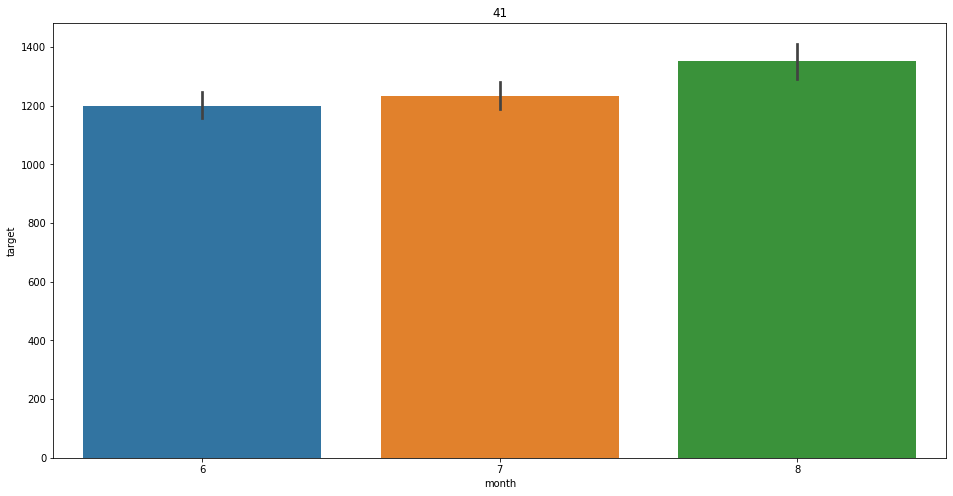

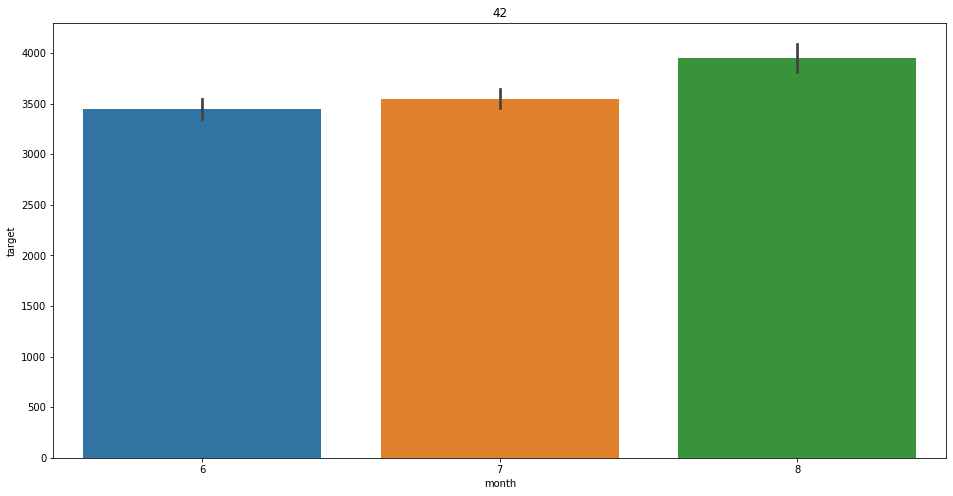

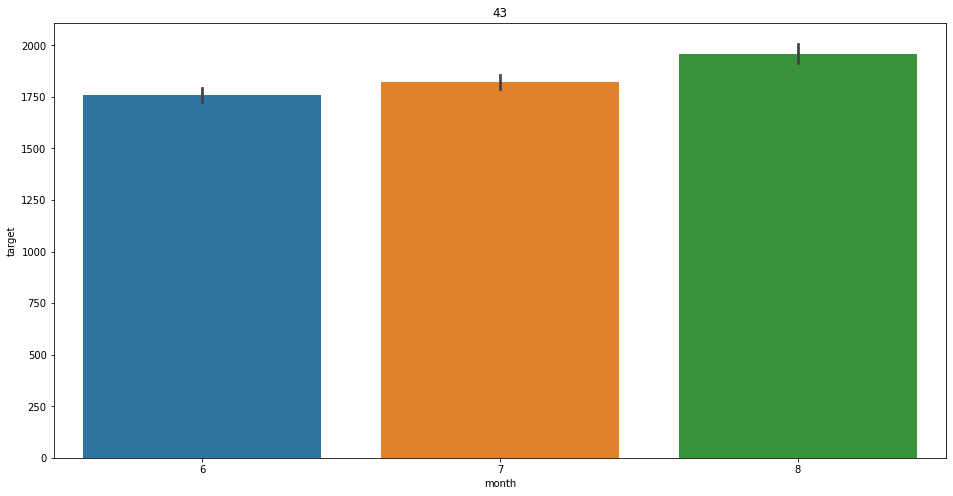

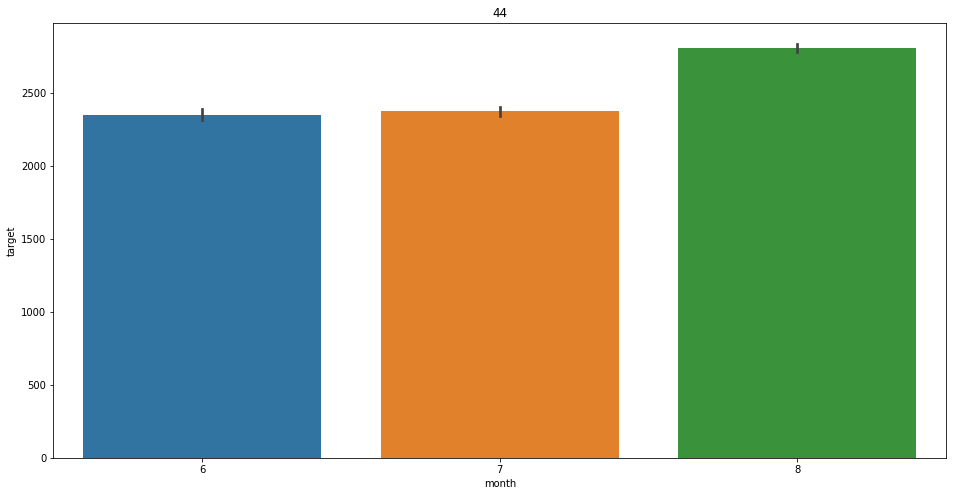

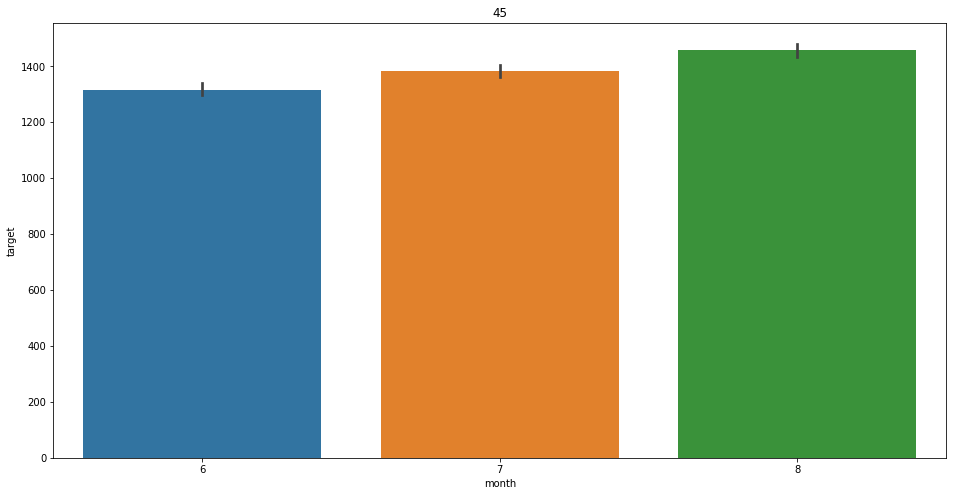

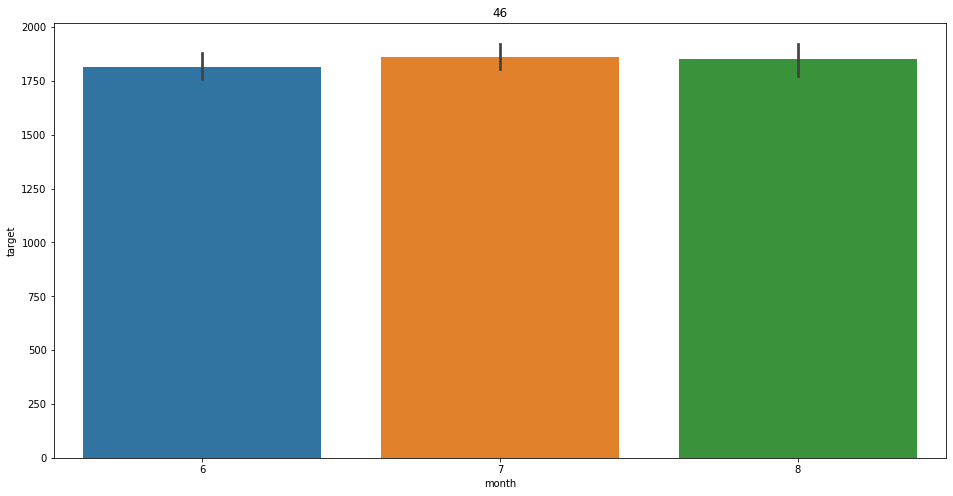

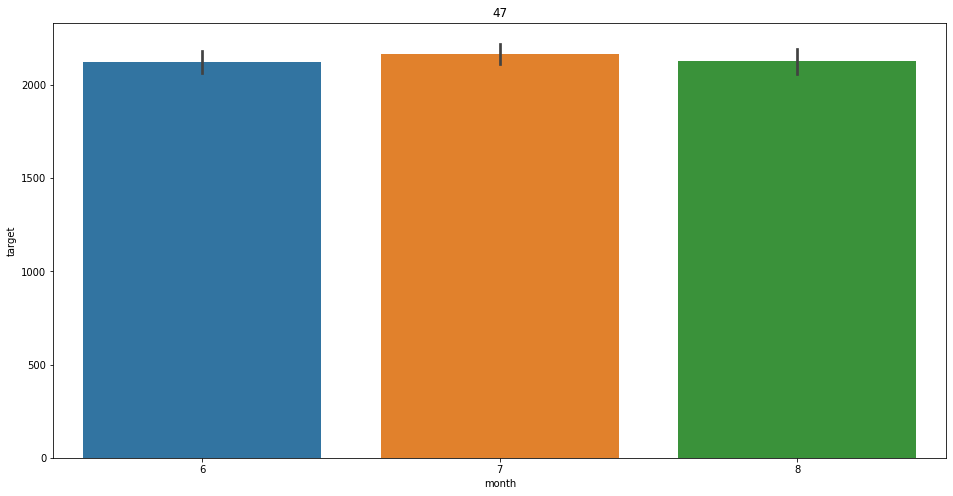

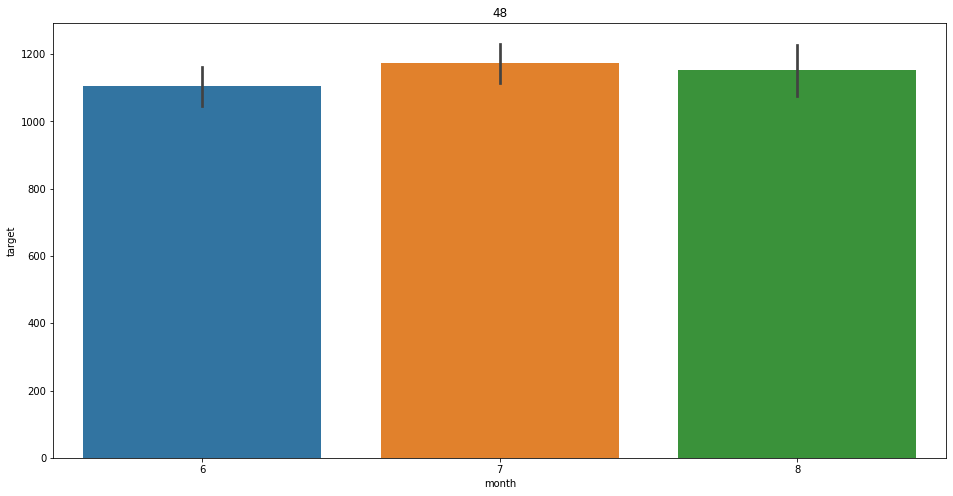

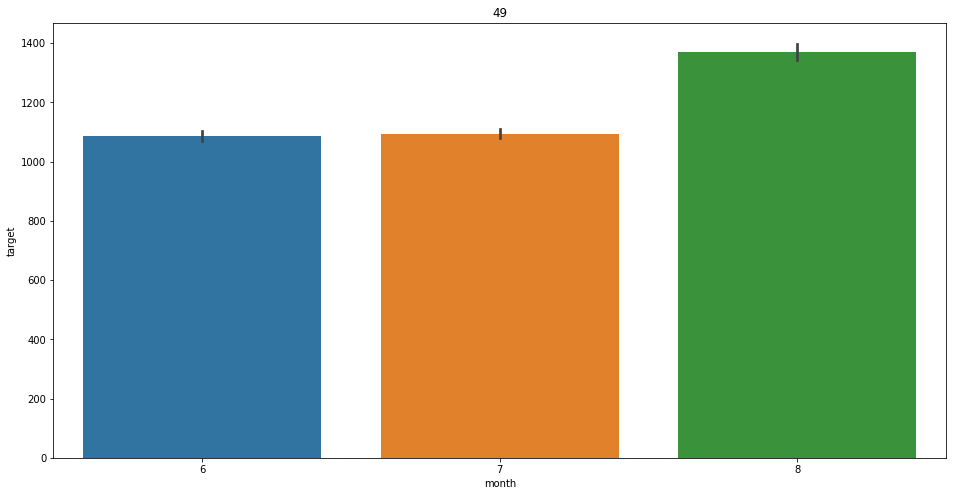

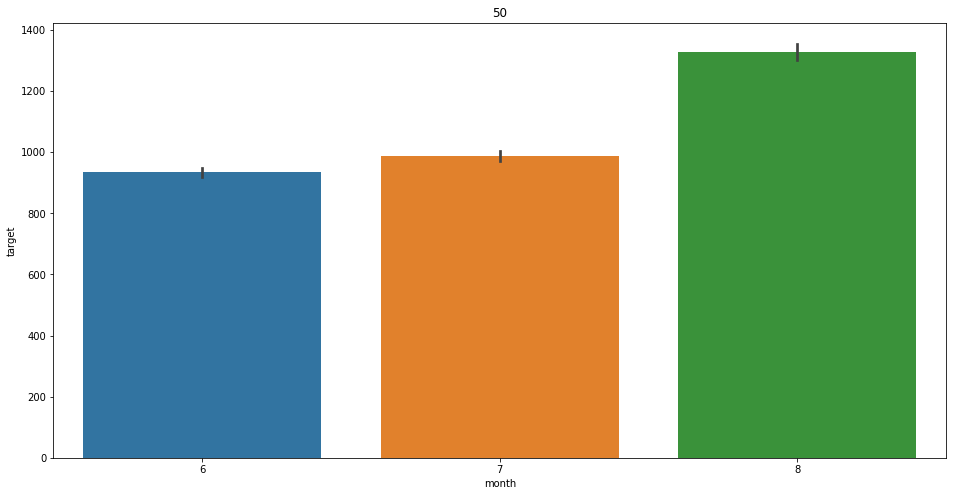

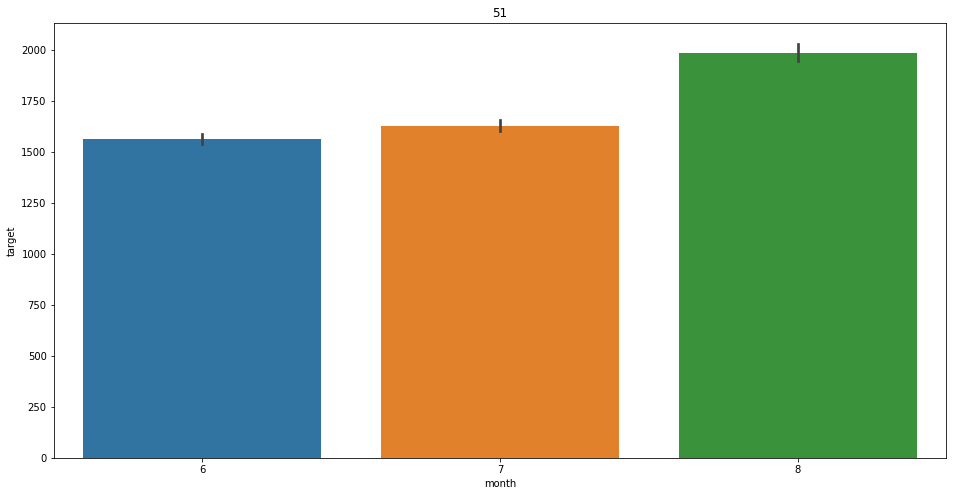

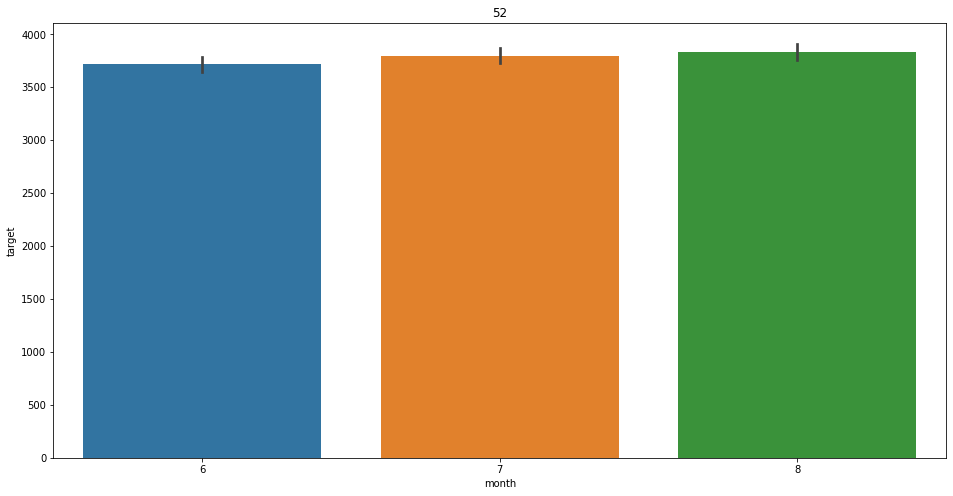

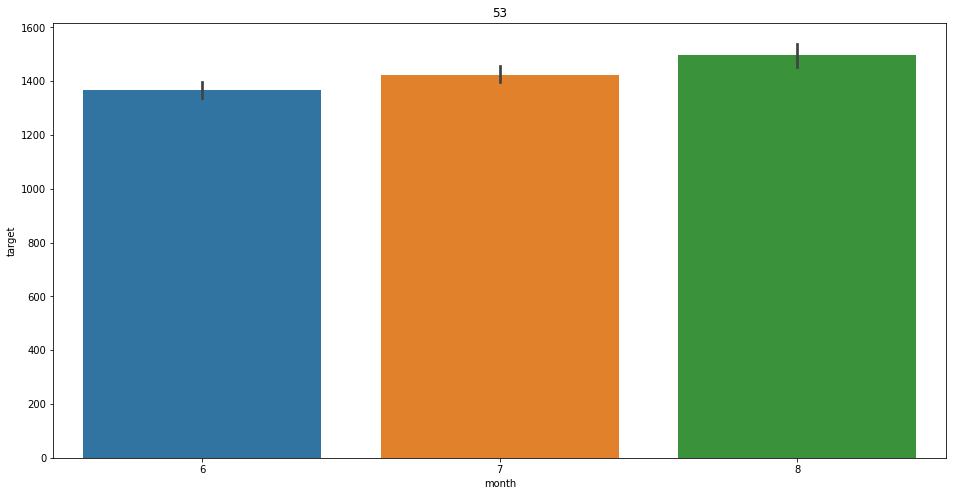

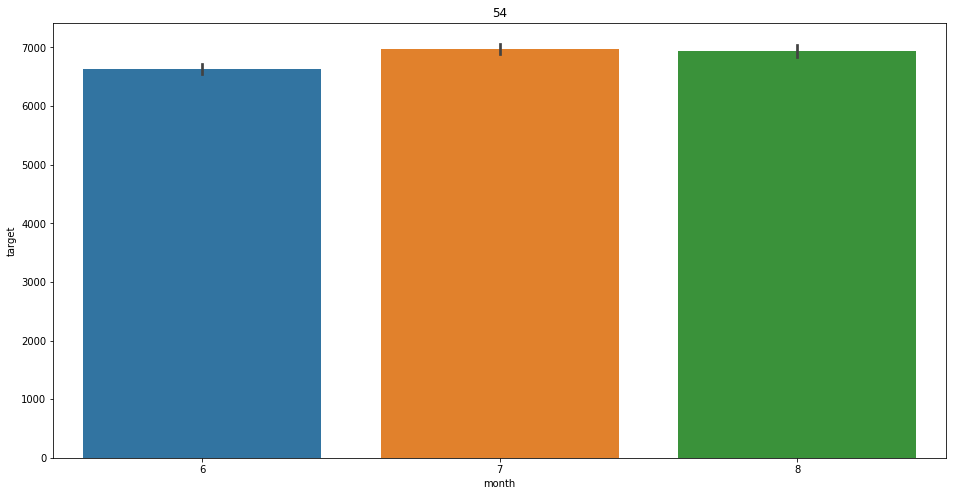

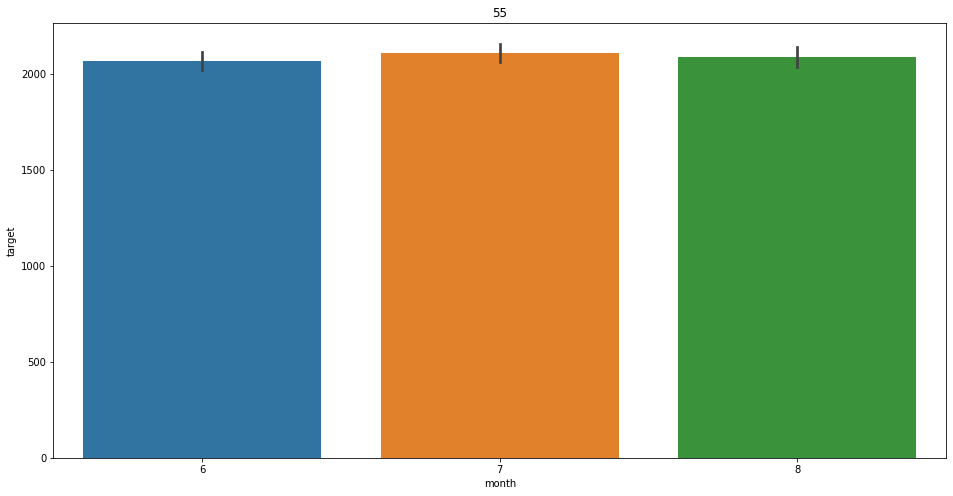

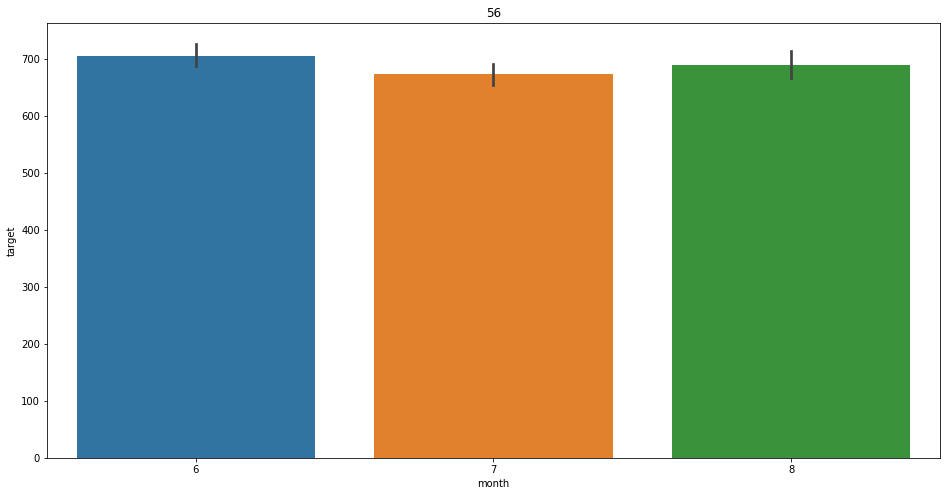

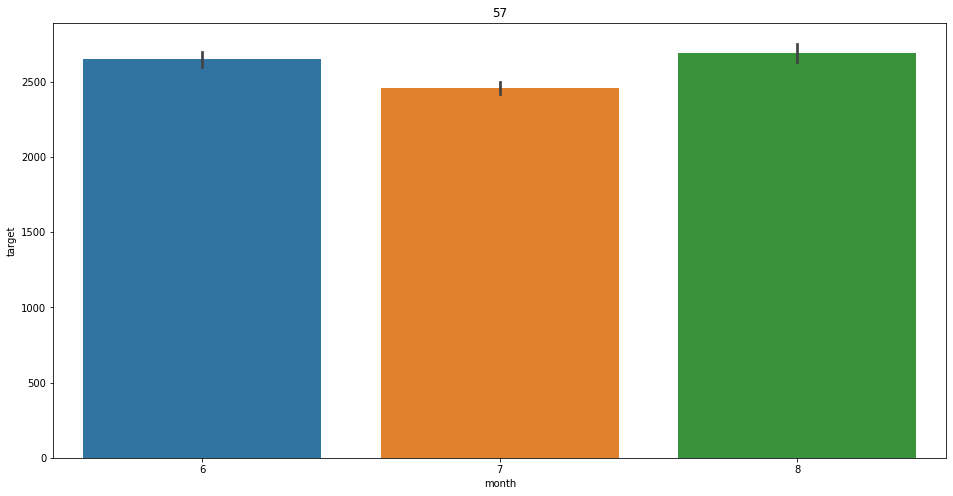

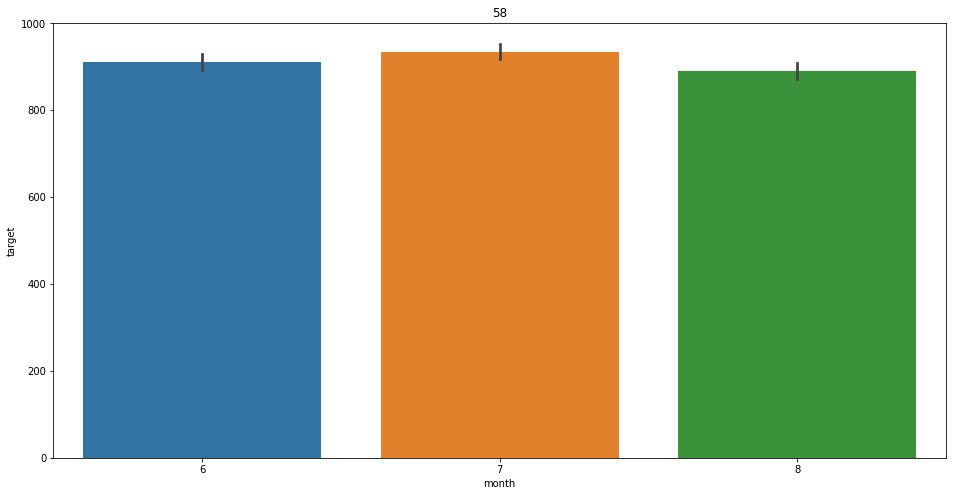

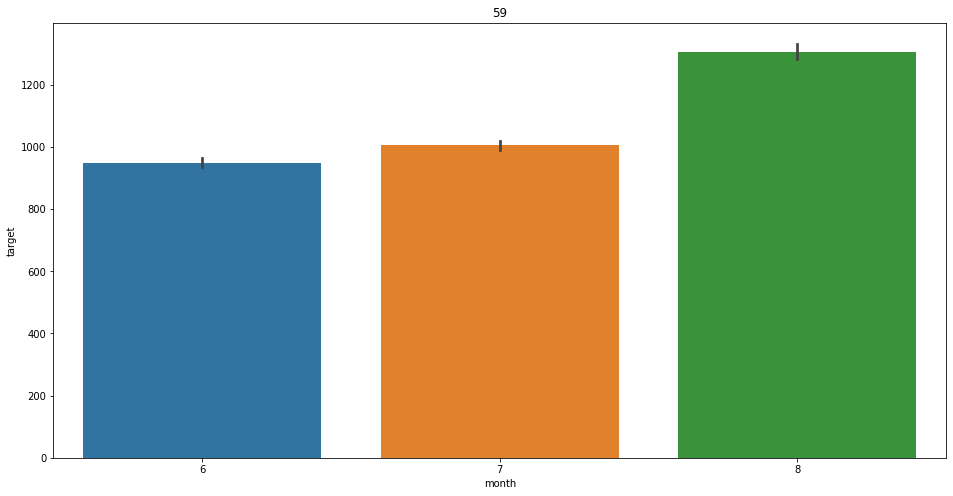

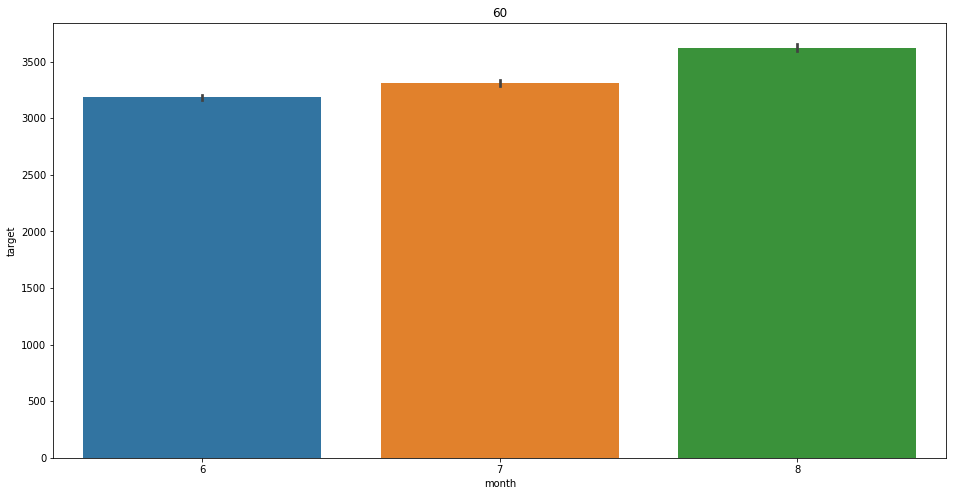

In [60]:
# 처음 생각했던 시간이 지날수록 온도가 오른다는 가정이 틀렸다는 것이 그래프로 그려졌다.
# 그러면 이번에 해야할 부분은 왜? 시간이 지날수록 전력사용량이 증가하는 데이터는 어떤 특성이 있을까? 확인해보자.
for i in train['num'].unique():
  plt.figure(figsize = (16,8))
  sns.barplot(data = train[train['num'] == i], x = 'month', y = 'target')
  plt.title(f'{i}')
  plt.show()

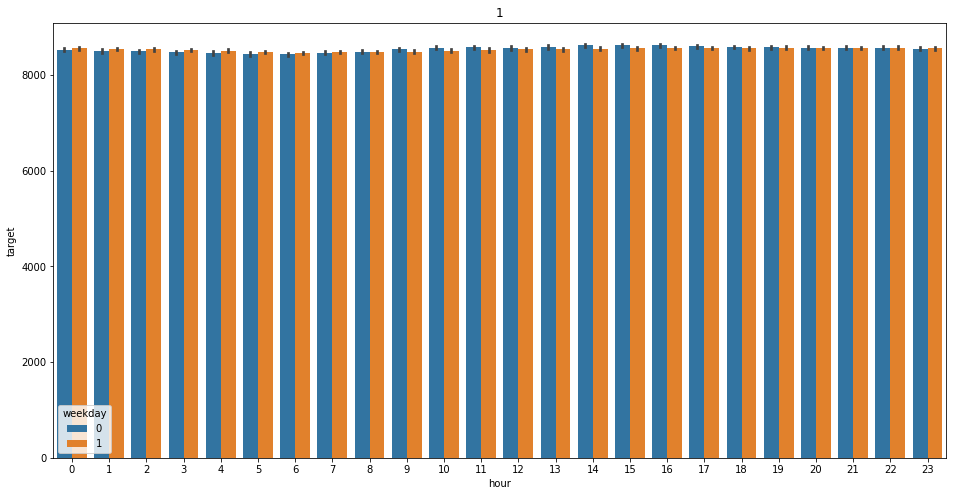

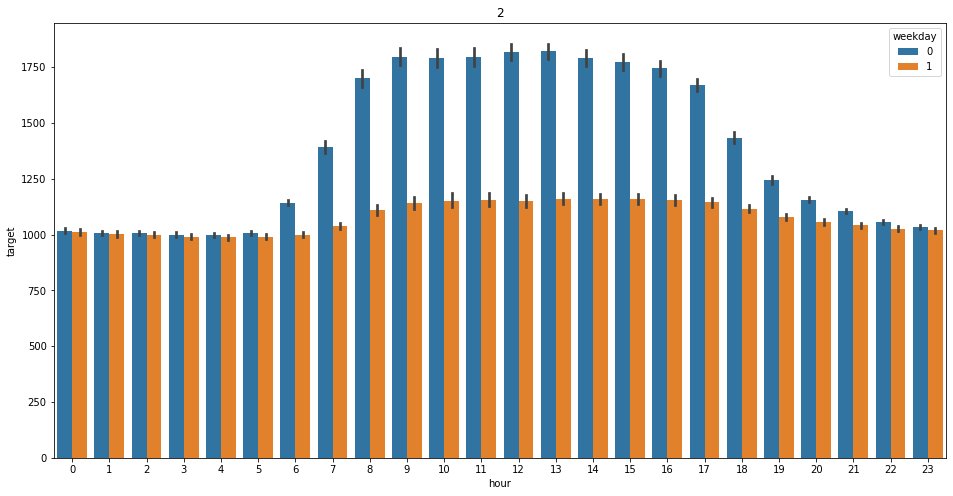

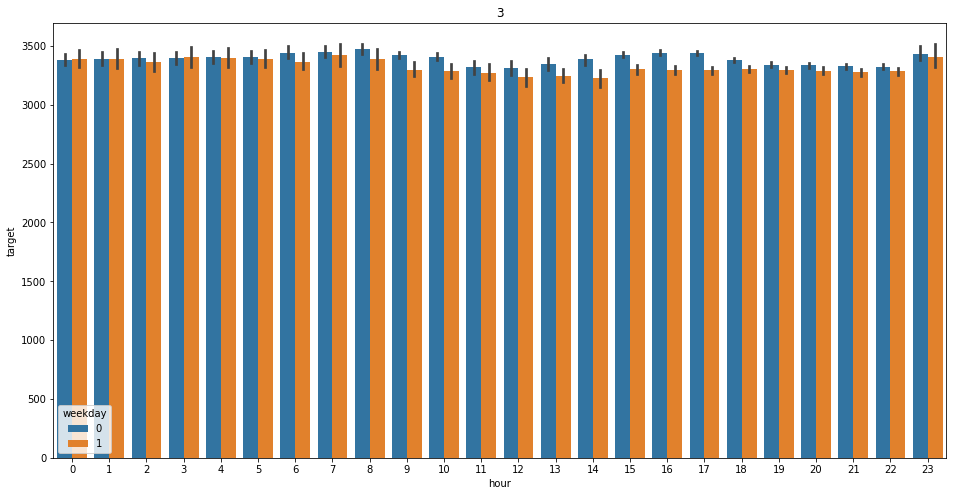

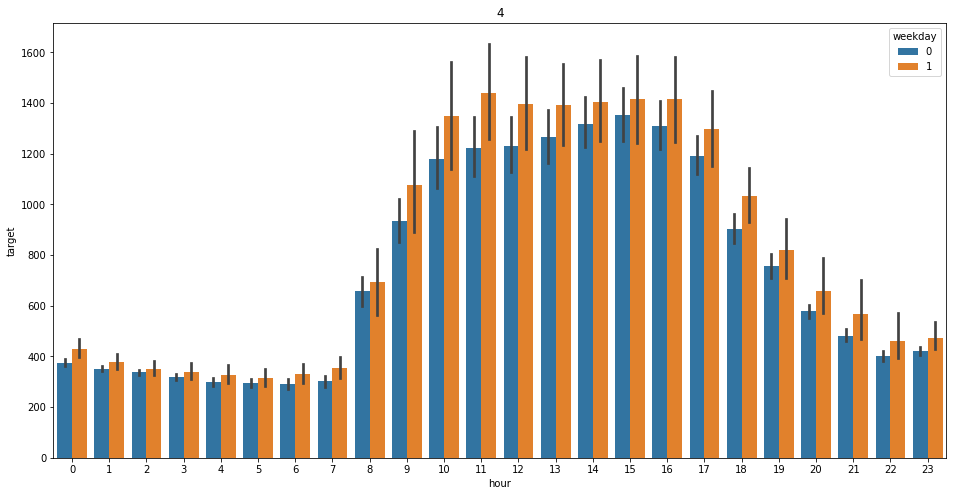

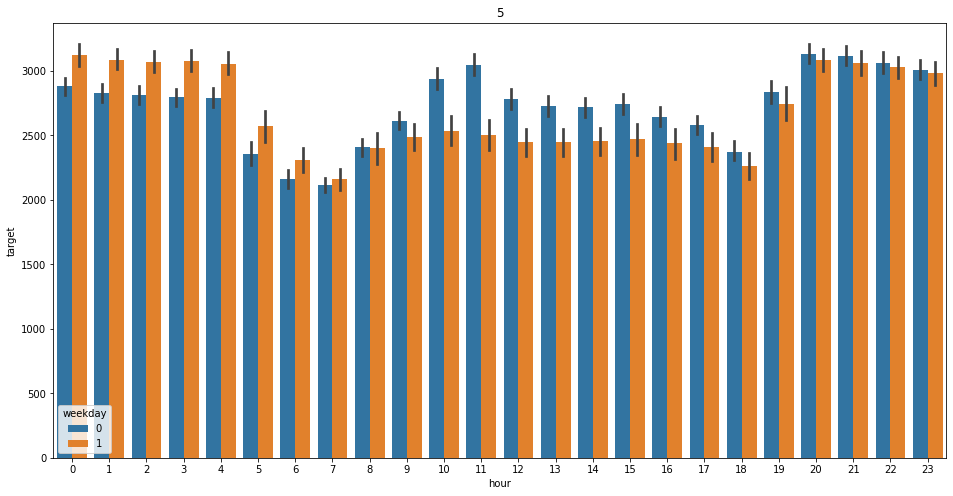

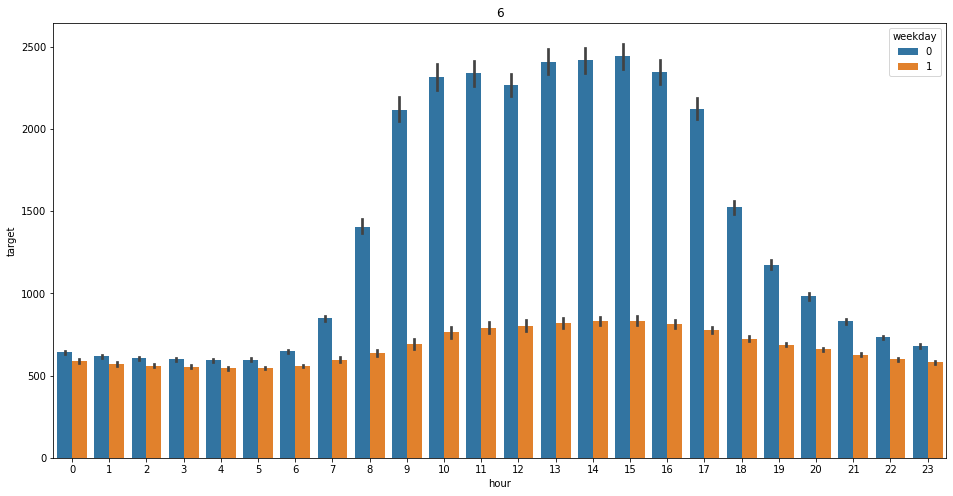

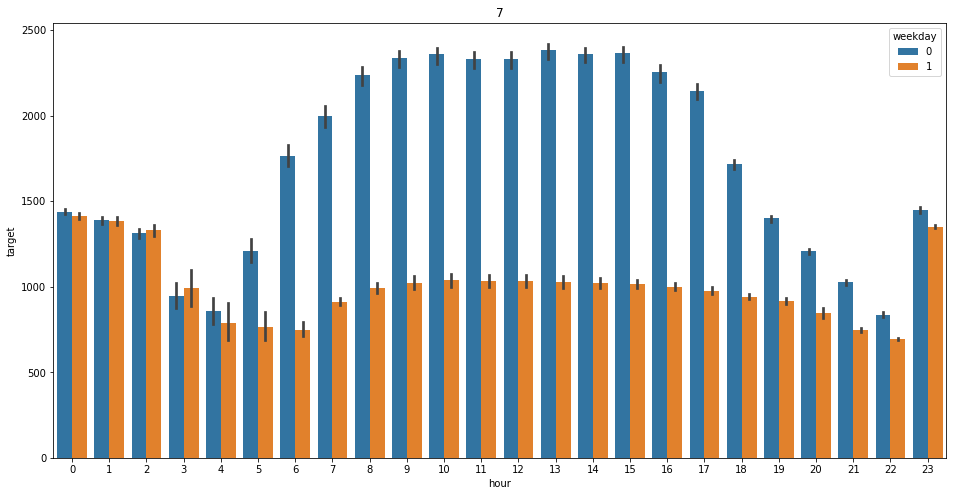

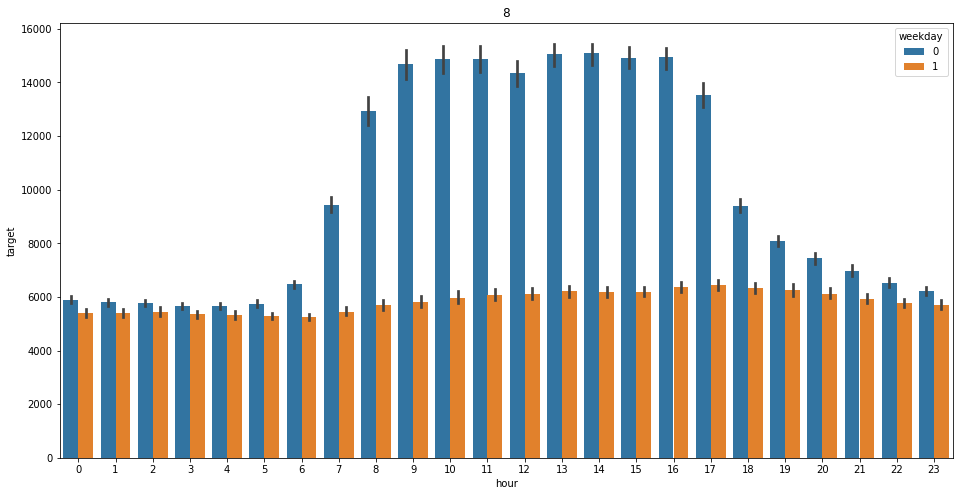

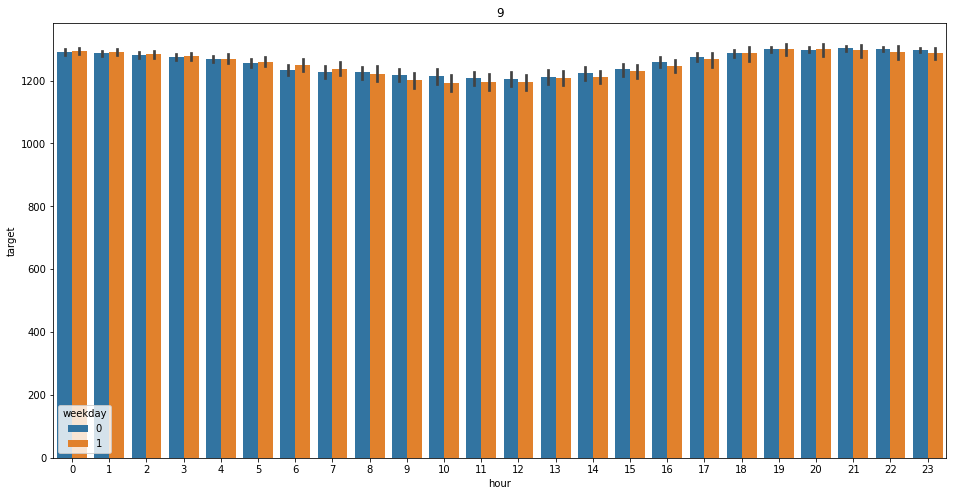

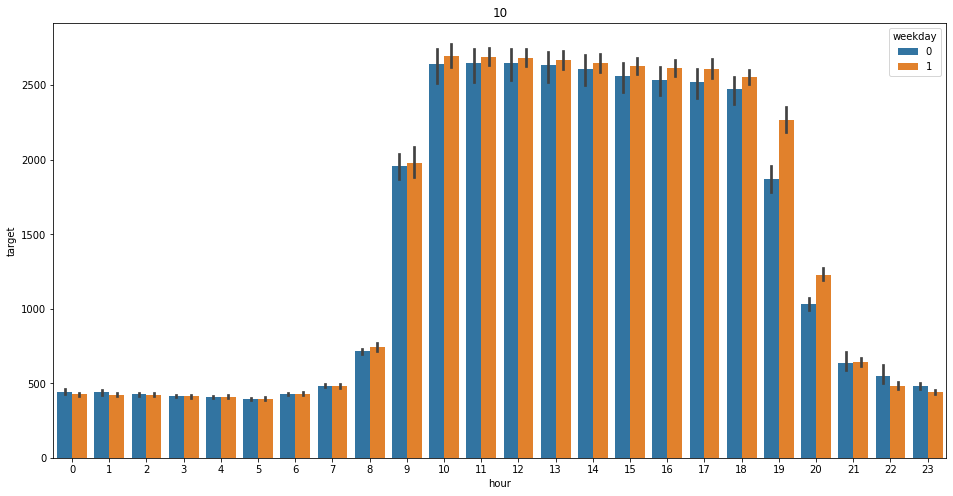

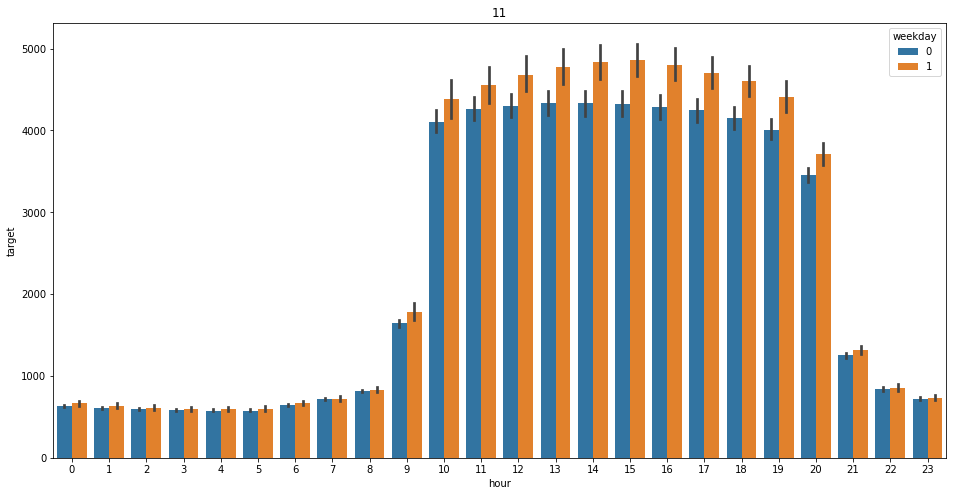

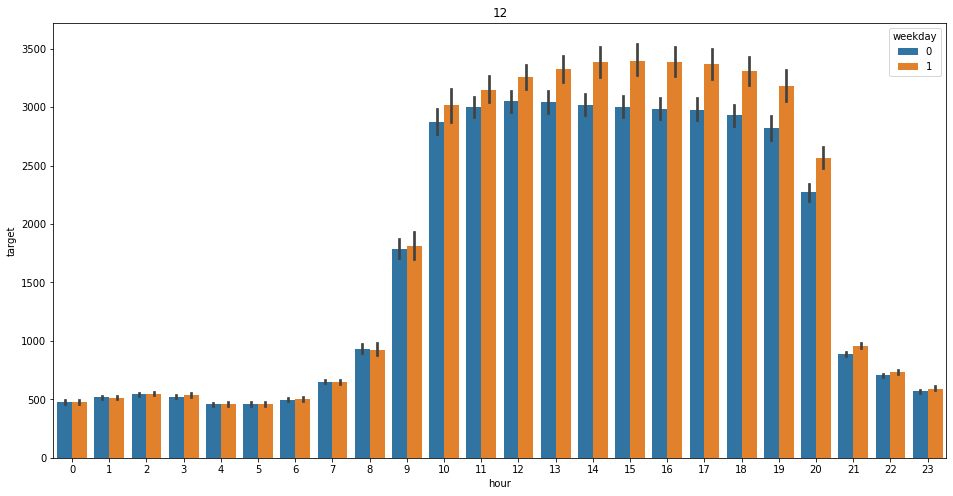

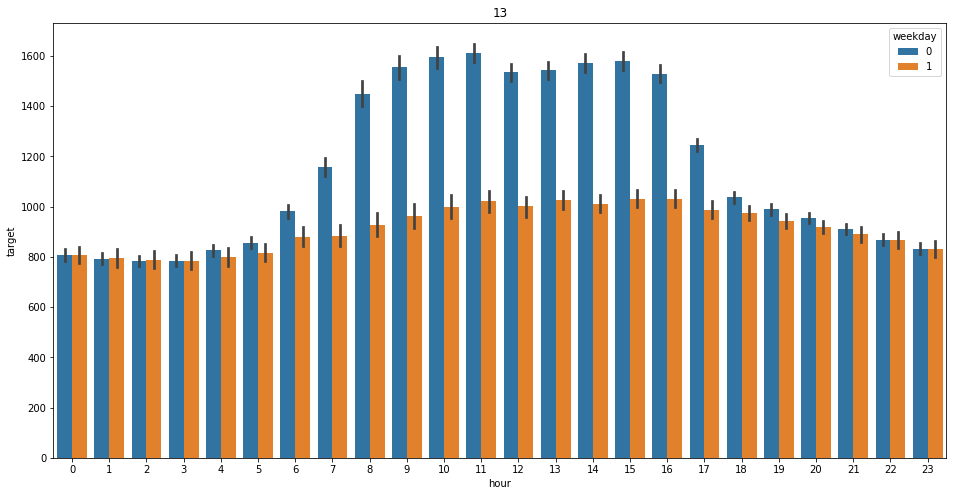

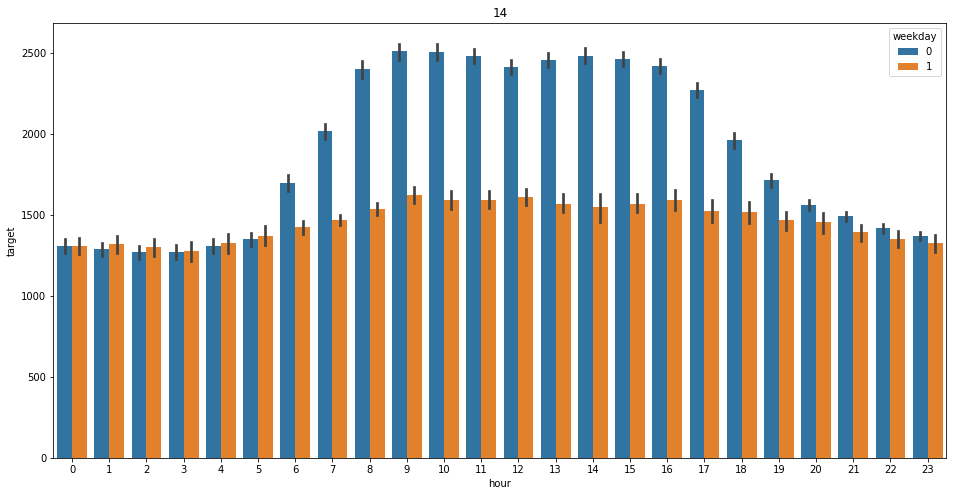

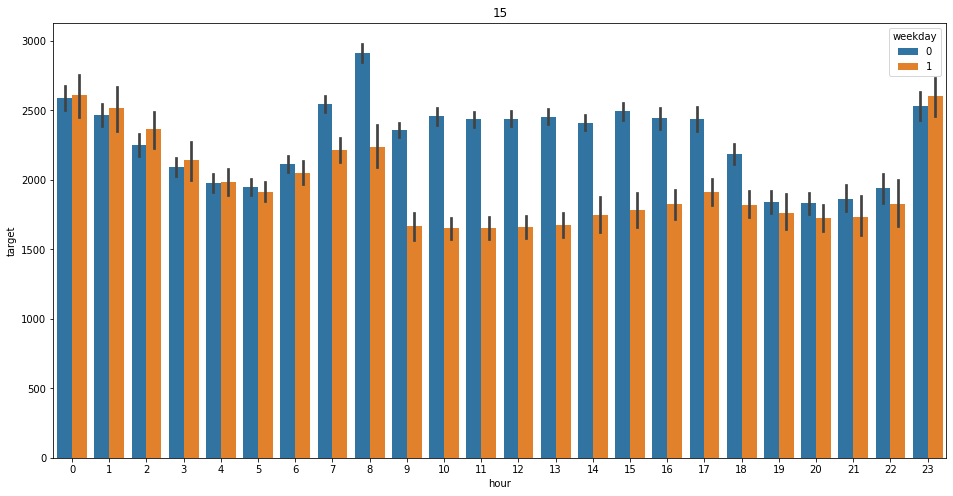

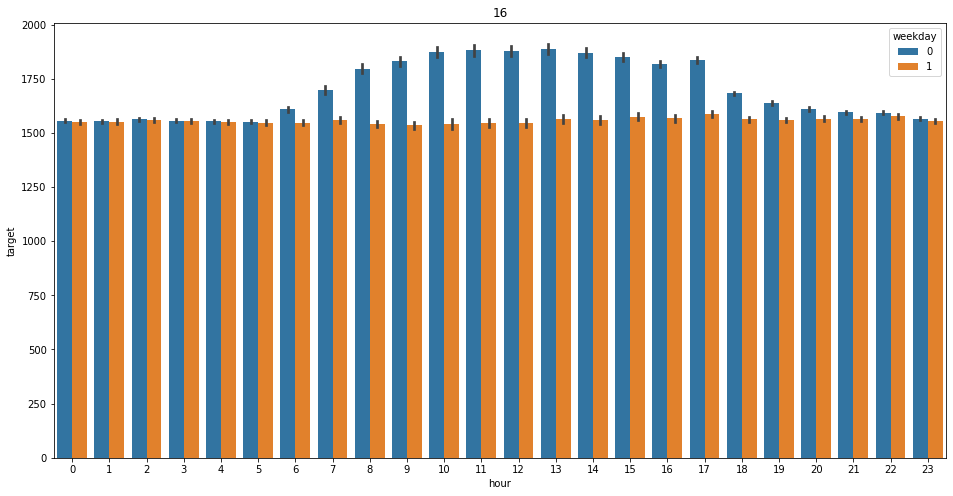

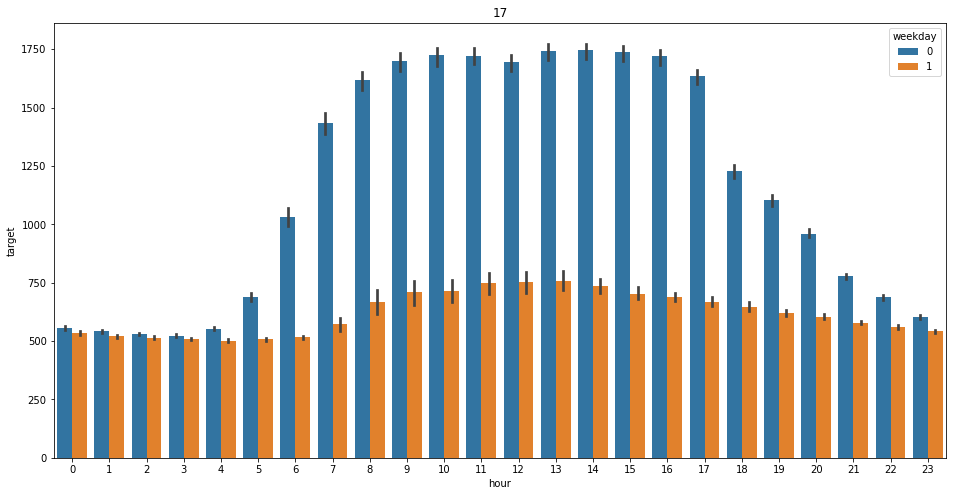

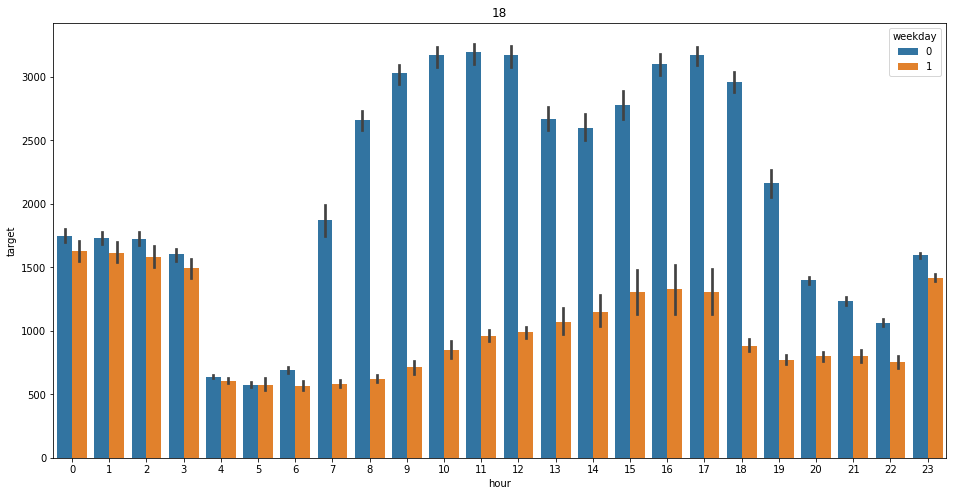

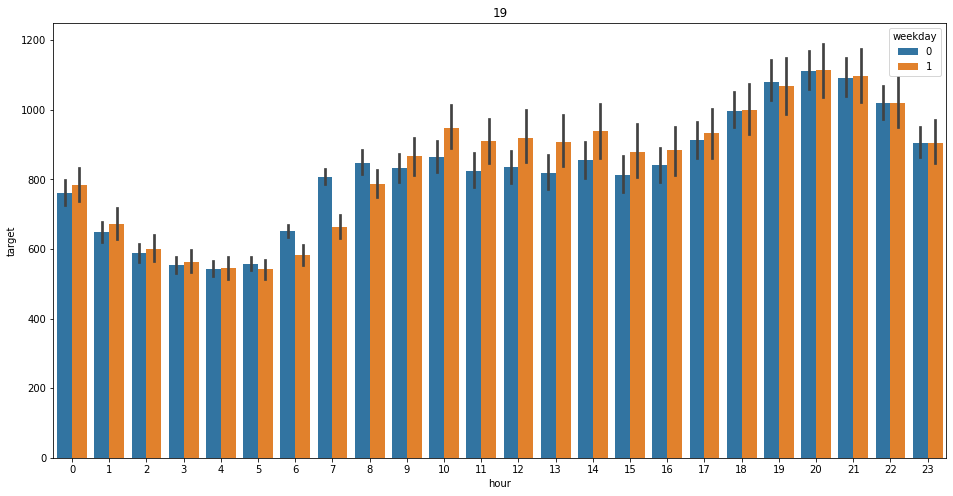

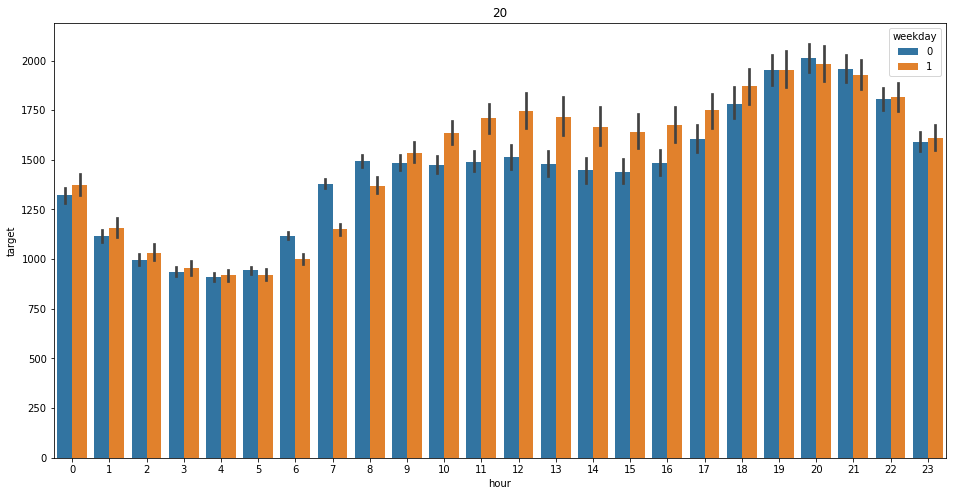

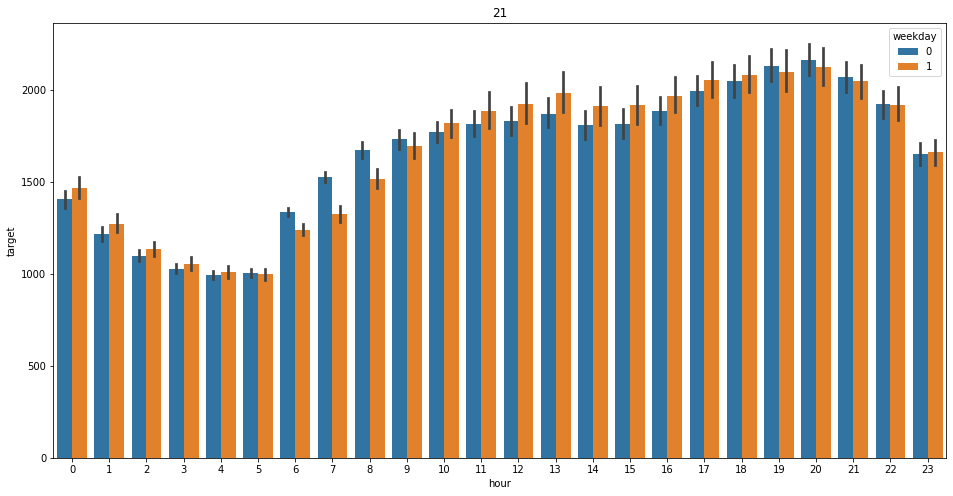

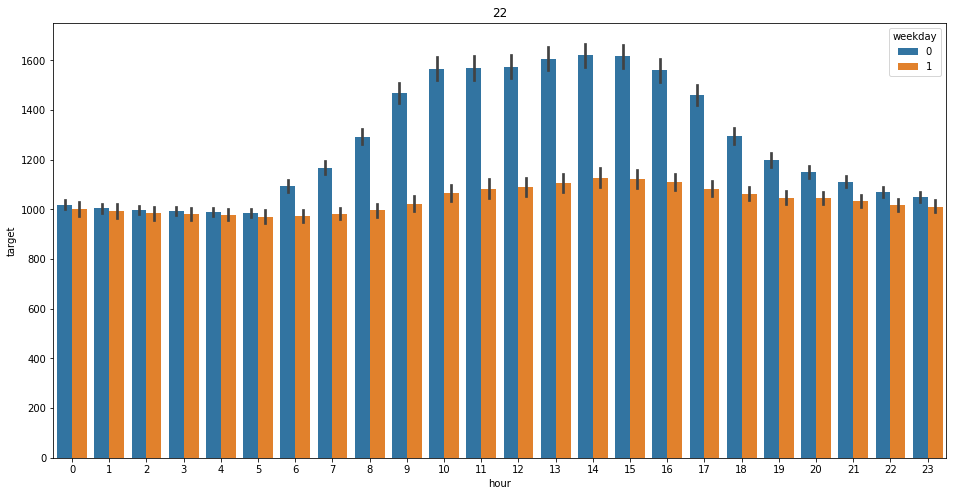

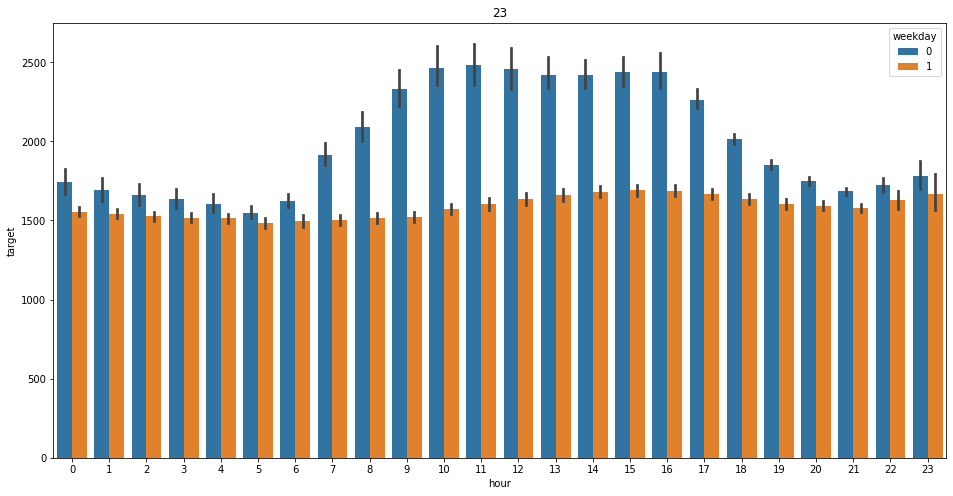

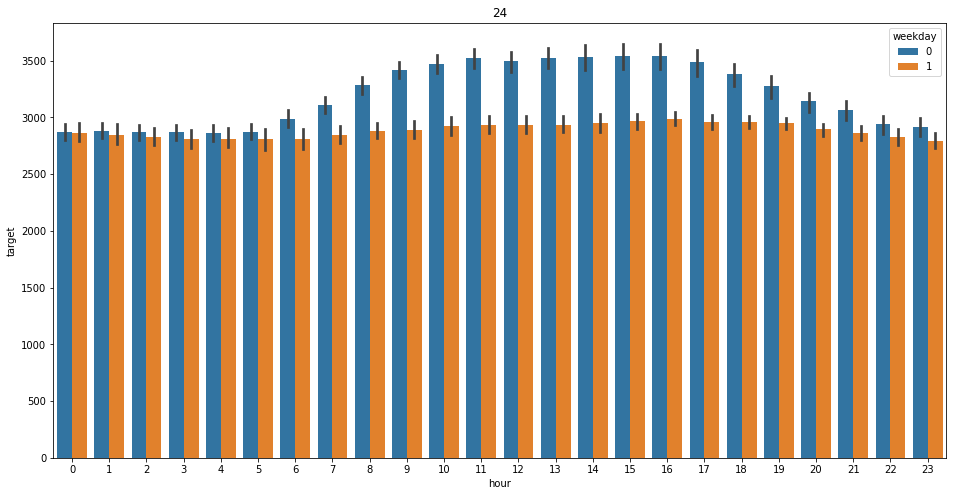

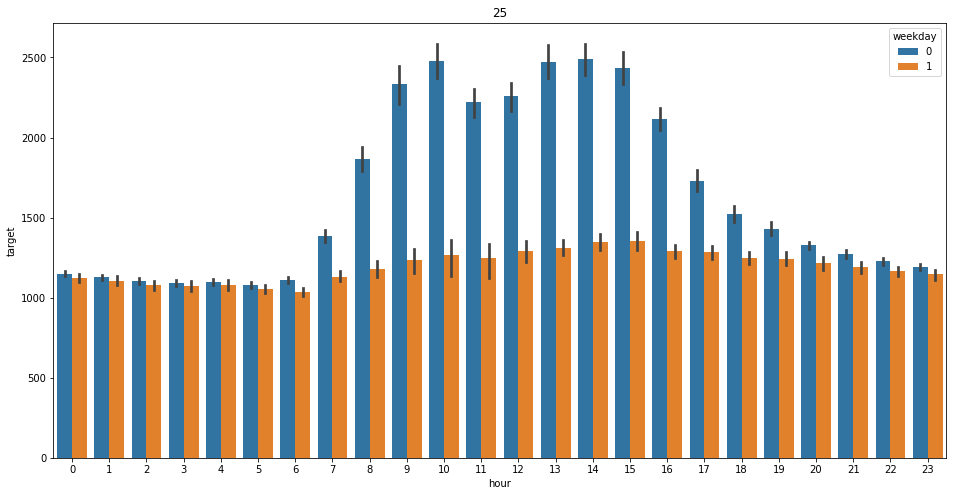

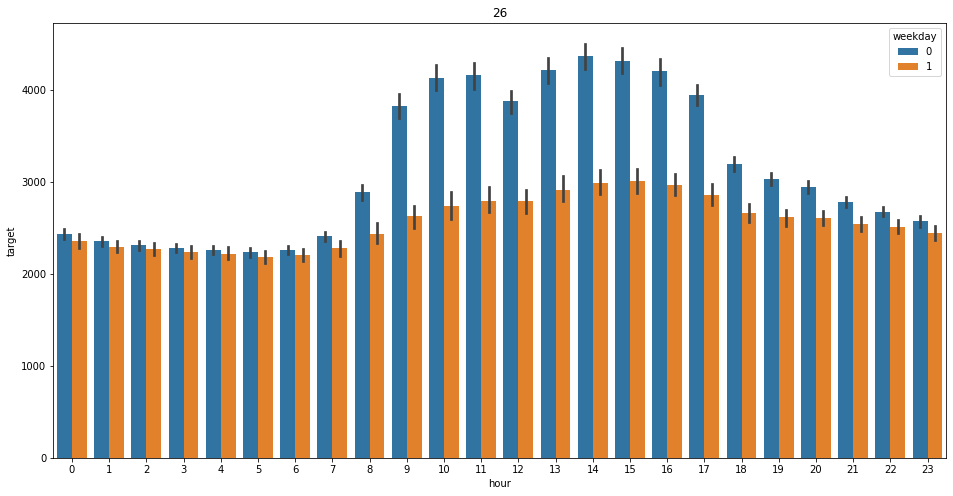

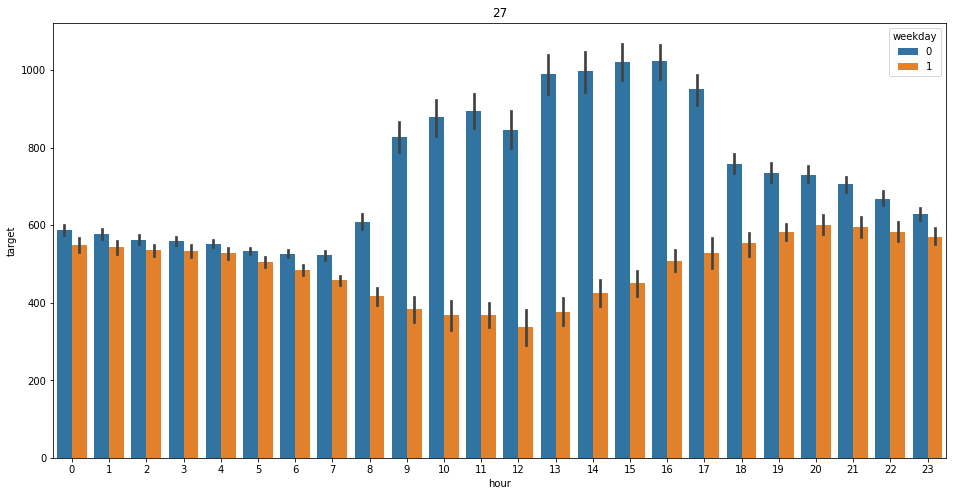

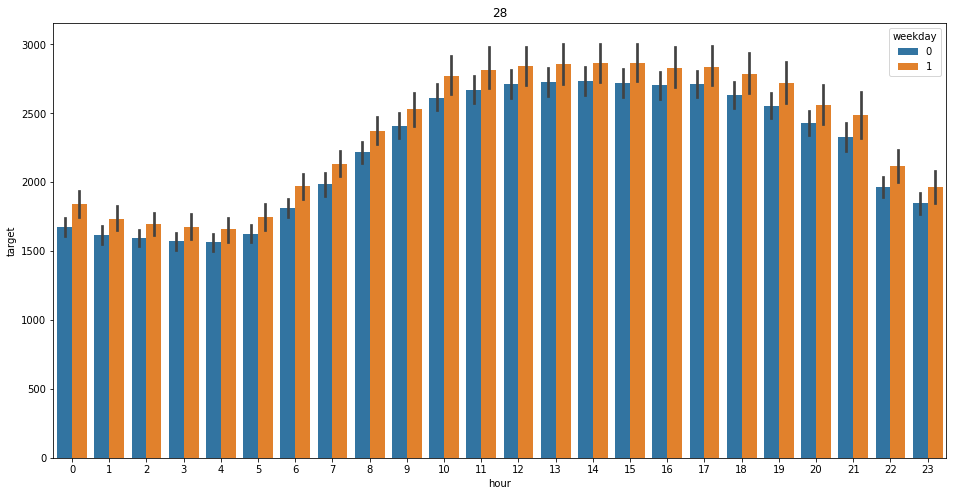

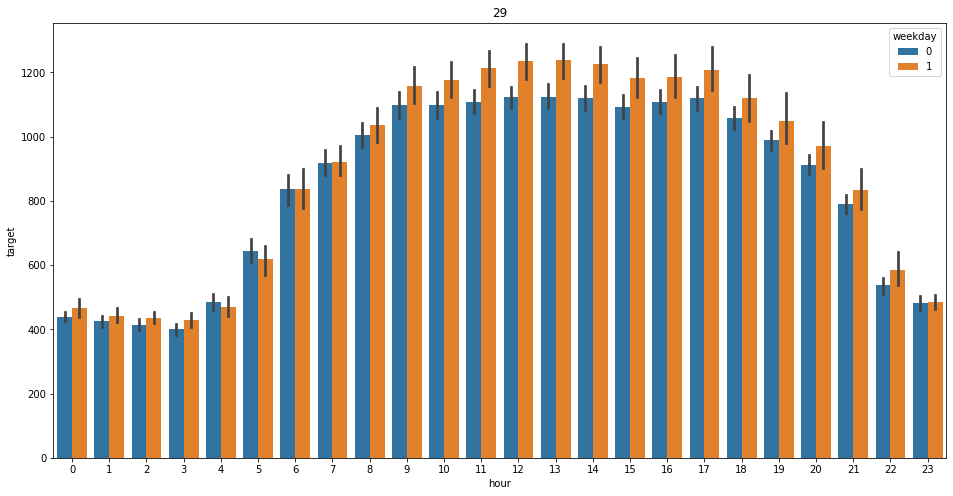

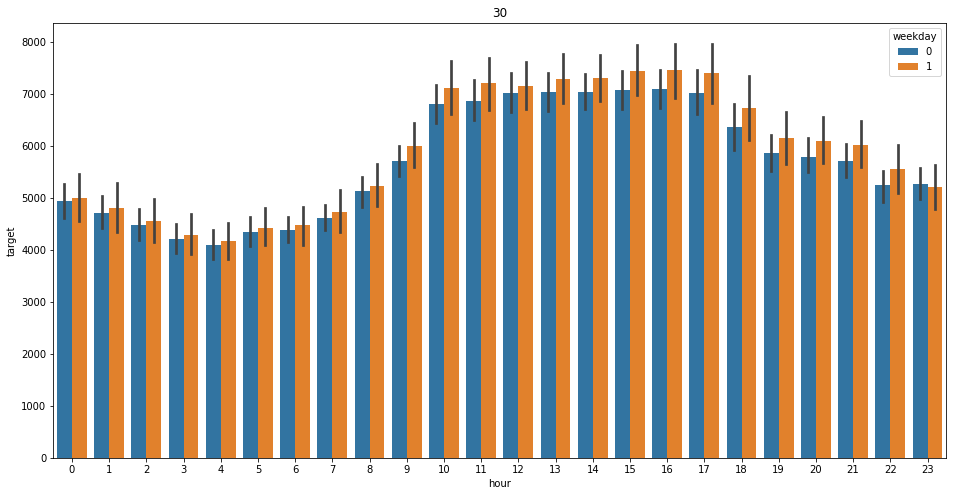

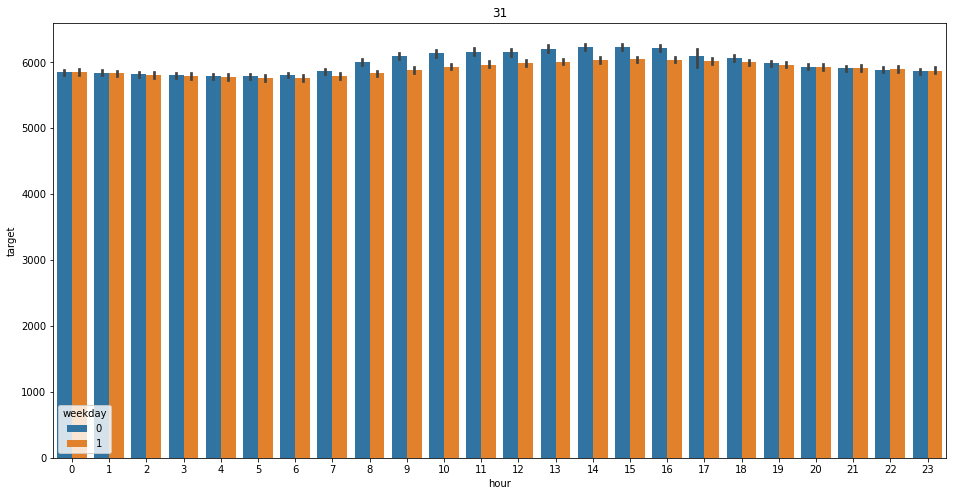

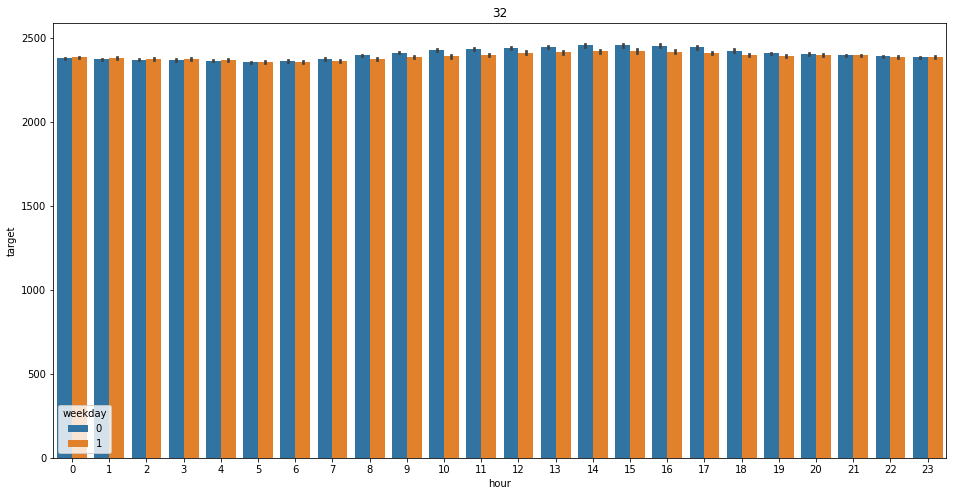

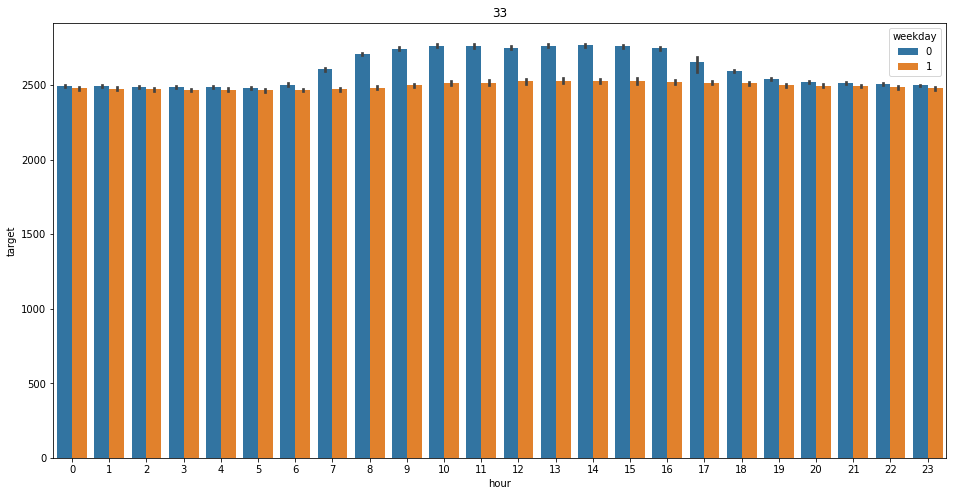

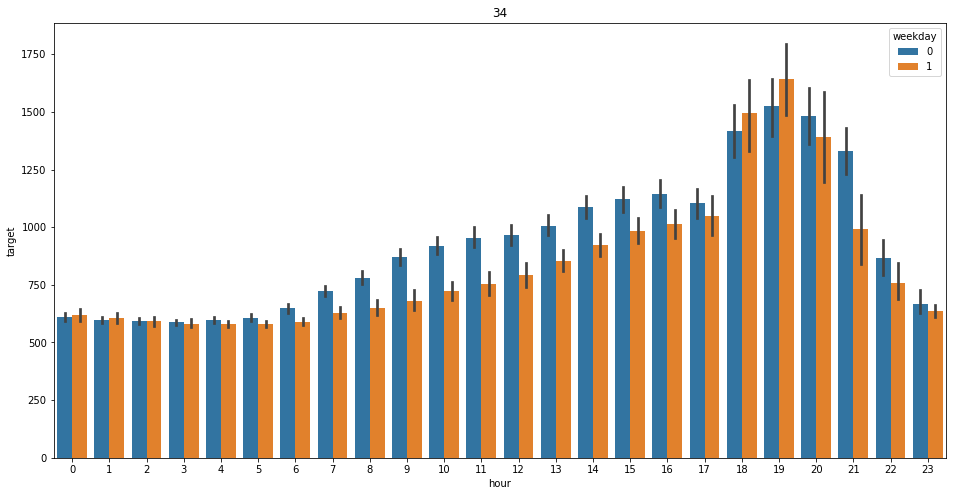

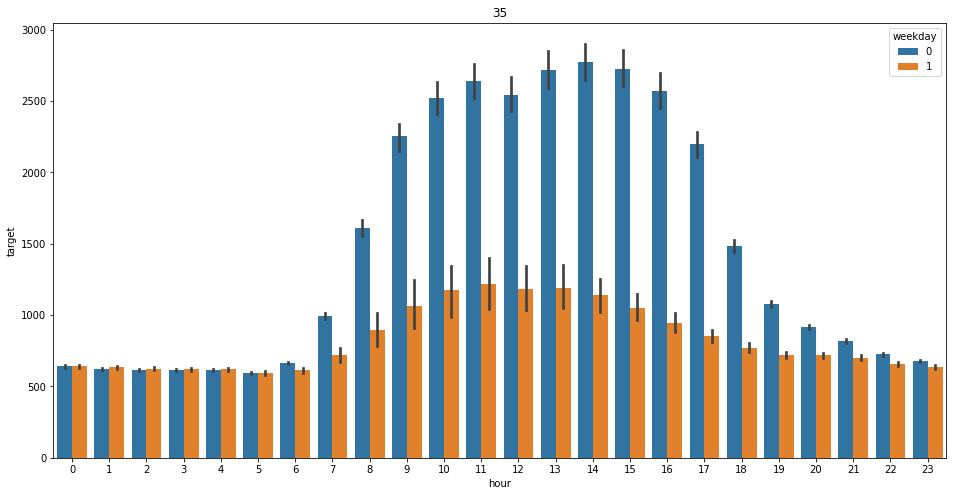

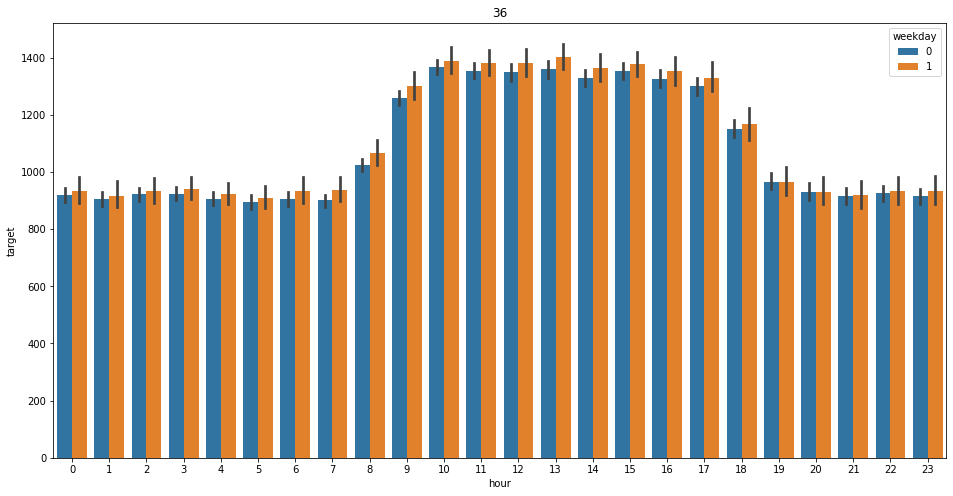

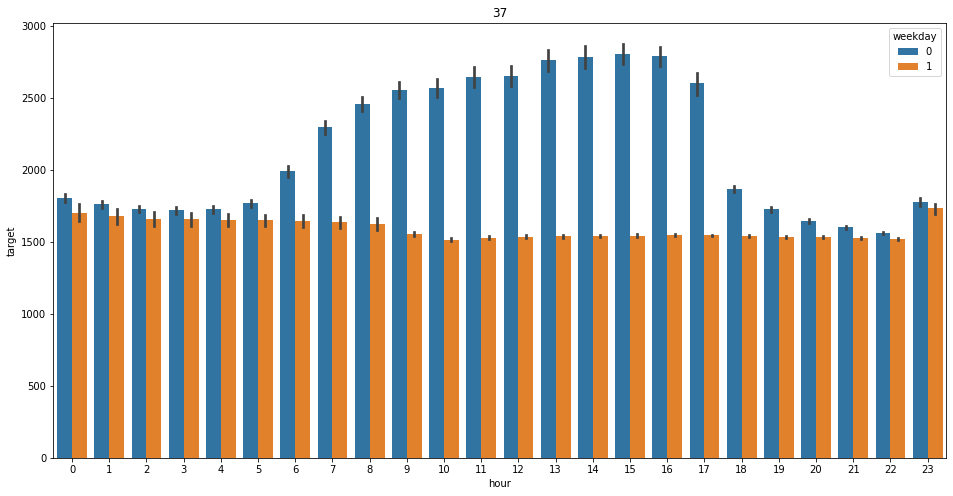

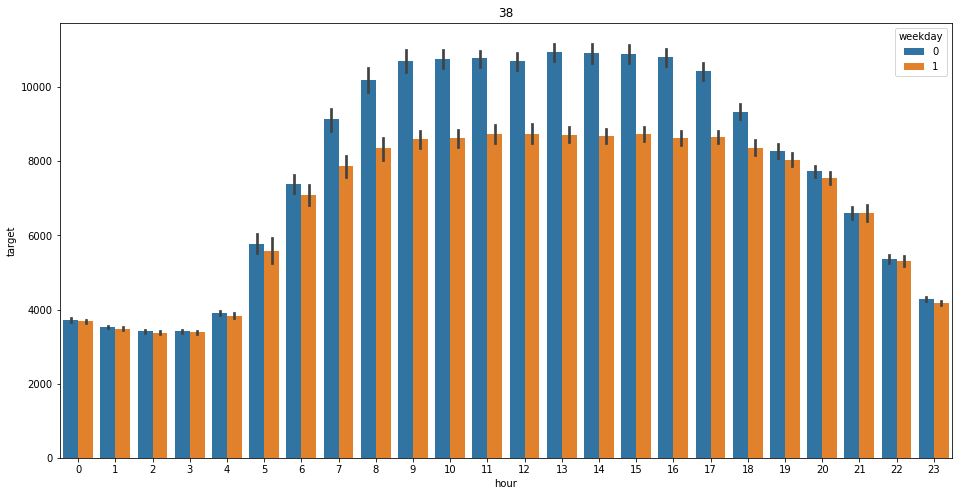

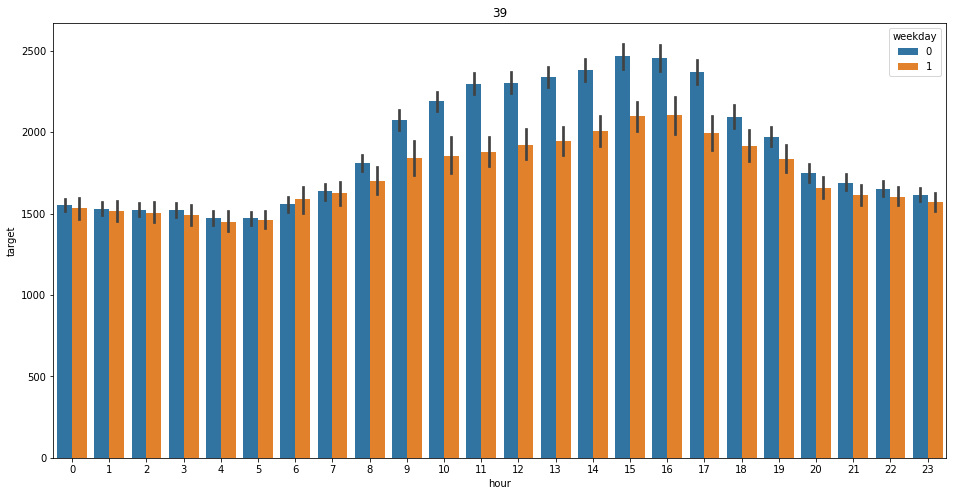

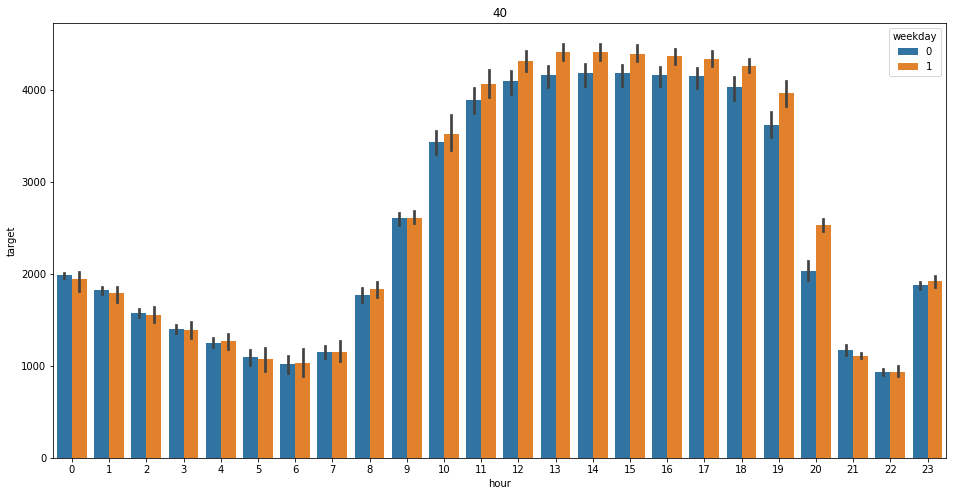

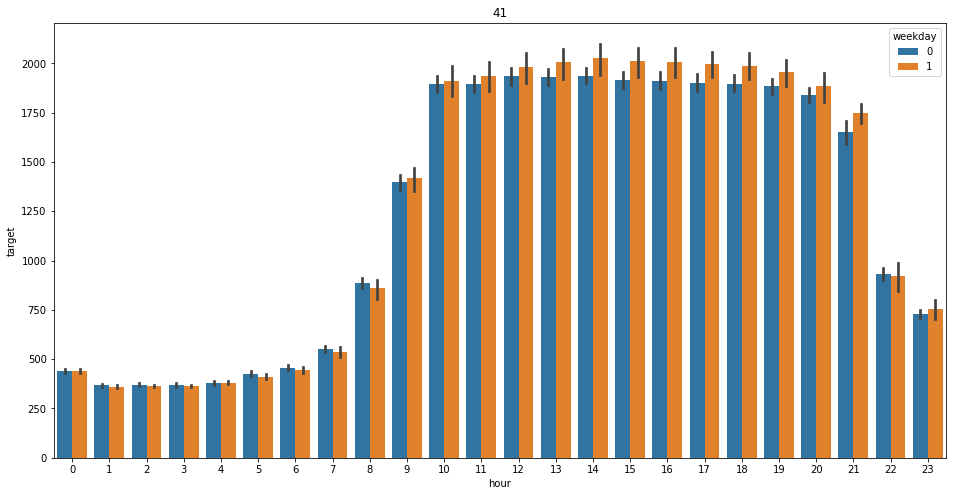

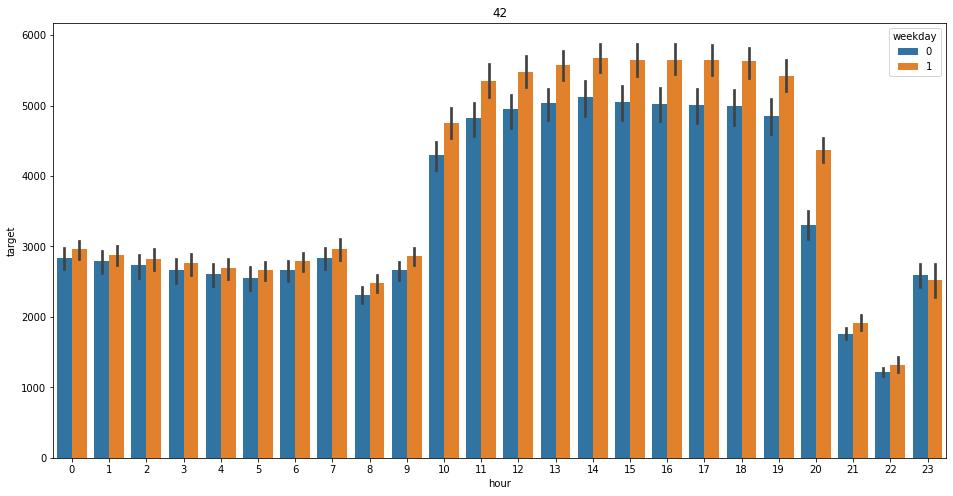

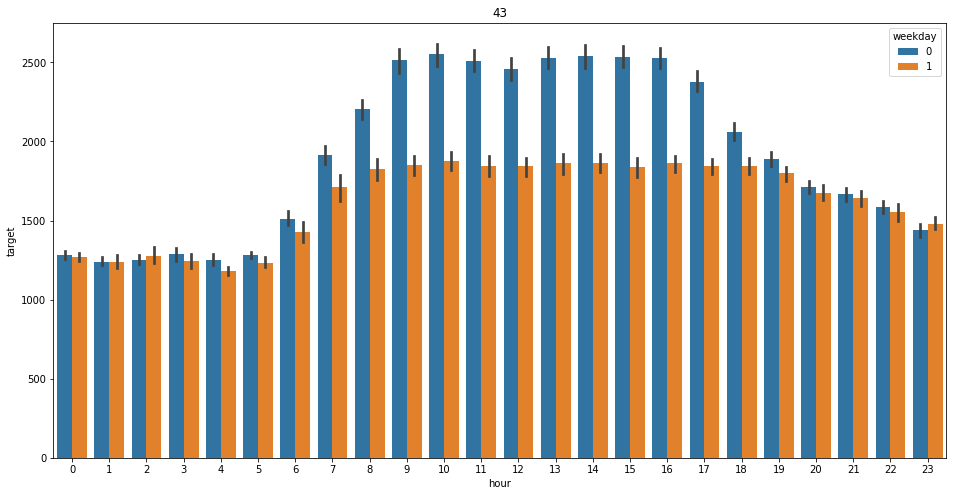

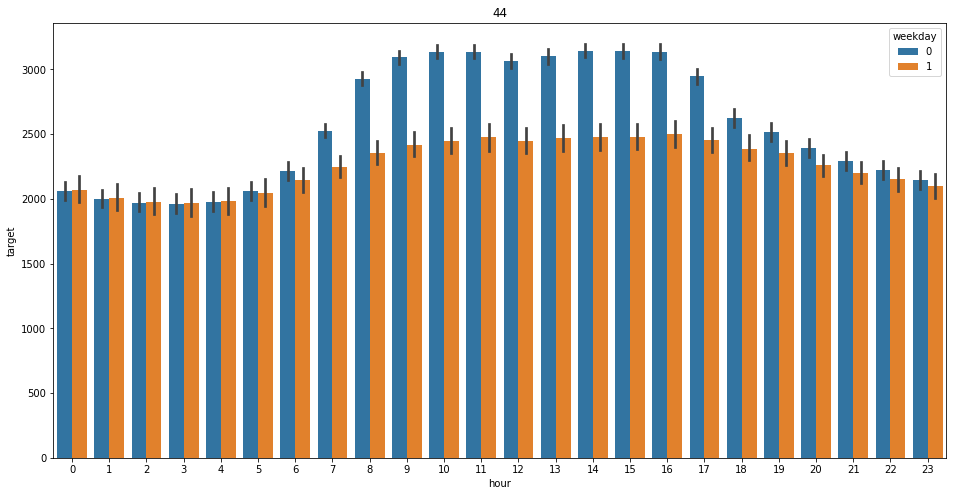

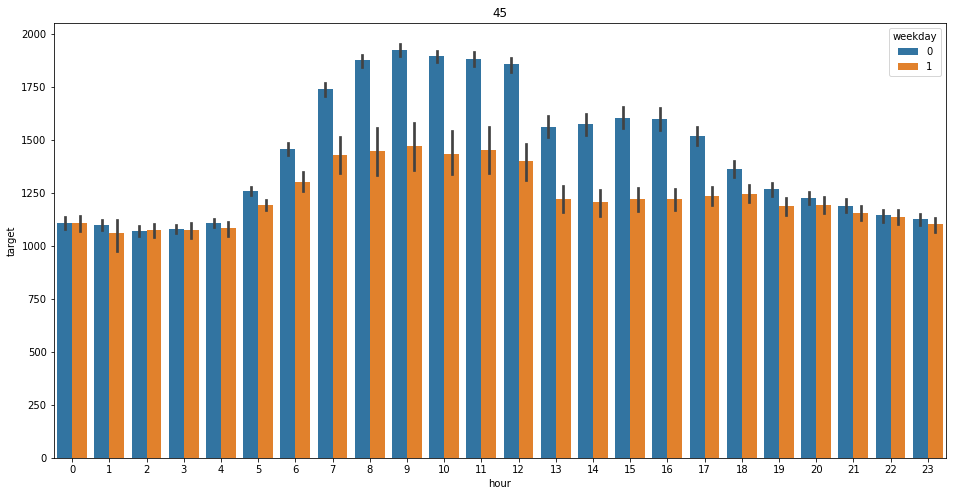

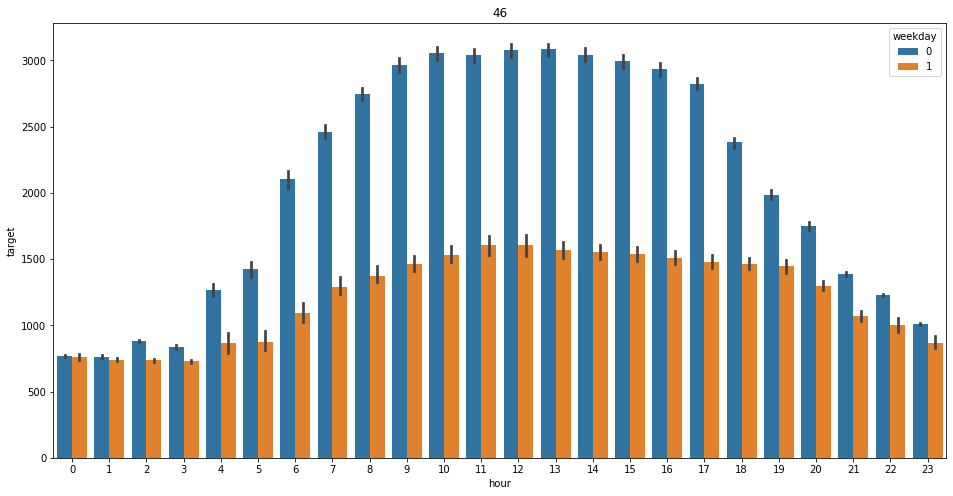

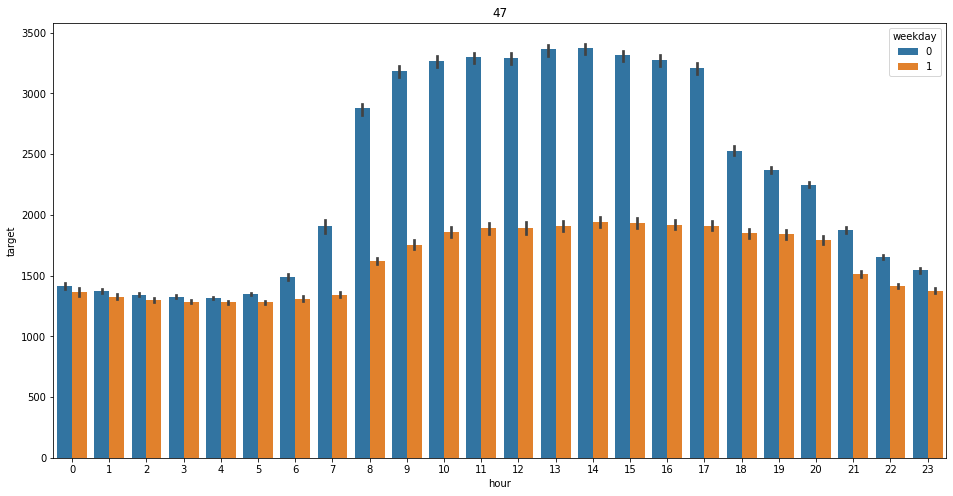

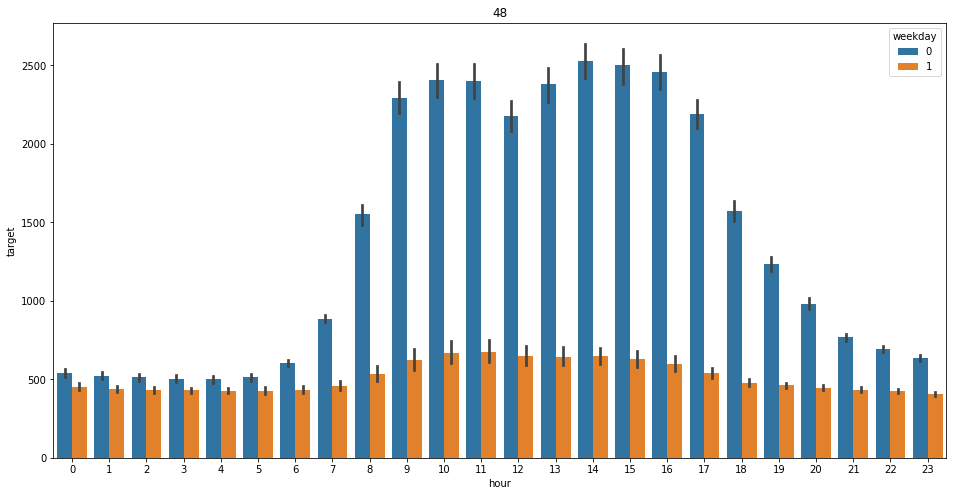

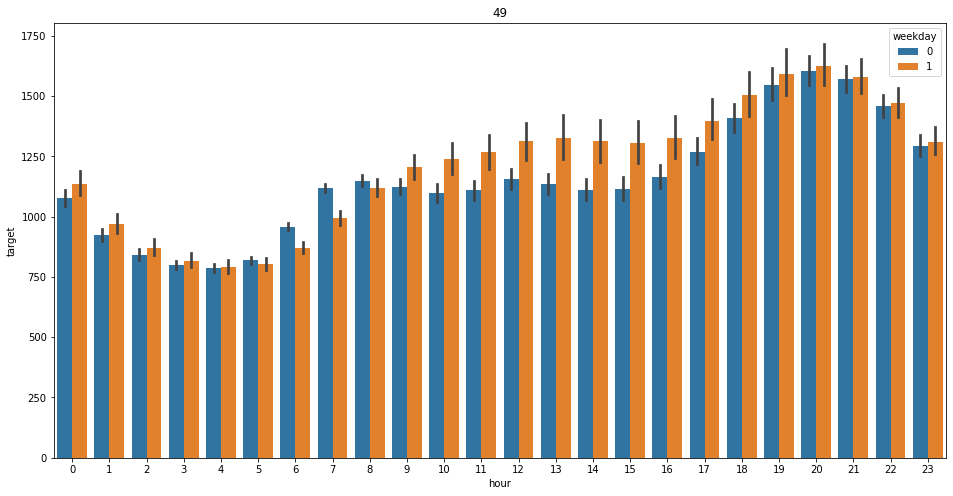

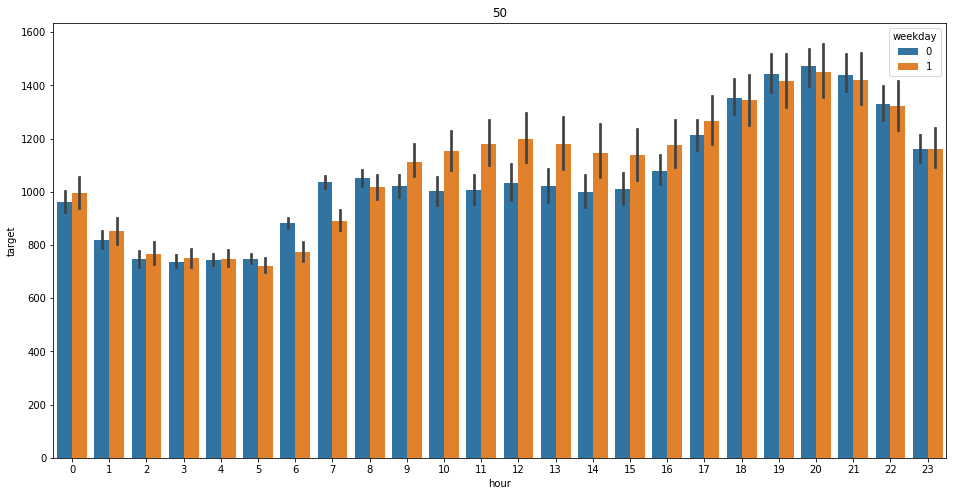

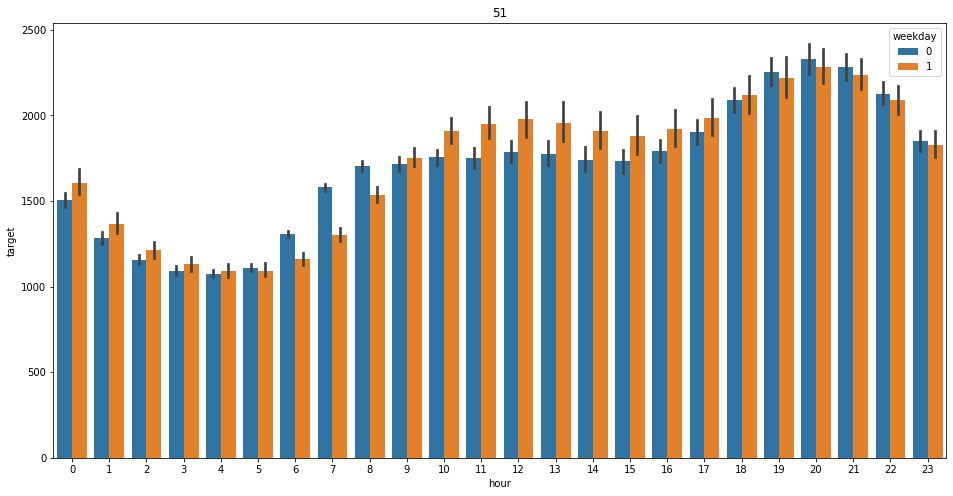

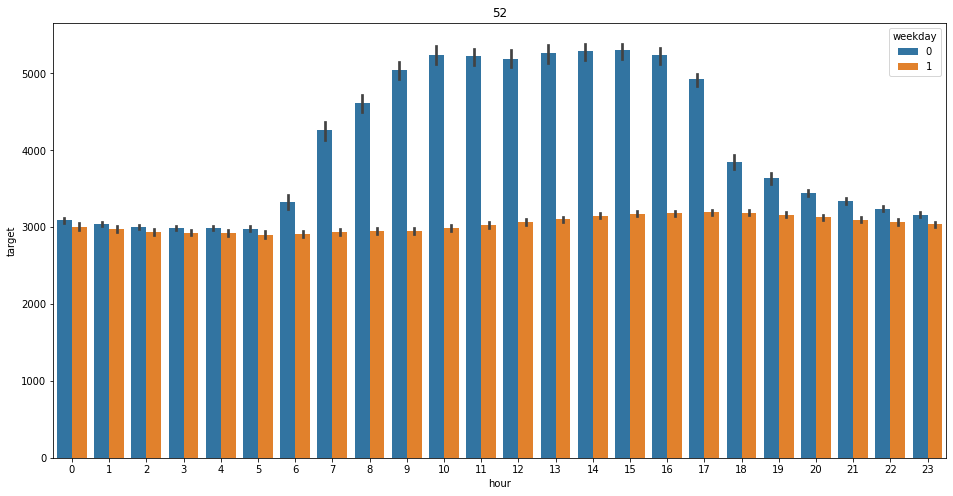

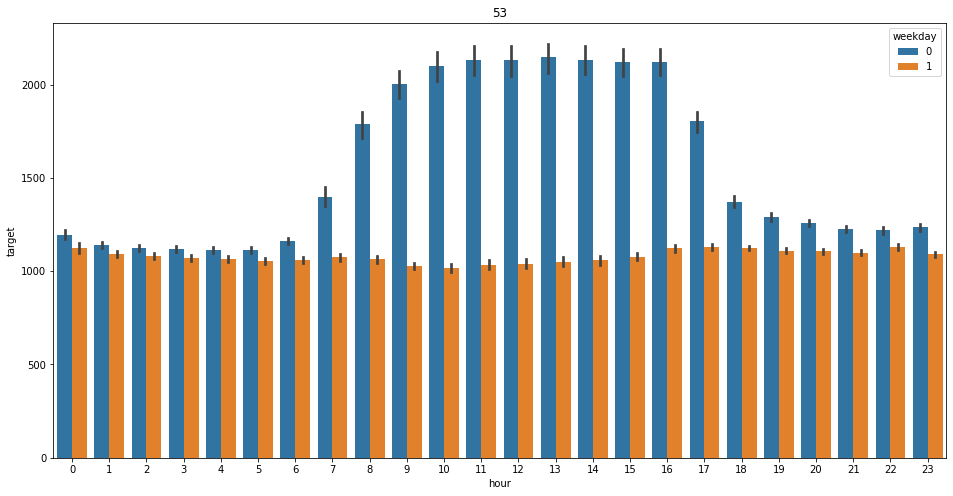

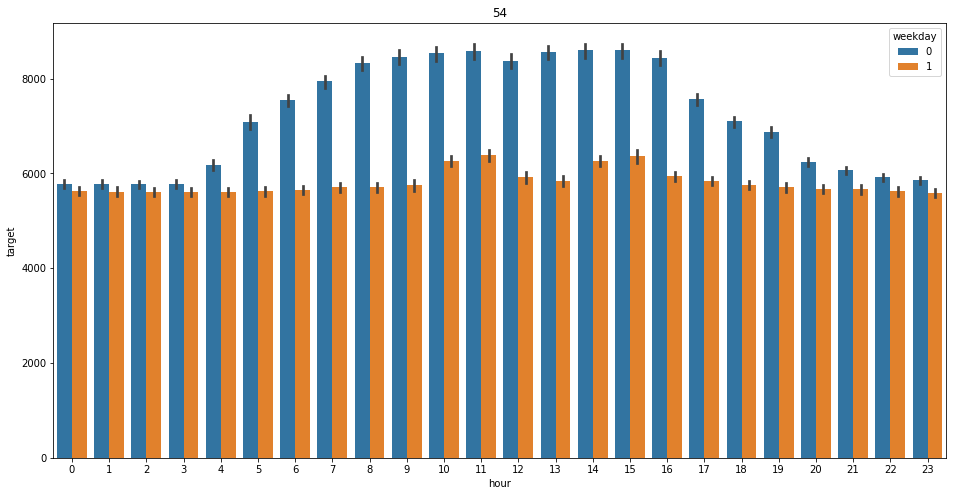

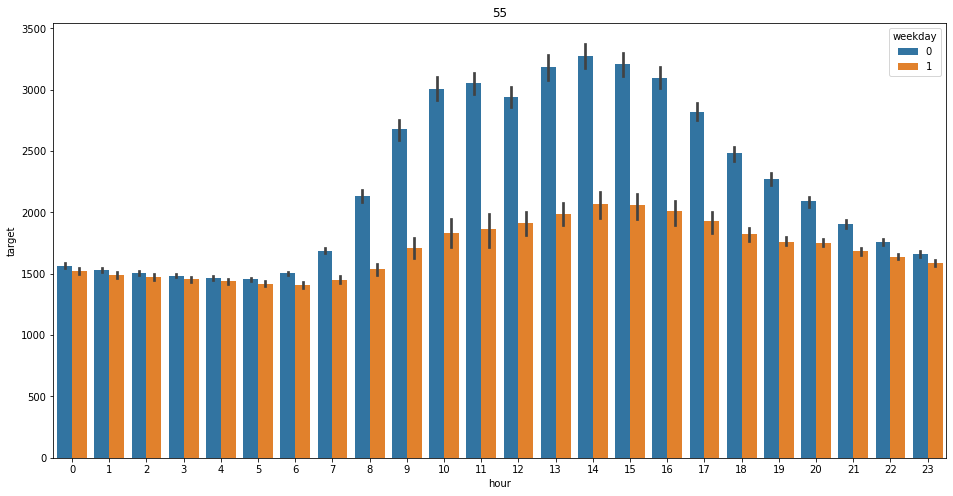

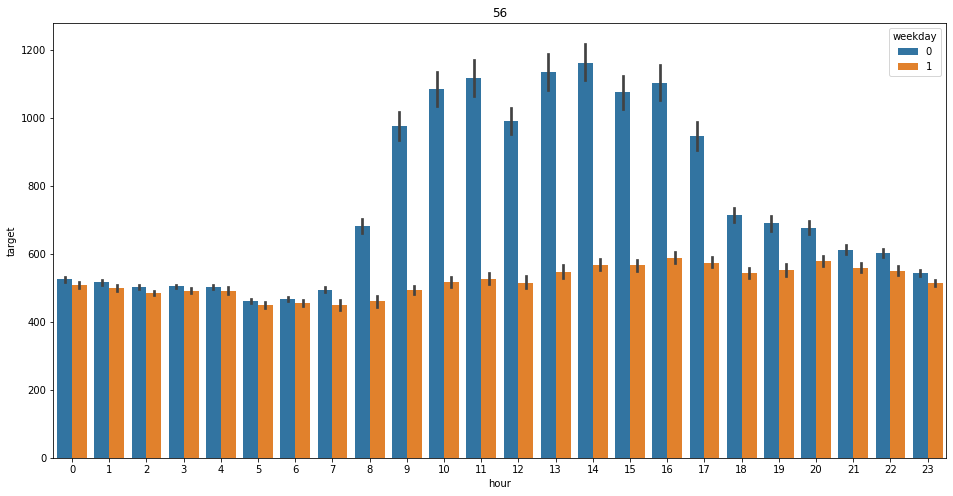

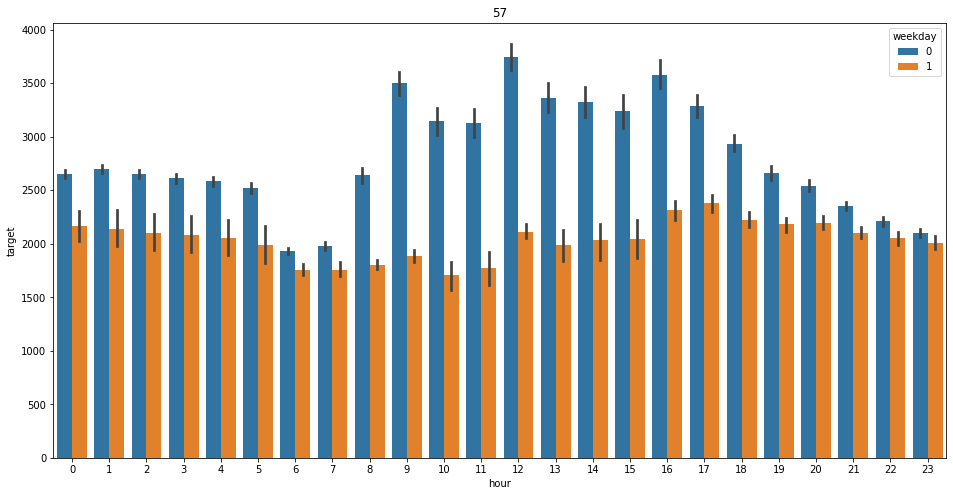

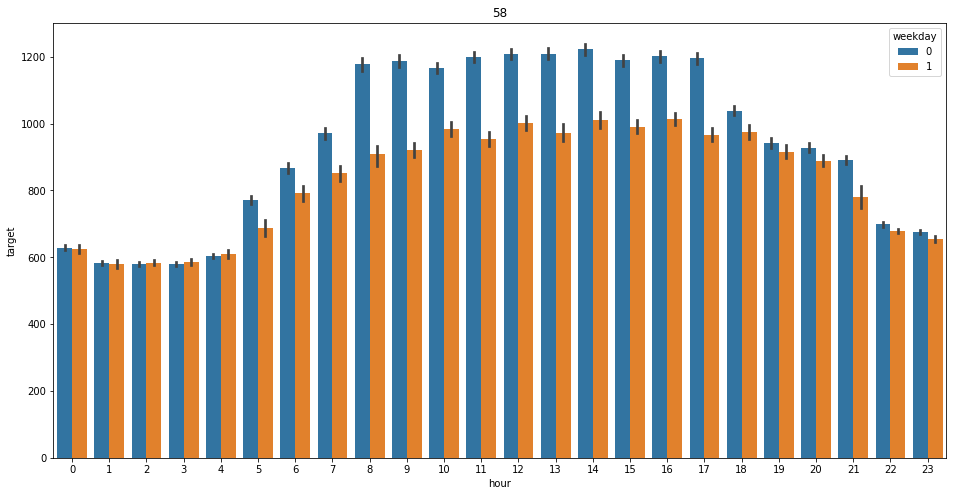

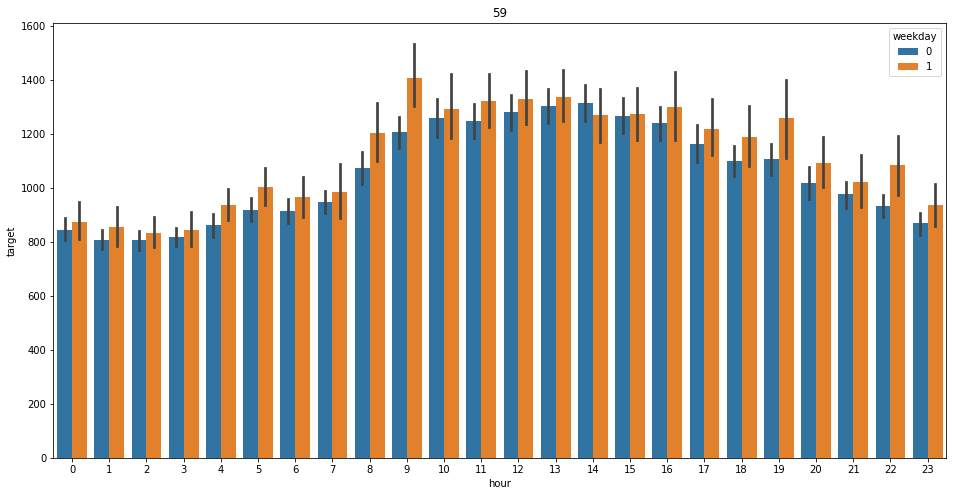

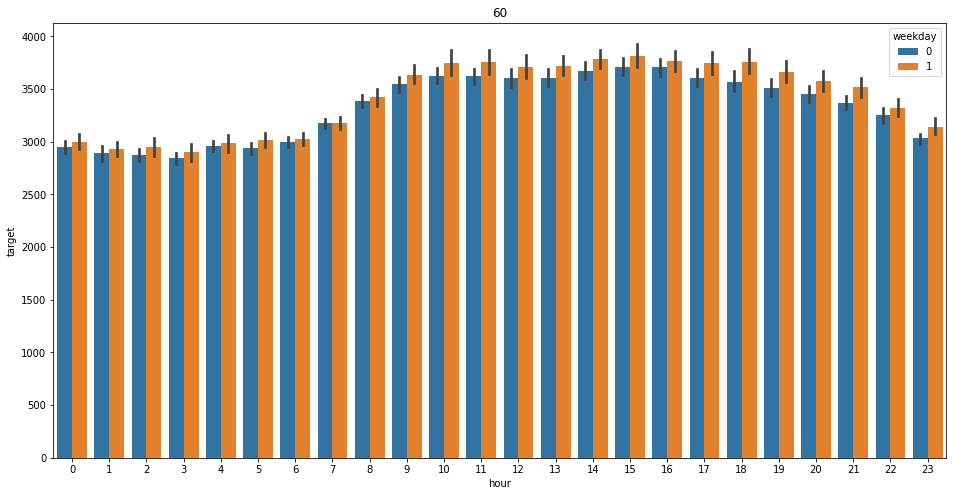

In [61]:
# 각 건물별 시간과 주말에 따른 target
for i in train['num'].unique():
  plt.figure(figsize = (16,8))
  sns.barplot(data = train[train['num'] == i], x = 'hour', y = 'target', hue = 'weekday')
  plt.title(f'{i}')
  plt.show()

In [62]:
# 데이터에 shape이 맞는지 확인한다.
print(train.columns)
print(test.columns)

Index(['num', 'date_time', 'target', 'Temperatures', 'Wind speed', 'Humidity',
       'Precipitation', 'sunshine', '비전기냉방설비운영', '태양광보유', 'log_target',
       'month', 'day', 'hour', 'weekday', 'weekend', 'date', 'new_column',
       '열지수', '불쾌지수', '냉방도일'],
      dtype='object')
Index(['num', 'date_time', 'Temperatures', 'Wind speed', 'Humidity',
       'Precipitation', 'sunshine', '비전기냉방설비운영', '태양광보유', 'month', 'day',
       'hour', 'weekday', 'weekend', 'date', '열지수', '불쾌지수', 'new_column',
       '냉방도일'],
      dtype='object')


In [63]:
# 우리는 모델을 num별로 돌려줄 예정이다.
# 데이터를 살펴보면 12와 13에 target이 줄어드는 경향이 있다. 그것을 lunch_time으로 나타내주자.
train.loc[(train['hour'] == 12) | (train['hour'] == 13), 'lunch_time'] = 1
test.loc[(test['hour'] == 12) | (test['hour'] == 13), 'lunch_time'] = 1
train = train.fillna(0)
test = test.fillna(0)

# train 각 num별로 리스트에 담는다.
a = []
for i in train['num'].unique():
  a.append(train[train['num'] == i])

# test 각 num 별로 리스트에 담는다.
b = []
for i in test['num'].unique():
  b.append(test[test['num'] == i])

# num별로 주말과 평일에 차이가 나는 부분을 binning화 해주자.
# num = 2
a[1]['working'] = a[1]['hour'].apply(lambda x:1 if ((6 <= x) & (x <= 20))  else 0)
b[1]['working'] = b[1]['hour'].apply(lambda x:1 if ((6 <= x) & (x <= 20))  else 0)

# num = 4
a[3]['working'] = a[3]['hour'].apply(lambda x:1 if ((8 <= x) & (x <= 21)) else 0)
b[3]['working'] = b[3]['hour'].apply(lambda x:1 if ((8 <= x) & (x <= 21)) else 0)

# num = 5
a[4]['working'] = a[4]['hour'].apply(lambda x:1 if ((5 <= x) & (x <= 18)) else 0)
b[4]['working'] = b[4]['hour'].apply(lambda x:1 if ((5 <= x) & (x <= 18)) else 0)


# num = 6
a[5]['working'] = a[5]['hour'].apply(lambda x:1 if ((7 <= x) & (x <= 21)) else 0)
b[5]['working'] = b[5]['hour'].apply(lambda x:1 if ((7 <= x) & (x <= 21)) else 0)

# num = 7
a[6]['working'] = a[6]['hour'].apply(lambda x:1 if ((3 <= x) & (x <= 22)) else 0)
b[6]['working'] = b[6]['hour'].apply(lambda x:1 if ((3 <= x) & (x <= 22)) else 0)

# num = 8
a[7]['working'] = a[7]['hour'].apply(lambda x:1 if ((6 <= x) & (x <= 22)) else 0)
b[7]['working'] = b[7]['hour'].apply(lambda x:1 if ((6 <= x) & (x <= 22)) else 0)

# num = 10
a[9]['working'] = a[9]['hour'].apply(lambda x:1 if ((8 <= x) & (x <= 21)) else 0)
b[9]['working'] = b[9]['hour'].apply(lambda x:1 if ((8 <= x) & (x <= 21)) else 0)

# num = 11
a[10]['working'] = a[10]['hour'].apply(lambda x:1 if ((9 <= x) & (x <= 21)) else 0)
b[10]['working'] = b[10]['hour'].apply(lambda x:1 if ((9 <= x) & (x <= 21)) else 0)

# num = 12
a[11]['working'] = a[11]['hour'].apply(lambda x:1 if ((8 <= x) & (x <= 21)) else 0)
b[11]['working'] = b[11]['hour'].apply(lambda x:1 if ((8 <= x) & (x <= 21)) else 0)

# num = 13 
a[12]['working'] = a[12]['hour'].apply(lambda x:1 if ((6 <= x) & (x <= 19)) else 0)
b[12]['working'] = b[12]['hour'].apply(lambda x:1 if ((6 <= x) & (x <= 19)) else 0)

# num = 14
a[13]['working'] = a[13]['hour'].apply(lambda x:1 if ((6 <= x) & (x <= 19)) else 0)
b[13]['working'] = b[13]['hour'].apply(lambda x:1 if ((6 <= x) & (x <= 19)) else 0)

# num = 15
a[14]['working'] = a[14]['hour'].apply(lambda x:1 if ((7 <= x) & (x <= 18)) else 0)
b[14]['working'] = b[14]['hour'].apply(lambda x:1 if ((7 <= x) & (x <= 18)) else 0)

# num = 16
a[15]['working'] = a[15]['hour'].apply(lambda x:1 if ((6 <= x) & (x <= 19)) else 0)
b[15]['working'] = b[15]['hour'].apply(lambda x:1 if ((6 <= x) & (x <= 19)) else 0)

# num = 17
a[16]['working'] = a[16]['hour'].apply(lambda x:1 if ((5 <= x) & (x <= 22)) else 0)
b[16]['working'] = b[16]['hour'].apply(lambda x:1 if ((5 <= x) & (x <= 22)) else 0)

# num = 18
a[17]['working'] = a[17]['hour'].apply(lambda x:1 if ((7 <= x) & (x <= 22)) else 0)
b[17]['working'] = b[17]['hour'].apply(lambda x:1 if ((7 <= x) & (x <= 22)) else 0)

# num = 19
a[18]['working'] = a[18]['hour'].apply(lambda x:1 if ((6 <= x) & (x <= 8)) else 0)
b[18]['working'] = b[18]['hour'].apply(lambda x:1 if ((6 <= x) & (x <= 8)) else 0)

# num = 20
a[19]['working'] = a[19]['hour'].apply(lambda x:1 if ((6 <= x) & (x <= 8)) else 0)
b[19]['working'] = b[19]['hour'].apply(lambda x:1 if ((6 <= x) & (x <= 8)) else 0)

# num = 21
a[20]['working'] = a[20]['hour'].apply(lambda x:1 if ((6 <= x) & (x <= 8)) else 0)
b[20]['working'] = b[20]['hour'].apply(lambda x:1 if ((6 <= x) & (x <= 8)) else 0)

# num = 22
a[21]['working'] = a[21]['hour'].apply(lambda x:1 if ((7 <= x) & (x <= 19)) else 0)
b[21]['working'] = b[21]['hour'].apply(lambda x:1 if ((7 <= x) & (x <= 19)) else 0)

# num = 23 
a[22]['working'] = a[22]['hour'].apply(lambda x:1 if ((7 <= x) & (x <= 19)) else 0)
b[22]['working'] = b[22]['hour'].apply(lambda x:1 if ((7 <= x) & (x <= 19)) else 0)

# num = 24
a[23]['working'] = a[23]['hour'].apply(lambda x:1 if ((7 <= x) & (x <= 19)) else 0)
b[23]['working'] = b[23]['hour'].apply(lambda x:1 if ((7 <= x) & (x <= 19)) else 0)

# num = 25
a[24]['working'] = a[24]['hour'].apply(lambda x:1 if ((7 <= x) & (x <= 19)) else 0)
b[24]['working'] = b[24]['hour'].apply(lambda x:1 if ((7 <= x) & (x <= 19)) else 0)

# num = 26
a[25]['working'] = a[25]['hour'].apply(lambda x:1 if ((8 <= x) & (x <= 19)) else 0)
b[25]['working'] = b[25]['hour'].apply(lambda x:1 if ((8 <= x) & (x <= 19)) else 0)

# num = 27
a[26]['working'] = a[26]['hour'].apply(lambda x:1 if ((8 <= x) & (x <= 20)) else 0)
b[26]['working'] = b[26]['hour'].apply(lambda x:1 if ((8 <= x) & (x <= 20)) else 0)

# num = 31
a[30]['working'] = a[30]['hour'].apply(lambda x:1 if ((6 <= x) & (x <= 18)) else 0)
b[30]['working'] = b[30]['hour'].apply(lambda x:1 if ((6 <= x) & (x <= 18)) else 0)

# num = 33
a[32]['working'] = a[32]['hour'].apply(lambda x:1 if ((8 <= x) & (x <= 18)) else 0)
b[32]['working'] = b[32]['hour'].apply(lambda x:1 if ((8 <= x) & (x <= 18)) else 0)

# num = 34
a[33]['working'] = a[33]['hour'].apply(lambda x:1 if ((18 <= x) & (x <= 19)) else 0)
b[33]['working'] = b[33]['hour'].apply(lambda x:1 if ((18 <= x) & (x <= 19)) else 0)

# num = 35
a[34]['working'] = a[34]['hour'].apply(lambda x:1 if ((7 <= x) & (x <= 19)) else 0)
b[34]['working'] = b[34]['hour'].apply(lambda x:1 if ((7 <= x) & (x <= 19)) else 0)

# num = 37
a[36]['working'] = a[36]['hour'].apply(lambda x:1 if ((6 <= x) & (x <= 18)) else 0)
b[36]['working'] = b[36]['hour'].apply(lambda x:1 if ((6 <= x) & (x <= 18)) else 0)

# num = 38
a[37]['working'] = a[37]['hour'].apply(lambda x:1 if ((7 <= x) & (x <= 18)) else 0)
b[37]['working'] = b[37]['hour'].apply(lambda x:1 if ((7 <= x) & (x <= 18)) else 0)

# num = 39
a[38]['working'] = a[38]['hour'].apply(lambda x:1 if ((8 <= x) & (x <= 18)) else 0)
b[38]['working'] = b[38]['hour'].apply(lambda x:1 if ((8 <= x) & (x <= 18)) else 0)

# num = 40
a[39]['working'] = a[39]['hour'].apply(lambda x:1 if ((10 <= x) & (x <= 20)) else 0)
b[39]['working'] = b[39]['hour'].apply(lambda x:1 if ((10 <= x) & (x <= 20)) else 0)

# num = 41
a[40]['working'] = a[40]['hour'].apply(lambda x:1 if ((9 <= x) & (x <= 21)) else 0)
b[40]['working'] = b[40]['hour'].apply(lambda x:1 if ((9 <= x) & (x <= 21)) else 0)

# num = 42
a[41]['working'] = a[41]['hour'].apply(lambda x:1 if ((10 <= x) & (x <= 20)) else 0)
b[41]['working'] = b[41]['hour'].apply(lambda x:1 if ((10 <= x) & (x <= 20)) else 0)

# num = 43
a[42]['working'] = a[42]['hour'].apply(lambda x:1 if ((7 <= x) & (x <= 18)) else 0)
b[42]['working'] = b[42]['hour'].apply(lambda x:1 if ((7 <= x) & (x <= 18)) else 0)

# num = 44
a[43]['working'] = a[43]['hour'].apply(lambda x:1 if ((7 <= x) & (x <= 18)) else 0)
b[43]['working'] = b[43]['hour'].apply(lambda x:1 if ((7 <= x) & (x <= 18)) else 0)

# num = 45
a[44]['working'] = a[44]['hour'].apply(lambda x:1 if ((6 <= x) & (x <= 17)) else 0)
b[44]['working'] = b[44]['hour'].apply(lambda x:1 if ((6 <= x) & (x <= 17)) else 0)

# num = 46
a[45]['working'] = a[45]['hour'].apply(lambda x:1 if ((4 <= x) & (x <= 21)) else 0)
b[45]['working'] = b[45]['hour'].apply(lambda x:1 if ((4 <= x) & (x <= 21)) else 0)

# num = 47
a[46]['working'] = a[46]['hour'].apply(lambda x:1 if ((7 <= x) & (x <= 21)) else 0)
b[46]['working'] = b[46]['hour'].apply(lambda x:1 if ((7 <= x) & (x <= 21)) else 0)

# num = 48
a[47]['working'] = a[47]['hour'].apply(lambda x:1 if ((7 <= x) & (x <= 23)) else 0)
b[47]['working'] = b[47]['hour'].apply(lambda x:1 if ((7 <= x) & (x <= 23)) else 0)

# num = 49 
a[48]['working'] = a[48]['hour'].apply(lambda x:1 if ((5 <= x) & (x <= 8)) else 0)
b[48]['working'] = b[48]['hour'].apply(lambda x:1 if ((5 <= x) & (x <= 8)) else 0)

# num = 50 
a[49]['working'] = a[49]['hour'].apply(lambda x:1 if ((6 <= x) & (x <= 8)) else 0)
b[49]['working'] = b[49]['hour'].apply(lambda x:1 if ((6 <= x) & (x <= 8)) else 0)

# num = 51 
a[50]['working'] = a[50]['hour'].apply(lambda x:1 if ((6 <= x) & (x <= 8)) else 0)
b[50]['working'] = b[50]['hour'].apply(lambda x:1 if ((6 <= x) & (x <= 8)) else 0)

# num = 52
a[51]['working'] = a[51]['hour'].apply(lambda x:1 if ((7 <= x) & (x <= 16)) else 0)
b[51]['working'] = b[51]['hour'].apply(lambda x:1 if ((7 <= x) & (x <= 16)) else 0)

# num = 53
a[52]['working'] = a[52]['hour'].apply(lambda x:1 if ((7 <= x) & (x <= 18)) else 0)
b[52]['working'] = b[52]['hour'].apply(lambda x:1 if ((7 <= x) & (x <= 18)) else 0)

# num = 54
a[53]['working'] = a[53]['hour'].apply(lambda x:1 if ((5 <= x) & (x <= 19)) else 0)
b[53]['working'] = b[53]['hour'].apply(lambda x:1 if ((5 <= x) & (x <= 19)) else 0)

# num = 55
a[54]['working'] = a[54]['hour'].apply(lambda x:1 if ((8 <= x) & (x <= 20)) else 0)
b[54]['working'] = b[54]['hour'].apply(lambda x:1 if ((8 <= x) & (x <= 20)) else 0)

# num = 56
a[55]['working'] = a[55]['hour'].apply(lambda x:1 if ((8 <= x) & (x <= 19)) else 0)
b[55]['working'] = b[55]['hour'].apply(lambda x:1 if ((8 <= x) & (x <= 19)) else 0)

# num = 57
a[56]['working'] = a[56]['hour'].apply(lambda x:1 if ((8 <= x) & (x <= 17)) else 0)
b[56]['working'] = b[56]['hour'].apply(lambda x:1 if ((8 <= x) & (x <= 17)) else 0)

# num = 58
a[57]['working'] = a[57]['hour'].apply(lambda x:1 if ((5 <= x) & (x <= 18)) else 0)
b[57]['working'] = b[57]['hour'].apply(lambda x:1 if ((5 <= x) & (x <= 18)) else 0)
# ============================= 시간으로 범주화 끝 ===========================================================
# dayofyear보다 month를 넣는게 더 좋은 결과를 나타낸다.
# # 더미화를 원래 하던 방식대로 진행해 주자.
dummies = ['weekday','hour'] # day는 제거해줘야 하는 변수고, month는 달이 오를수록 target변수가 오르므로 그냥 제거해주지 않고 써주도록 하자.
drop_columns_train = ['day','date_time','비전기냉방설비운영','태양광보유','num','target','Wind speed','sunshine','냉방도일','Precipitation','new_column','weekend','date']
for index,train_num in enumerate(a):
  a[index] = pd.get_dummies(data = a[index] , columns = dummies)
  a[index] = a[index].drop(drop_columns_train, axis = 1)

# 더미화를 원래 하던 방식대로 진행해 주자.
dummies = ['weekday','hour'] # day는 제거해줘야 하는 변수고, month는 달이 오를수록 target변수가 오르므로 그냥 제거해주지 않고 써주도록 하자.
drop_columns_test = ['day','date_time','비전기냉방설비운영','태양광보유','num','Wind speed','sunshine','냉방도일','Precipitation','new_column','weekend','date']
for index,test_num in enumerate(b):
  b[index] = pd.get_dummies(data = b[index] , columns = dummies)
  b[index] = b[index].drop(drop_columns_test, axis = 1)

In [64]:
print(len(a[0].columns), len(a[1].columns))

33 34


# rmse가 높게 나오는 모델들

In [65]:
# from lightgbm import LGBMRegressor
# from catboost import CatBoostRegressor
# from xgboost import XGBRegressor
# from sklearn.model_selection import KFold, GridSearchCV, train_test_split
# from sklearn.linear_model import LinearRegression, Ridge, Lasso

# # # xgboost regressor로 돌려보자.
# from xgboost import XGBRegressor
# xgb = XGBRegressor()
# final_y_pred = []
# for i in range(len(a)):
#   xgb.fit(a[i].drop('log_target', axis = 1), a[i]['log_target'])
#   y_pred = xgb.predict(b[i])
#   final_y_pred.append(y_pred)

# 끄악 = []
# for y_pred in final_y_pred:
#   for j in y_pred:
#     끄악.append(j)

# xgb_pred = pd.DataFrame(끄악, columns = ['xgb_pred'])
# xgb_pred = xgb_pred['xgb_pred'].apply(lambda x: np.exp(x) - 1)

# # submission['answer'] = y_pred
# # submission.to_csv('submission.csv',index= False)
# # print(submission)

In [66]:
# 8.35955
# # 점수가 너무 안나왔으므로 패기한다.
# from lightgbm import LGBMRegressor
# from sklearn.model_selection import KFold, GridSearchCV, train_test_split
# from tqdm import tqdm

# # LightGBM을 GridSearchCV를 이용하여 각 건물마다 모델들을 파라미터 최적화를 실행해 준다.
# param_grid = {
#     'max_depth' : [12,14,16,18,20],
#     'learning_rate': [0.1,0.01,0.03,0.05],
#     'n_estimators': [100,150,200,250,300]
# }

# # GridSearchCV에 넣을 것들을 만든다.
# cv = KFold(n_splits = 5, shuffle = True)
# model = LGBMRegressor(random_state = 42)
# lgb_gcv = GridSearchCV(estimator = model, param_grid = param_grid, cv = cv, scoring = 'neg_mean_squared_log_error' )

# # final_y_pred는 각 건물마다 y_pred를 담는다.
# final_y_pred = []

# # a는 각 건물들의 정보를 리스트 형태로 저장한 것이다.
# for i in tqdm(range(len(a))):
#   # 각 건물마다 GridSearCV를 이용한다
#   lgb_gcv.fit(a[i].drop('log_target', axis  = 1), a[i]['log_target'])
#   # 각 건물마다의 모델로 test의 각 건물의 전력량을 예측한다.
#   y_pred = lgb_gcv.best_estimator_.predict(b[i])
#   # 예측값들을 전부 final_y_pred에 쌓아준다.
#   final_y_pred.append(y_pred)
  
# # 각 예측값들을 한 리스트로 정리하기 위해서 리스트를 만들어준다.
# 끄악 = []
# # final_y_pred는 각 건물마다의 예측값들이 들어있으므로 그것을 각 건물의 예측값을 뽑아내서
# for y_pred in final_y_pred:
#   # 그 건물마다의 예측값들을 다시 예측값으로 뽑아내고
#   for j in y_pred:
#     # 그것을 리스트에 순서대로 저장시킨다.
#     끄악.append(j)

# # 우리는 회귀분석을 이용하기 때문에 원래 로그를 씌워줬던 데이터를 풀어준다.
# y_pred = pd.DataFrame(끄악, columns = ['y_pred'])
# y_pred = y_pred['y_pred'].apply(lambda x: np.exp(x) - 1)

# # 데이터를 csv에 저장한다.
# submission['answer'] = y_pred
# submission.to_csv('submission.csv',index= False)

In [67]:
# submission

In [68]:
# 너무 오래걸리는 모델이라 패스한다.
# GridSearchCV를 이용하여 각 건물마다 모델들을 파라미터 최적화를 실행해 준다.
# from catboost import CatBoostRegressor
# from sklearn.model_selection import KFold, GridSearchCV, train_test_split
# # GridSearchCV를 이용하여 각 건물마다 모델들을 파라미터 최적화를 실행해 준다.
# param_grid = {
#     'learning_rate' : [0.1,0.01,0.03,0.05],
#     'iterations' : [100],
#     'l2_leaf_reg' : [20,40,60],
#     'depth' : [6,8,10]
# }
# cv = KFold(n_splits = 5, shuffle = True, random_state = 42)
# cat = CatBoostRegressor(random_state = 42,task_type = 'GPU')
# cat_gcv = GridSearchCV(estimator=cat, param_grid = param_grid, cv = cv, scoring = 'neg_mean_squared_log_error')

# # final_y_pred는  각 건물마다 y_pred를 담는다.
# final_y_pred = []
# # a는 각 건물들의 정보를 리스트 형태로 저장한 것이다.
# for i in range(len(a)):
#   # 각 건물마다 GridSearchCV를 이용한다.
#   cat_gcv.fit(a[i].drop('log_target', axis = 1), a[i]['log_target'])
#   # 각 건물마다 모델을 model에 저장해준다.
#   model = cat_gcv.best_estimator_
#   # 각 건물마다의 모델로 test의 건물들을 예측한다.
#   y_pred = model.predict(b[i])
#   # 예측값들을 전부 final_y_pred에 쌓아준다.
#   final_y_pred.append(y_pred)

# # 각 예측값들을 한 리스트로 정리하기 위해서 리스트를 만들어준다.
# 끄악 = []
# # final_y_pred는 각 건물마다의 예측값들이 들어있으므로 그것을 각 건물의 예측값을 뽑아내서
# for y_pred in final_y_pred:
#   # 그 건물마다의 예측값들을 다시 예측값으로 뽑아내고
#   for j in y_pred:
#     # 그것을 리스트에 순서대로 저장시킨다.
#     끄악.append(j)

# # 우리는 회귀분석을 이용하기 때문에 원래 로그를 씌워줬던 데이터를 풀어준다.
# y_pred = pd.DataFrame(끄악, columns = ['y_pred'])
# y_pred = y_pred['y_pred'].apply(lambda x: np.exp(x) - 1)

# # 데이터를 csv에 저장한다.
# submission['answer'] = y_pred
# submission.to_csv('submission.csv',index= False)

In [69]:
# # lightgbm
# # lgb=LGBMRegressor(random_state = 42)
# # lgb.fit(train_data, target)
# # y_pred=lgb.predict(test_data)


# # # catboost
# catboost = CatBoostRegressor(random_state= 42)
# catboost.fit(train_data, target)
# y_pred=catboost.predict(test_data)

# # # # xgboost
# # xgb = XGBRegressor(random_state = 42)
# # xgb.fit(train_data, target)
# # y_pred=xgb.predict(test_data)

# y_pred = pd.DataFrame(y_pred, columns = ['y_pred'])
# y_pred = y_pred.apply(lambda x:np.exp(x) - 1)
# submission['answer'] = y_pred
# submission.to_csv('C:/Users/lg/전력사용량 예측 AI 경진대회/submission.csv',index= False)

# LSTM

In [70]:
# train = train.drop('log_target', axis = 1)

# print(train.columns)
# print(test.columns)

# !pip install tslearn

# from sklearn.cluster import KMeans
# # min_max_scaling
# for i in range(1, 61):
#     mean_ = train.loc[train.num == i].target.mean()
#     std_ = train.loc[train.num == i].target.std()
#     train.loc[train.num == i, 'scale_target'] = ((train.loc[train.num == i, 'target']) - mean_) / std_

# # 요일에 따른 평균 값 산출
# weekday_mean = (
#     train.groupby(['num', 'weekend'])['scale_target'].mean()
#     .reset_index()
#     .pivot('num', 'weekend', 'scale_target')
#     .reset_index())

# # 시간에 따른 평균 값 산출
# hour_mean = (train.groupby(['num', 'hour'])['scale_target'].mean().reset_index().pivot('num', 'hour', 'scale_target').reset_index().drop('num', axis=1))

# # 요일별, 시간별 평균 전력 사용량 테이블 구축
# cl_df = pd.concat([weekday_mean, hour_mean], axis=1)


# # # 보기 편하게 컬럼 이름 지정
# columns = (
#     ['num']
#     + ['day_mean_' + str(i) for i in range(7)]
#     + ['hour_mean_' + str(i) for i in range(24)]
# )

# cl_df.columns = columns

# model = KMeans(n_clusters = 4, random_state = 42)
# pred = model.fit_predict(cl_df.iloc[:, 1:])

# cl_df['km_cluster'] = pred

# train = pd.merge(train,cl_df[['num','km_cluster']], how = 'left', on = 'num')

# for i in range(1, 61):
#     test.loc[test.num == i, 'km_cluster'] = (train.loc[train.num == i, 'km_cluster'].max())

# train.drop('scale_target', axis = 1, inplace = True)

#######딥러닝 라이브러리##########
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, LSTM, Reshape, GRU, RNN,Dropout
# import keras.backend as K
# train.drop(['date_time','date'], axis = 1, inplace = True)
# test.drop(['date_time', 'date'], axis = 1, inplace = True)

# def SMAPE(true,predicted):
#     epsilon = 0.1
#     summ = K.maximum(K.abs(true) + K.abs(predicted) + epsilon, 0.5 + epsilon)
#     smape = K.abs(predicted - true) / summ * 2.0
#     return smape

# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# numerical = ['Temperatures','Humidity','열지수','냉방도일'] 
# train_scaler= scaler.fit_transform(train[numerical])
# test_scaler = scaler.fit_transform(test[numerical])
# train_scaler = pd.DataFrame(train_scaler)
# test_scaler = pd.DataFrame(test_scaler)
# train = train.drop(numerical, axis = 1)
# test = test.drop(numerical, axis = 1)

# train = pd.concat([train_scaler, train], axis = 1)
# test = pd.concat([test_scaler, test], axis = 1)

# K.clear_session()

# tf.keras.backend.set_floatx('float64')

# final_y_pred = []
# test_size = 200
# window_size = 20

# train_data = pd.DataFrame([])
# train_labels = pd.DataFrame([])
# val_data = pd.DataFrame([])
# val_labels = pd.DataFrame([])
# test_data = pd.DataFrame([])

# for i in train['num'].unique():
#   X_train = train[train['num'] == i][:2040-168].drop(['target'], axis = 1)
#   y_train = train[train['num'] == i][:2040-168]['target'].astype('float32')
#   X_val = train[train['num'] == i][2040-168:].drop(['target'], axis = 1)
#   y_val = train[train['num'] == i][2040-168:].astype('float32')
#   X_test = test[test['num'] == i]

#   train_data = pd.concat([train_data,X_train], axis = 0)
#   train_labels = pd.concat([train_labels,y_train], axis = 0)
#   val_data = pd.concat([val_data,X_val], axis = 0)
#   val_labels = pd.concat([val_labels, y_val], axis = 0)
#   test_data = pd.concat([test_data, X_test], axis = 0)
  

# X_train_t = train_data.astype('int').values.reshape(train_data.shape[0], 19, 1)
# X_val_t = val_data.astype('int').values.reshape(val_data.shape[0], 19,1)
# X_test_t = test_data.astype('int').values.reshape(test_data.shape[0], 19, 1)

# model = Sequential() # Sequential Model
# model.add(LSTM(512, activation='relu', input_shape=(X_train_t.shape[1], X_train_t.shape[2],), return_sequences=True))
# model.add(LSTM(256, activation='relu', return_sequences=False))
# model.add(Dropout(0.2))
# model.add(Dense(128))
# model.add(Dense(64))
# model.add(Dense(32))
# model.add(Dropout(0.3))
# model.add(Dense(1))

# model.compile(loss = SMAPE, optimizer = 'adam', metrics = ['mean_squared_error'])
# model.summary()

# model.fit(X_train_t,train_labels,epochs = 100, batch_size = 512, verbose = 1, validation_data = (X_val_t, val_labels))

# y_pred = model.predict(X_test_t)

# final_y_pred.append(y_pred)

# print(final_y_pred)

## STACKING ENSEMBLE

In [ ]:
!pip install vecstack

In [72]:
print(len(a), len(b))

60 60


In [ ]:
# STACKING ENSEMBLE을 사용하기 위해서 모델을 불러온다.
import tensorflow as tf
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from vecstack import stacking
from tqdm import tqdm
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso


@tf.function
# 평가지표 만들기.
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(np.log(y), np.log(y_pred)))
def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred)))


final_y_pred = []
for i in tqdm(range(len(a))):
  # 모델들을 쌓는다.
  lightgbm = LGBMRegressor(random_state = 42)
  xgboost = XGBRegressor(random_state = 42,tree_method = 'gpu_hist')
  catboost = CatBoostRegressor(random_state =42,task_type = 'GPU')
  rfg = RandomForestRegressor(random_state = 42)
  ridge = Ridge(random_state =42)
  models = [lightgbm, xgboost, catboost, rfg, ridge]

  # n_folds를 3, 5 모두 똑같은 결과가 나온다.
  # random_state를 바꾸어도 모델이 바뀌지는 않는다.
  # 여기서 S_train에 들어오는 값은 a[i].drop('log_target', axis = 1)을 가지고 a[i]['log_target']을 예측한 값들이 S_train에 들어오게 된다.
  S_train, S_test = stacking(models, a[i].drop('log_target', axis = 1), a[i]['log_target'], b[i],
                             regression = True, mode = 'oof_pred_bag',metric = rmse, n_folds = 3,
                             random_state = 42)
  
  # meta_model은 LinearRegression을 사용했다.
  lr = LinearRegression()
  lr.fit(S_train, a[i]['log_target'])
  y_pred = lr.predict(S_test)

  # 그리고 각 num별 예측값을 하나의 리스트에 저장한다.
  final_y_pred.append(y_pred)

# 각 값을 다시 풀어서 리스트에 저장한다.
y_pred = []
for i in final_y_pred:

  for j in i:
    y_pred.append(j)

# 정규화를 위해서 log_target을 예측했고 원래 전력사용량으로 바꿔준다.
y_pred = pd.DataFrame(y_pred, columns = ['y_pred'])
y_pred = y_pred['y_pred'].apply(lambda x:np.exp(x) - 1)

submission['answer'] = y_pred
submission.to_csv('submission.csv', index = False)
print(submission)

# 이동평균법을 이용해서 계산해보기

In [74]:
# 예측한 값을 가지고 test의 target으로 넣어준다.
test['target'] = submission['answer']
test['log_target'] = test['target'].apply(lambda x: np.log1p(x))

# 그리고 train과 test를 csv로 저장하고 다시 불러와서 데이터 분석을 진행해 주자.
test.to_csv('/content/drive/MyDrive/데이콘/전력사용량 예측/이동평균_test.csv', index = False)
train.to_csv('/content/drive/MyDrive/데이콘/전력사용량 예측/이동평균_train.csv', index = False)

In [75]:
# 이동평균을 사용할 데이터 가져오기.
train = pd.read_csv('/content/drive/MyDrive/데이콘/전력사용량 예측/이동평균_train.csv')
test = pd.read_csv('/content/drive/MyDrive/데이콘/전력사용량 예측/이동평균_test.csv')

In [76]:
train.head()

,num,date_time,target,Temperatures,Wind speed,Humidity,Precipitation,sunshine,비전기냉방설비운영,태양광보유,log_target,month,day,hour,weekday,weekend,date,new_column,열지수,불쾌지수,냉방도일,lunch_time
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,9.009454,6,1,0,0,0,2020-06-01,0.0,62.6,63.43008,-8.4,0.0
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,9.004133,6,1,1,0,0,2020-06-01,0.0,63.4,63.56993,-16.7,0.0
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,9.000622,6,1,2,0,0,2020-06-01,0.0,63.4,63.22775,-25.2,0.0
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,8.993404,6,1,3,0,0,2020-06-01,0.0,63.5,62.54339,-34.1,0.0
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,8.992759,6,1,4,0,0,2020-06-01,0.0,62.7,62.39760,-43.1,0.0


In [77]:
test.head()

,num,date_time,Temperatures,Wind speed,Humidity,Precipitation,sunshine,비전기냉방설비운영,태양광보유,month,day,hour,weekday,weekend,date,열지수,불쾌지수,new_column,냉방도일,lunch_time,target,log_target
0,1,2020-08-25 00:00:00,27.800000,1.500000,74.000000,0.0,0.0,0.0,0.0,8,25,0,0,1,2020-08-25,87.4,78.60228,0.0,1.800000,0.0,8662.764693,9.066905
1,1,2020-08-25 01:00:00,27.806027,1.366667,75.017358,0.0,0.0,0.0,0.0,8,25,1,0,1,2020-08-25,0.0,0.00000,0.0,3.606027,0.0,8285.211781,9.022348
2,1,2020-08-25 02:00:00,27.639360,1.233333,76.350691,0.0,0.0,0.0,0.0,8,25,2,0,1,2020-08-25,0.0,0.00000,0.0,5.245387,0.0,8345.355754,9.029580
3,1,2020-08-25 03:00:00,27.300000,1.100000,78.000000,0.0,0.0,0.0,0.0,8,25,3,0,1,2020-08-25,86.4,78.34006,0.0,6.545387,0.0,8637.610014,9.063997
4,1,2020-08-25 04:00:00,26.787947,1.166667,79.965285,0.0,0.0,0.0,0.0,8,25,4,0,1,2020-08-25,0.0,0.00000,0.0,7.333333,0.0,8327.706745,9.027463


In [78]:
# 이동평균을 만들기 위해서 num별로 저장할 final_data를 만든다.
final_data = []
# train과 test를 concat으로 합친 후 num별로 final_data에 넣어준다.
for i in train['num'].unique():
  data = pd.concat([train[train['num'] == i], test[test['num'] == i]], axis = 0)
  final_data.append(data)

# 각 모델을 합친 후 모델의 이동평균을 구해주기
for i in final_data:
  i['moving_average'] = i['log_target'].rolling(7).mean()
  # 앞에 결측치는 모델의 평균으로 대체해 주었다.
  i['moving_average'] = i['moving_average'].fillna(i['moving_average'].mean())

# a : train , b : test를 각 num별로 리스트에 넣어주었다.
a = []
b = []
for i in final_data:
  b.append(i[i['date'] >= '2020-08-25'])
  a.append(i[i['date'] < '2020-08-25'])

# train 정렬하기
for i in range(len(a)):
  a[i] = a[i].sort_values(by = ['date_time'], axis = 0)
  a[i] = a[i].reset_index(drop = True)

# test 정렬하기
for i in range(len(b)):
  b[i] = b[i].sort_values(by = ['date_time'], axis = 0)
  b[i] = b[i].reset_index(drop = True)

In [79]:
# column의 개수와 잘못들어간게 있는지 확인홰 준다.
print('train_shape :',a[1].columns)
print('test_shape',b[1].columns)

print('train column length :', len(a[1].columns))
print('test column length :', len(b[1].columns))

train_shape : Index(['num', 'date_time', 'target', 'Temperatures', 'Wind speed', 'Humidity',
       'Precipitation', 'sunshine', '비전기냉방설비운영', '태양광보유', 'log_target',
       'month', 'day', 'hour', 'weekday', 'weekend', 'date', 'new_column',
       '열지수', '불쾌지수', '냉방도일', 'lunch_time', 'moving_average'],
      dtype='object')
test_shape Index(['num', 'date_time', 'target', 'Temperatures', 'Wind speed', 'Humidity',
       'Precipitation', 'sunshine', '비전기냉방설비운영', '태양광보유', 'log_target',
       'month', 'day', 'hour', 'weekday', 'weekend', 'date', 'new_column',
       '열지수', '불쾌지수', '냉방도일', 'lunch_time', 'moving_average'],
      dtype='object')
train column length : 23
test column length : 23


In [80]:
# 이동 평균을 넣어준 후 다시 num별로 모델을 돌려 주었다.
# 우리는 모델을 num별로 돌려줄 예정이다.
for i in range(len(a)):
  # month의 데이터 타입을 변경해 준다.
  a[i]['month'] = a[i]['month'].astype('int')
  b[i]['month'] = b[i]['month'].astype('int')

  a[i].loc[(a[i]['hour'] == 12) | (a[i]['hour'] == 13), 'lunch_time'] = 1
  b[i].loc[(b[i]['hour'] == 12) | (b[i]['hour'] == 13), 'lunch_time'] = 1
  a[i] = a[i].fillna(0)
  b[i] = b[i].fillna(0)

# num 별로 주말보다 높은 시간대를 범주화 해주자.
# num = 2
a[1]['working'] = a[1]['hour'].apply(lambda x:1 if ((6 <= x) & (x <= 20))  else 0)
b[1]['working'] = b[1]['hour'].apply(lambda x:1 if ((6 <= x) & (x <= 20))  else 0)

# num = 4
a[3]['working'] = a[3]['hour'].apply(lambda x:1 if ((8 <= x) & (x <= 21)) else 0)
b[3]['working'] = b[3]['hour'].apply(lambda x:1 if ((8 <= x) & (x <= 21)) else 0)

# num = 5
a[4]['working'] = a[4]['hour'].apply(lambda x:1 if ((5 <= x) & (x <= 18)) else 0)
b[4]['working'] = b[4]['hour'].apply(lambda x:1 if ((5 <= x) & (x <= 18)) else 0)


# num = 6
a[5]['working'] = a[5]['hour'].apply(lambda x:1 if ((7 <= x) & (x <= 21)) else 0)
b[5]['working'] = b[5]['hour'].apply(lambda x:1 if ((7 <= x) & (x <= 21)) else 0)

# num = 7
a[6]['working'] = a[6]['hour'].apply(lambda x:1 if ((3 <= x) & (x <= 22)) else 0)
b[6]['working'] = b[6]['hour'].apply(lambda x:1 if ((3 <= x) & (x <= 22)) else 0)

# num = 8
a[7]['working'] = a[7]['hour'].apply(lambda x:1 if ((6 <= x) & (x <= 22)) else 0)
b[7]['working'] = b[7]['hour'].apply(lambda x:1 if ((6 <= x) & (x <= 22)) else 0)

# num = 10
a[9]['working'] = a[9]['hour'].apply(lambda x:1 if ((8 <= x) & (x <= 21)) else 0)
b[9]['working'] = b[9]['hour'].apply(lambda x:1 if ((8 <= x) & (x <= 21)) else 0)

# num = 11
a[10]['working'] = a[10]['hour'].apply(lambda x:1 if ((9 <= x) & (x <= 21)) else 0)
b[10]['working'] = b[10]['hour'].apply(lambda x:1 if ((9 <= x) & (x <= 21)) else 0)

# num = 12
a[11]['working'] = a[11]['hour'].apply(lambda x:1 if ((8 <= x) & (x <= 21)) else 0)
b[11]['working'] = b[11]['hour'].apply(lambda x:1 if ((8 <= x) & (x <= 21)) else 0)

# num = 13 
a[12]['working'] = a[12]['hour'].apply(lambda x:1 if ((6 <= x) & (x <= 19)) else 0)
b[12]['working'] = b[12]['hour'].apply(lambda x:1 if ((6 <= x) & (x <= 19)) else 0)

# num = 14
a[13]['working'] = a[13]['hour'].apply(lambda x:1 if ((6 <= x) & (x <= 19)) else 0)
b[13]['working'] = b[13]['hour'].apply(lambda x:1 if ((6 <= x) & (x <= 19)) else 0)

# num = 15
a[14]['working'] = a[14]['hour'].apply(lambda x:1 if ((7 <= x) & (x <= 18)) else 0)
b[14]['working'] = b[14]['hour'].apply(lambda x:1 if ((7 <= x) & (x <= 18)) else 0)

# num = 16
a[15]['working'] = a[15]['hour'].apply(lambda x:1 if ((6 <= x) & (x <= 19)) else 0)
b[15]['working'] = b[15]['hour'].apply(lambda x:1 if ((6 <= x) & (x <= 19)) else 0)

# num = 17
a[16]['working'] = a[16]['hour'].apply(lambda x:1 if ((5 <= x) & (x <= 22)) else 0)
b[16]['working'] = b[16]['hour'].apply(lambda x:1 if ((5 <= x) & (x <= 22)) else 0)

# num = 18
a[17]['working'] = a[17]['hour'].apply(lambda x:1 if ((7 <= x) & (x <= 22)) else 0)
b[17]['working'] = b[17]['hour'].apply(lambda x:1 if ((7 <= x) & (x <= 22)) else 0)

# num = 19
a[18]['working'] = a[18]['hour'].apply(lambda x:1 if ((6 <= x) & (x <= 8)) else 0)
b[18]['working'] = b[18]['hour'].apply(lambda x:1 if ((6 <= x) & (x <= 8)) else 0)

# num = 20
a[19]['working'] = a[19]['hour'].apply(lambda x:1 if ((6 <= x) & (x <= 8)) else 0)
b[19]['working'] = b[19]['hour'].apply(lambda x:1 if ((6 <= x) & (x <= 8)) else 0)

# num = 21
a[20]['working'] = a[20]['hour'].apply(lambda x:1 if ((6 <= x) & (x <= 8)) else 0)
b[20]['working'] = b[20]['hour'].apply(lambda x:1 if ((6 <= x) & (x <= 8)) else 0)

# num = 22
a[21]['working'] = a[21]['hour'].apply(lambda x:1 if ((7 <= x) & (x <= 19)) else 0)
b[21]['working'] = b[21]['hour'].apply(lambda x:1 if ((7 <= x) & (x <= 19)) else 0)

# num = 23 
a[22]['working'] = a[22]['hour'].apply(lambda x:1 if ((7 <= x) & (x <= 19)) else 0)
b[22]['working'] = b[22]['hour'].apply(lambda x:1 if ((7 <= x) & (x <= 19)) else 0)

# num = 24
a[23]['working'] = a[23]['hour'].apply(lambda x:1 if ((7 <= x) & (x <= 19)) else 0)
b[23]['working'] = b[23]['hour'].apply(lambda x:1 if ((7 <= x) & (x <= 19)) else 0)

# num = 25
a[24]['working'] = a[24]['hour'].apply(lambda x:1 if ((7 <= x) & (x <= 19)) else 0)
b[24]['working'] = b[24]['hour'].apply(lambda x:1 if ((7 <= x) & (x <= 19)) else 0)

# num = 26
a[25]['working'] = a[25]['hour'].apply(lambda x:1 if ((8 <= x) & (x <= 19)) else 0)
b[25]['working'] = b[25]['hour'].apply(lambda x:1 if ((8 <= x) & (x <= 19)) else 0)

# num = 27
a[26]['working'] = a[26]['hour'].apply(lambda x:1 if ((8 <= x) & (x <= 20)) else 0)
b[26]['working'] = b[26]['hour'].apply(lambda x:1 if ((8 <= x) & (x <= 20)) else 0)

# num = 31
a[30]['working'] = a[30]['hour'].apply(lambda x:1 if ((6 <= x) & (x <= 18)) else 0)
b[30]['working'] = b[30]['hour'].apply(lambda x:1 if ((6 <= x) & (x <= 18)) else 0)

# num = 33
a[32]['working'] = a[32]['hour'].apply(lambda x:1 if ((8 <= x) & (x <= 18)) else 0)
b[32]['working'] = b[32]['hour'].apply(lambda x:1 if ((8 <= x) & (x <= 18)) else 0)

# num = 34
a[33]['working'] = a[33]['hour'].apply(lambda x:1 if ((18 <= x) & (x <= 19)) else 0)
b[33]['working'] = b[33]['hour'].apply(lambda x:1 if ((18 <= x) & (x <= 19)) else 0)

# num = 35
a[34]['working'] = a[34]['hour'].apply(lambda x:1 if ((7 <= x) & (x <= 19)) else 0)
b[34]['working'] = b[34]['hour'].apply(lambda x:1 if ((7 <= x) & (x <= 19)) else 0)

# num = 37
a[36]['working'] = a[36]['hour'].apply(lambda x:1 if ((6 <= x) & (x <= 18)) else 0)
b[36]['working'] = b[36]['hour'].apply(lambda x:1 if ((6 <= x) & (x <= 18)) else 0)

# num = 38
a[37]['working'] = a[37]['hour'].apply(lambda x:1 if ((7 <= x) & (x <= 18)) else 0)
b[37]['working'] = b[37]['hour'].apply(lambda x:1 if ((7 <= x) & (x <= 18)) else 0)

# num = 39
a[38]['working'] = a[38]['hour'].apply(lambda x:1 if ((8 <= x) & (x <= 18)) else 0)
b[38]['working'] = b[38]['hour'].apply(lambda x:1 if ((8 <= x) & (x <= 18)) else 0)

# num = 40
a[39]['working'] = a[39]['hour'].apply(lambda x:1 if ((10 <= x) & (x <= 20)) else 0)
b[39]['working'] = b[39]['hour'].apply(lambda x:1 if ((10 <= x) & (x <= 20)) else 0)

# num = 41
a[40]['working'] = a[40]['hour'].apply(lambda x:1 if ((9 <= x) & (x <= 21)) else 0)
b[40]['working'] = b[40]['hour'].apply(lambda x:1 if ((9 <= x) & (x <= 21)) else 0)

# num = 42
a[41]['working'] = a[41]['hour'].apply(lambda x:1 if ((10 <= x) & (x <= 20)) else 0)
b[41]['working'] = b[41]['hour'].apply(lambda x:1 if ((10 <= x) & (x <= 20)) else 0)

# num = 43
a[42]['working'] = a[42]['hour'].apply(lambda x:1 if ((7 <= x) & (x <= 18)) else 0)
b[42]['working'] = b[42]['hour'].apply(lambda x:1 if ((7 <= x) & (x <= 18)) else 0)

# num = 44
a[43]['working'] = a[43]['hour'].apply(lambda x:1 if ((7 <= x) & (x <= 18)) else 0)
b[43]['working'] = b[43]['hour'].apply(lambda x:1 if ((7 <= x) & (x <= 18)) else 0)

# num = 45
a[44]['working'] = a[44]['hour'].apply(lambda x:1 if ((6 <= x) & (x <= 17)) else 0)
b[44]['working'] = b[44]['hour'].apply(lambda x:1 if ((6 <= x) & (x <= 17)) else 0)

# num = 46
a[45]['working'] = a[45]['hour'].apply(lambda x:1 if ((4 <= x) & (x <= 21)) else 0)
b[45]['working'] = b[45]['hour'].apply(lambda x:1 if ((4 <= x) & (x <= 21)) else 0)

# num = 47
a[46]['working'] = a[46]['hour'].apply(lambda x:1 if ((7 <= x) & (x <= 21)) else 0)
b[46]['working'] = b[46]['hour'].apply(lambda x:1 if ((7 <= x) & (x <= 21)) else 0)

# num = 48
a[47]['working'] = a[47]['hour'].apply(lambda x:1 if ((7 <= x) & (x <= 23)) else 0)
b[47]['working'] = b[47]['hour'].apply(lambda x:1 if ((7 <= x) & (x <= 23)) else 0)

# num = 49 
a[48]['working'] = a[48]['hour'].apply(lambda x:1 if ((5 <= x) & (x <= 8)) else 0)
b[48]['working'] = b[48]['hour'].apply(lambda x:1 if ((5 <= x) & (x <= 8)) else 0)

# num = 50 
a[49]['working'] = a[49]['hour'].apply(lambda x:1 if ((6 <= x) & (x <= 8)) else 0)
b[49]['working'] = b[49]['hour'].apply(lambda x:1 if ((6 <= x) & (x <= 8)) else 0)

# num = 51 
a[50]['working'] = a[50]['hour'].apply(lambda x:1 if ((6 <= x) & (x <= 8)) else 0)
b[50]['working'] = b[50]['hour'].apply(lambda x:1 if ((6 <= x) & (x <= 8)) else 0)

# num = 52
a[51]['working'] = a[51]['hour'].apply(lambda x:1 if ((7 <= x) & (x <= 16)) else 0)
b[51]['working'] = b[51]['hour'].apply(lambda x:1 if ((7 <= x) & (x <= 16)) else 0)

# num = 53
a[52]['working'] = a[52]['hour'].apply(lambda x:1 if ((7 <= x) & (x <= 18)) else 0)
b[52]['working'] = b[52]['hour'].apply(lambda x:1 if ((7 <= x) & (x <= 18)) else 0)

# num = 54
a[53]['working'] = a[53]['hour'].apply(lambda x:1 if ((5 <= x) & (x <= 19)) else 0)
b[53]['working'] = b[53]['hour'].apply(lambda x:1 if ((5 <= x) & (x <= 19)) else 0)

# num = 55
a[54]['working'] = a[54]['hour'].apply(lambda x:1 if ((8 <= x) & (x <= 20)) else 0)
b[54]['working'] = b[54]['hour'].apply(lambda x:1 if ((8 <= x) & (x <= 20)) else 0)

# num = 56
a[55]['working'] = a[55]['hour'].apply(lambda x:1 if ((8 <= x) & (x <= 19)) else 0)
b[55]['working'] = b[55]['hour'].apply(lambda x:1 if ((8 <= x) & (x <= 19)) else 0)

# num = 57
a[56]['working'] = a[56]['hour'].apply(lambda x:1 if ((8 <= x) & (x <= 17)) else 0)
b[56]['working'] = b[56]['hour'].apply(lambda x:1 if ((8 <= x) & (x <= 17)) else 0)

# num = 58
a[57]['working'] = a[57]['hour'].apply(lambda x:1 if ((5 <= x) & (x <= 18)) else 0)
b[57]['working'] = b[57]['hour'].apply(lambda x:1 if ((5 <= x) & (x <= 18)) else 0)
# ============================= 시간으로 범주화 끝 ===========================================================

# # 더미화를 원래 하던 방식대로 진행해 주자.
dummies = ['weekday','hour']
drop_columns_train = ['day','date_time','비전기냉방설비운영','태양광보유','num','target','Wind speed','sunshine','냉방도일','Precipitation','new_column','weekend','date']
for index,train_num in enumerate(a):
  a[index] = pd.get_dummies(data = a[index] , columns = dummies)
  a[index] = a[index].drop(drop_columns_train, axis = 1)

# 더미화를 원래 하던 방식대로 진행해 주자.
dummies = ['weekday','hour']
drop_columns_test = ['day','date_time','비전기냉방설비운영','태양광보유','num','Wind speed','sunshine','냉방도일','Precipitation','new_column','weekend','date','log_target','target']
for index,test_num in enumerate(b):
  b[index] = pd.get_dummies(data = b[index] , columns = dummies)
  b[index] = b[index].drop(drop_columns_test, axis = 1)

In [ ]:
# 위에서 돌렸던 방식 그대로 모델을 돌려준다.
# 모듈 불러오기
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# STACKING ENSEMBLE을 사용하기 위해서 모델을 불러온다.
import tensorflow as tf
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from vecstack import stacking
from tqdm import tqdm
from sklearn.metrics import r2_score, mean_squared_error

@tf.function
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(np.log(y), np.log(y_pred)))
def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred)))

final_y_pred = []
for i in tqdm(range(len(a))):
  lightgbm = LGBMRegressor(random_state = 42)
  xgboost = XGBRegressor(random_state = 42,tree_method = 'gpu_hist')
  catboost = CatBoostRegressor(random_state =42,task_type = 'GPU')
  rfg = RandomForestRegressor(random_state = 42)
  ridge = Ridge(random_state =42)
  models = [lightgbm, xgboost, catboost, rfg, ridge]

  # random_state를 바꾸어도 모델이 바뀌지는 않는다.
  S_train, S_test = stacking(models, a[i].drop('log_target', axis = 1), a[i]['log_target'], b[i],regression = True, mode = 'oof_pred_bag',metric = rmse, n_folds = 3,random_state = 42)

  lr = LinearRegression()
  lr.fit(S_train, a[i]['log_target'])
  y_pred = lr.predict(S_test)

  final_y_pred.append(y_pred)

y_pred = []
for i in final_y_pred:
  for j in i:
    y_pred.append(j)

y_pred = pd.DataFrame(y_pred, columns = ['y_pred'])

y_pred = y_pred['y_pred'].apply(lambda x:np.exp(x) - 1)

submission['answer'] = y_pred

submission.to_csv('submission.csv', index = False)

print(submission)

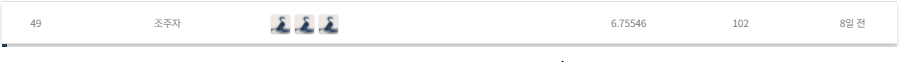